In [ ]:
# Importing functions and classes we'll use

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dropout, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from warnings import catch_warnings
from warnings import filterwarnings
import keras
import sys
import scipy.stats
import json
import numpy.fft
import time
from decimal import Decimal
import math
import seaborn as sns
%matplotlib inline

In [ ]:
df = pd.read_excel('/content/sample_data/new_dataset.xlsx')
node1_delay = df[['node1_delay']]

dataset = node1_delay.values

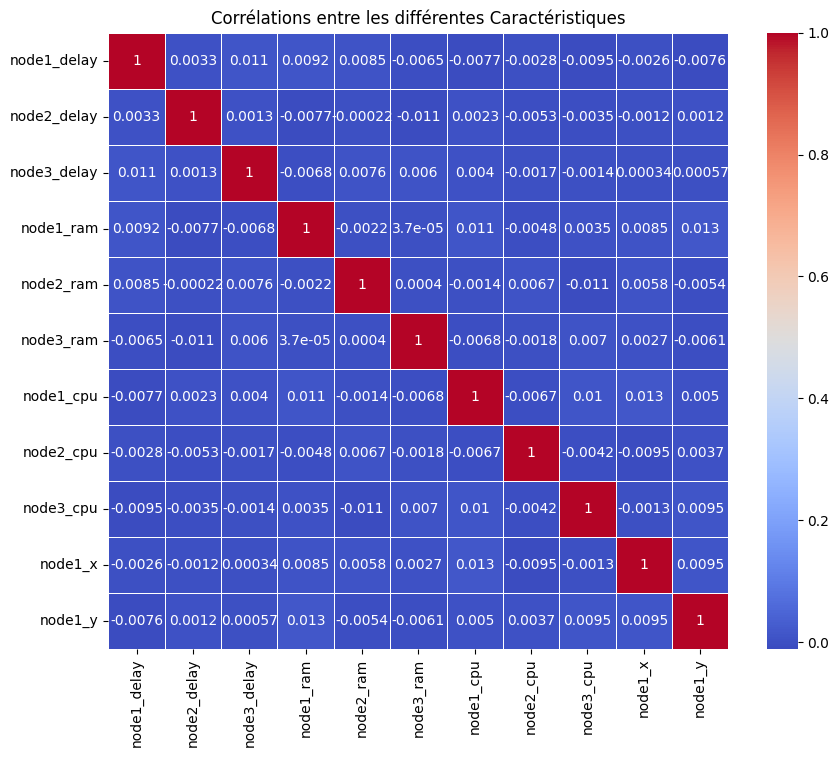

In [ ]:
# Select the columns you want to calculate the correlation for
selected_columns = ['node1_delay', 'node2_delay', 'node3_delay', 'node1_ram', 'node2_ram', 'node3_ram', 'node1_cpu', 'node2_cpu', 'node3_cpu', 'node1_x', 'node1_y']
# Calculate the correlation matrix
correlation_matrix = df[selected_columns].corr()
# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Corrélations entre les différentes Caractéristiques')
plt.show()

In [ ]:
df[selected_columns].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
node1_delay,20000.0,0.323828,0.152275,0.059012,0.191918,0.324079,0.456506,0.586923
node2_delay,20000.0,0.200986,0.053737,0.107939,0.154545,0.200765,0.247665,0.294275
node3_delay,20000.0,0.215486,0.086349,0.065931,0.140327,0.215022,0.290110,0.364288
node1_ram,20000.0,0.548665,0.149550,0.300000,0.400000,0.500000,0.700000,0.800000
node2_ram,20000.0,0.550655,0.149939,0.300000,0.400000,0.600000,0.700000,0.800000
node3_ram,20000.0,0.548180,0.149552,0.300000,0.400000,0.500000,0.700000,0.800000
node1_cpu,20000.0,0.534699,0.252282,0.100000,0.310000,0.530000,0.760000,0.970000
node2_cpu,20000.0,0.536648,0.251351,0.100000,0.320000,0.540000,0.750000,0.970000
node3_cpu,20000.0,0.535996,0.251008,0.100000,0.320000,0.540000,0.750000,0.970000
node1_x,20000.0,2.489950,1.712643,0.000000,1.000000,2.000000,4.000000,5.000000


# MA Filter Implementation

In [ ]:
# ASAP
class Metrics(object):
    def __init__(self, values):
        self.set_values( values )

    def set_values(self, values):
        self.values = values
        self.r = self.k = None

    @property
    def kurtosis(self):
        if self.k is None:
            self.k = scipy.stats.kurtosis(self.values)
        return self.k

    @property
    def roughness(self):
        if self.r is None:
            self.r = np.std(np.diff(self.values))
        return self.r

class ACF(Metrics):
    CORR_THRESH = 0.2
    def __init__(self, values, max_lag=None):
        super(ACF, self).__init__(values)
        if max_lag is None:
            max_lag = len(values) / 5
        self.max_lag = int(max_lag)
        self.max_acf = 0.0

        # Calculate autocorrelation via FFT
        # Demean
        demeaned = values - np.mean(values)
        # Pad data to power of 2
        l = int(2.0 ** (int(math.log(len(demeaned),2.0)) + 1))
        padded = np.append(demeaned, ([0.0] * (l - len(demeaned))))
        # FFT and inverse FFT
        F_f = numpy.fft.fft( padded )
        R_t = numpy.fft.ifft( F_f * np.conjugate(F_f) )
        self.correlations = R_t[:int(max_lag)].real / R_t[0].real

        # Find autocorrelation peaks
        self.peaks = []
        if len(self.correlations) >1 :
            positive = self.correlations[1] > self.correlations[0]
            max = 1
            for i in range(2, len(self.correlations)):
                if not positive and self.correlations[i] > self.correlations[i-1]:
                    max = i
                    positive = not positive
                elif positive and self.correlations[i] > self.correlations[max]:
                    max = i
                elif positive and self.correlations[i] < self.correlations[i-1]:
                    if max > 1 and self.correlations[max] > self.CORR_THRESH:
                        self.peaks.append(max)
                        if self.correlations[max] > self.max_acf:
                            self.max_acf = self.correlations[max]
                    positive = not positive
        # If there is no autocorrelation peak within the MAX_WINDOW boundary,
        # try windows from the largest to the smallest
        if len(self.peaks) <= 1:
            self.peaks = range(2, len(self.correlations))

def moving_average(data, _range):
    ret = np.cumsum(data)
    ret[_range:] = ret[int(_range):] - ret[:-int(_range)]
    return ret[int(_range) - 1:] / _range

def SMA(data, _range, slide):
    ret = moving_average(data, int(_range))[::int(slide)]
    return list(ret)

def binary_search(head,tail,data,min_obj,orig_kurt,window_size):
    while head <= tail:
        w = int(round((head + tail) / 2.0))
        smoothed = SMA(data,w,1)
        metrics  = Metrics(smoothed)
        if metrics.kurtosis >= orig_kurt:
            if metrics.roughness < min_obj:
                window_size = w
                min_obj = metrics.roughness
            head = w + 1
        else:
            tail = w - 1
    return window_size

def smooth_ASAP(data, max_window=5, resolution=None):
    data = np.array(data)
    # Preaggregate according to resolution
    slide_size = 1
    window_size = 1
    if resolution and len(data) >= 2 * resolution:
        slide_size = len(data) / resolution
        data = SMA(data, slide_size, slide_size)
    acf         = ACF(data, max_lag=len(data) / max_window)
    peaks       = acf.peaks
    orig_kurt   = acf.kurtosis
    min_obj     = acf.roughness
    lb          = 1
    largest_feasible = -1
    tail = len(data) / max_window
    for i in range(len(peaks) - 1, -1, -1):
        w = peaks[i]

        if w < lb or w == 1:
            break
        elif math.sqrt(1 - acf.correlations[w]) * window_size > math.sqrt(1 - acf.correlations[window_size]) * w:
            continue

        smoothed = SMA(data, w, 1)
        metrics = Metrics(smoothed)
        if metrics.roughness < min_obj and metrics.kurtosis >= orig_kurt:
            min_obj = metrics.roughness
            window_size = w
            lb = round( max(w*math.sqrt( (acf.max_acf -1) / (acf.correlations[w]-1) ), lb) )
    if largest_feasible > 0:
        if largest_feasible < len(peaks) - 2:
            tail = peaks[largest_feasible + 1]
        lb = max(lb, peaks[largest_feasible] + 1)

    window_size = binary_search(lb, tail, data, min_obj, orig_kurt, window_size)
    return window_size, slide_size

# Algorithm To transfer data in tabular format



In [ ]:
def create_multistep_dataset(data, n_input, n_out=1):
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            x_input = data[in_start:in_end]
            X.append(x_input)
            y.append(data[in_end:out_end])
        # move along one time step
        in_start += 1
    return np.array(X), np.array(y)

# Optuna Library

In [ ]:
!pip install -q optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.4 MB/s eta 0:00:00


In [ ]:
import optuna
from optuna.samplers import TPESampler

# First Dataset : In-House Dataset

## Time Series 1 : Node1 Delay

### Persistence Model

In [ ]:
node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, 1, 1)
testX, testY = create_multistep_dataset(test, 1, 1)

# Record the starting time to generate predictions
start_time = time.time()

predictions = testX[:,-1]

# Record the ending time
end_time = time.time()
elapsed_time = end_time - start_time

testRMSE = np.sqrt(mean_squared_error(testY, predictions))
testMAE = mean_absolute_error(testY, predictions)

print('Persistence Test RMSE : %.5f' % (testRMSE))
print('Persistence Test MAE : %.5f' % (testMAE))
print("Persistence Elapsed Time : %.5f" % (elapsed_time), "seconds")

Window Size:  10
17991 2000
Persistence Test RMSE : 0.02211
Persistence Test MAE : 0.01808
Persistence Elapsed Time : 0.00011 seconds


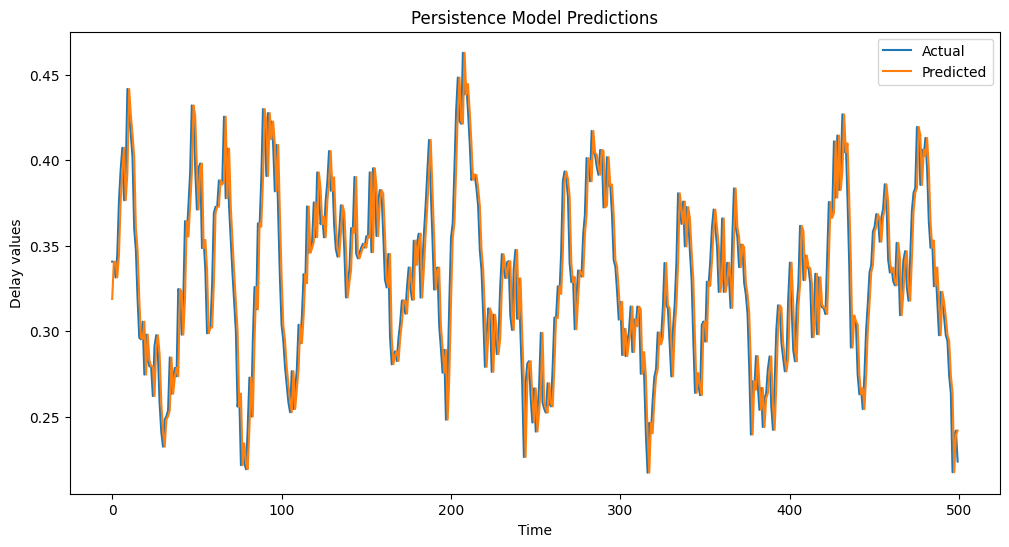

In [ ]:
# Plot actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(testY[:500], label='Actual')
plt.plot(predictions[:500], label='Predicted')

plt.xlabel('Time')
plt.ylabel('Delay values')
plt.title('Persistence Model Predictions')
plt.legend()
plt.show()

### ARIMA Model

In [ ]:
# one-step sarima forecast
def sarima_forecast(history, config, window_size):
  order, sorder, trend = config
  # define model
  model = SARIMAX(history[-window_size:], order=order, seasonal_order=sorder, trend=trend,
                  enforce_stationarity=False, enforce_invertibility=False)
  # fit model
  model_fit = model.fit(disp=False)
  # make one step forecast
  yhat = model_fit.predict(len(history[-window_size:]), len(history[-window_size:]))
  return yhat[0]

In [ ]:
# root mean squared error or rmse
def measure_rmse(actual, predicted):
  return np.sqrt(mean_squared_error(actual, predicted))

In [ ]:
# mean absolute error or mae
def measure_mae(actual, predicted):
  return mean_absolute_error(actual, predicted)

In [ ]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
  return data[:-n_test], data[-n_test:]

In [ ]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg, window_size):
  predictions = list()
  # split dataset
  train, test = train_test_split(data, n_test)
  # seed history with training dataset
  history = [x for x in train]
  # step over each time-step in the test set
  for i in range(len(test)):
    # fit model and make forecast for history
    yhat = sarima_forecast(history, cfg, window_size)
    # store forecast in list of predictions
    predictions.append(yhat)
    # add actual observation to history for the next loop
    history.append(test[i])
  # estimate prediction error
  error = measure_rmse(test, predictions)
  # error = measure_mae(test, predictions)
  return error

In [ ]:
# score a model, return None on failure
def score_model(data, n_test, cfg, window_size, debug=False):
  result = None
  # convert config to a key
  key = str(cfg)
  # show all warnings and fail on exception if debugging
  if debug:
    result = walk_forward_validation(data, n_test, cfg, window_size)
  else:
    # one failure during model validation suggests an unstable config
    try:
      # never show warnings when grid searching, too noisy
      with catch_warnings():
        filterwarnings("ignore")
        result = walk_forward_validation(data, n_test, cfg, window_size)
    except:
      error = None
  # check for an interesting result
  if result is not None:
    print(' > Model[%s] %.3f, window size : %d' % (key, result, window_size))
  return (key, result)

In [ ]:
# Finding Model Parameters

def optimize_parameters(data, n_test):
    def objective(trial):
        # define search space for hyperparameters
        p = trial.suggest_int('p', 0, 3)
        d = trial.suggest_int('d', 0, 2)
        q = trial.suggest_int('q', 0, 3)
        P = trial.suggest_int('P', 0, 3)
        D = trial.suggest_int('D', 0, 1)
        Q = trial.suggest_int('Q', 0, 3)
        m = trial.suggest_categorical('m', [0])
        trend = trial.suggest_categorical('trend', ['n', 'c', 't', 'ct'])
        window_size = trial.suggest_int('window_size', 0, 500)

        order = (p, d, q)
        seasonal_order = (P, D, Q, m)

        cfg = (order, seasonal_order, trend)
        error = score_model(data, n_test, cfg, window_size)[1]

        return error

    study = optuna.create_study(direction='minimize', sampler=TPESampler())
    study.optimize(objective, n_trials=100, n_jobs=-1)

    best_params = study.best_params
    best_error = study.best_value

    return best_params, best_error

In [ ]:
# Define Dataset

node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
valid_size = int(len(train) * 0.1)
temp_train = train[:-valid_size]
valid = train[-valid_size:]
print(len(train), len(temp_train), len(valid), len(test))

# Record the starting time to generate predictions
start_time = time.time()

scores = optimize_parameters(train, valid_size)

# Record the ending time
end_time = time.time()
elapsed_time = end_time - start_time

print('done')
print("ARIMA HyperParameters Tuning Elapsed Time : %.5f" % (elapsed_time), "seconds")

[I 2023-08-26 20:55:39,442] A new study created in memory with name: no-name-6d4834e8-1909-4e3e-8395-5106815db338
[W 2023-08-26 20:55:39,474] Trial 0 failed with parameters: {'p': 3, 'd': 0, 'q': 2, 'P': 0, 'D': 0, 'Q': 3, 'm': 0, 'trend': 't', 'window_size': 329} because of the following error: The value None could not be cast to float..
[W 2023-08-26 20:55:39,495] Trial 0 failed with value None.
[W 2023-08-26 20:55:39,492] Trial 1 failed with parameters: {'p': 0, 'd': 2, 'q': 0, 'P': 1, 'D': 1, 'Q': 0, 'm': 0, 'trend': 'c', 'window_size': 231} because of the following error: The value None could not be cast to float..
[W 2023-08-26 20:55:39,525] Trial 1 failed with value None.
[W 2023-08-26 20:55:39,508] Trial 2 failed with parameters: {'p': 3, 'd': 1, 'q': 1, 'P': 1, 'D': 0, 'Q': 0, 'm': 0, 'trend': 'ct', 'window_size': 93} because of the following error: The value None could not be cast to float..
[W 2023-08-26 20:55:39,533] Trial 2 failed with value None.
[W 2023-08-26 20:55:39,54

Window Size:  10
17991 16192 1799 2000


[W 2023-08-26 20:55:39,599] Trial 5 failed with parameters: {'p': 3, 'd': 1, 'q': 1, 'P': 3, 'D': 0, 'Q': 3, 'm': 0, 'trend': 't', 'window_size': 118} because of the following error: The value None could not be cast to float..
[W 2023-08-26 20:55:39,650] Trial 5 failed with value None.
[W 2023-08-26 20:55:39,648] Trial 6 failed with parameters: {'p': 2, 'd': 1, 'q': 3, 'P': 1, 'D': 1, 'Q': 1, 'm': 0, 'trend': 'c', 'window_size': 323} because of the following error: The value None could not be cast to float..
[W 2023-08-26 20:55:39,678] Trial 6 failed with value None.
[W 2023-08-26 20:55:39,676] Trial 7 failed with parameters: {'p': 0, 'd': 2, 'q': 3, 'P': 2, 'D': 1, 'Q': 2, 'm': 0, 'trend': 'c', 'window_size': 322} because of the following error: The value None could not be cast to float..
[W 2023-08-26 20:55:39,696] Trial 7 failed with value None.
[W 2023-08-26 20:55:39,686] Trial 8 failed with parameters: {'p': 1, 'd': 1, 'q': 2, 'P': 2, 'D': 0, 'Q': 2, 'm': 0, 'trend': 't', 'window_

 > Model[((0, 1, 0), (0, 0, 0, 0), 'n')] 0.021, window size : 313


[W 2023-08-26 20:59:57,652] Trial 40 failed with parameters: {'p': 0, 'd': 2, 'q': 3, 'P': 0, 'D': 1, 'Q': 2, 'm': 0, 'trend': 'c', 'window_size': 70} because of the following error: The value None could not be cast to float..
[W 2023-08-26 20:59:57,656] Trial 40 failed with value None.
[W 2023-08-26 20:59:57,668] Trial 41 failed with parameters: {'p': 2, 'd': 0, 'q': 0, 'P': 1, 'D': 0, 'Q': 0, 'm': 0, 'trend': 'n', 'window_size': 27} because of the following error: The value None could not be cast to float..
[W 2023-08-26 20:59:57,680] Trial 41 failed with value None.
[W 2023-08-26 20:59:57,708] Trial 42 failed with parameters: {'p': 2, 'd': 0, 'q': 1, 'P': 3, 'D': 0, 'Q': 3, 'm': 0, 'trend': 'n', 'window_size': 176} because of the following error: The value None could not be cast to float..
[W 2023-08-26 20:59:57,716] Trial 42 failed with value None.
[W 2023-08-26 20:59:57,727] Trial 43 failed with parameters: {'p': 3, 'd': 2, 'q': 2, 'P': 1, 'D': 1, 'Q': 2, 'm': 0, 'trend': 'n', 'wi

 > Model[((1, 1, 1), (0, 0, 0, 0), 'n')] 0.022, window size : 73


[I 2023-08-26 21:23:58,014] Trial 11 finished with value: 0.02625302796356937 and parameters: {'p': 2, 'd': 2, 'q': 2, 'P': 0, 'D': 0, 'Q': 0, 'm': 0, 'trend': 'ct', 'window_size': 246}. Best is trial 44 with value: 0.021593159955443055.


 > Model[((2, 2, 2), (0, 0, 0, 0), 'ct')] 0.026, window size : 246


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

 > Model[((2, 0, 1), (0, 0, 0, 0), 'c')] 0.555, window size : 160


[W 2023-08-26 21:31:06,921] Trial 91 failed with parameters: {'p': 2, 'd': 1, 'q': 2, 'P': 3, 'D': 1, 'Q': 1, 'm': 0, 'trend': 'c', 'window_size': 306} because of the following error: The value None could not be cast to float..
[W 2023-08-26 21:31:06,932] Trial 91 failed with value None.
[W 2023-08-26 21:31:06,945] Trial 92 failed with parameters: {'p': 2, 'd': 1, 'q': 3, 'P': 0, 'D': 1, 'Q': 1, 'm': 0, 'trend': 'c', 'window_size': 204} because of the following error: The value None could not be cast to float..
[W 2023-08-26 21:31:06,955] Trial 92 failed with value None.
[W 2023-08-26 21:31:06,973] Trial 93 failed with parameters: {'p': 0, 'd': 2, 'q': 1, 'P': 2, 'D': 1, 'Q': 3, 'm': 0, 'trend': 'n', 'window_size': 279} because of the following error: The value None could not be cast to float..
[W 2023-08-26 21:31:06,984] Trial 93 failed with value None.
[W 2023-08-26 21:31:07,004] Trial 94 failed with parameters: {'p': 3, 'd': 1, 'q': 2, 'P': 0, 'D': 1, 'Q': 1, 'm': 0, 'trend': 'n', '

 > Model[((3, 2, 3), (0, 0, 0, 0), 't')] 0.034, window size : 387
done
ARIMA HyperParameters Tuning Elapsed Time : 2221.68527 seconds


In [ ]:
print("Best Params : ", scores)

Best Params :  ({'p': 0, 'd': 1, 'q': 0, 'P': 0, 'D': 0, 'Q': 0, 'm': 0, 'trend': 'n', 'window_size': 313}, 0.021318088880642325)


In [ ]:
predictions = []
cfg = ((1, 0, 1), (0, 0, 0, 0), 'c')
window_size = 285

# seed history with training dataset
history = [x for x in train]

# Record the starting time to generate predictions
start_time = time.time()

# step over each time-step in the test set
for i in range(len(test)):
    # fit model and make forecast for history
    yhat = sarima_forecast(history, cfg, window_size)
    # store forecast in list of predictions
    predictions.append(yhat)
    # add actual observation to history for the next loop
    history.append(test[i])
    # estimate prediction error


# Record the ending time
end_time = time.time()
elapsed_time = end_time - start_time

ARIMA_RMSE = measure_rmse(test, predictions)
ARIMA_MAE = measure_mae(test, predictions)

print('ARIMA Test RMSE : %.5f' % (ARIMA_RMSE))
print('ARIMA Test MAE : %.5f' % (ARIMA_MAE))
print("ARIMA Elapsed Time To generate Predictions : %.5f" % (elapsed_time), "seconds")

ARIMA Test RMSE : 0.02171
ARIMA Test MAE : 0.01775
ARIMA Elapsed Time To generate Predictions : 322.23809 seconds


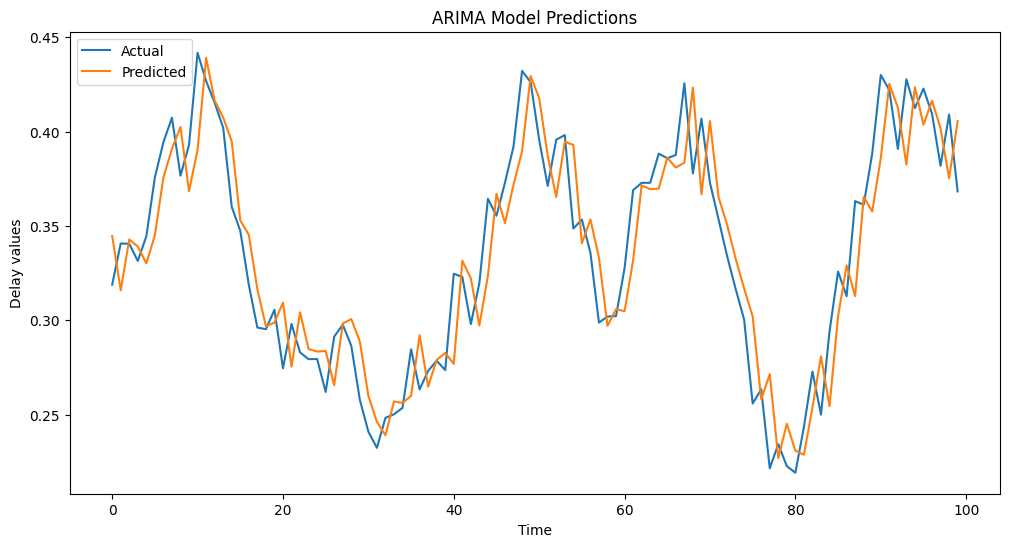

In [ ]:
# Plot actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(test[:100], label='Actual')
plt.plot(predictions[:100], label='Predicted')

plt.xlabel('Time')
plt.ylabel('Delay values')
plt.title('ARIMA Model Predictions')
plt.legend()
plt.show()

### LSTM Model

In [ ]:
# Hyper Parameters tuning

node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
valid_size = int(len(train) * 0.1)
temp_train = train[:-valid_size]
valid = train[-valid_size:]
print(len(train), len(temp_train), len(valid), len(test))

def objective(trial):
    # define search space for hyperparameters
    look_back = trial.suggest_int('look_back', 5, 300)
    num_hidden_layers = trial.suggest_int('num_hidden_layers', 1, 10)

    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    batch_size = trial.suggest_int('batch_size', 5, 300)
    epochs = trial.suggest_int('epochs', 10, 100)

    # reshape into X=t and Y=t+1
    trainX, trainY = create_multistep_dataset(temp_train, look_back, 1)
    validX, validY = create_multistep_dataset(valid, look_back, 1)

    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    validX = np.reshape(validX, (validX.shape[0], 1, validX.shape[1]))
    print(trainX.shape)

    # Crée et entraîne le modèle pour l'horizon de prévision i
    model = Sequential()
    for i in range(num_hidden_layers):
        num_units = trial.suggest_int(f'lstm_units_layer_{i}', 8, 256, log=True)
        return_sequences = (i < num_hidden_layers - 1)
        model.add(LSTM(units=num_units, return_sequences=return_sequences))
    model.add(Dense(1))
    optimizer = keras.optimizers.Adam(lr=learning_rate)
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=0)
    validPredict = model.predict(validX, verbose=0)

    # calculate root mean squared error
    validScore = np.sqrt(mean_squared_error(validY, validPredict))

    return validScore

study = optuna.create_study(direction='minimize', sampler=TPESampler())

# Record the starting time to generate predictions
start_time = time.time()

study.optimize(objective, n_trials=100, n_jobs=-1)

# Record the ending time
end_time = time.time()
elapsed_time = end_time - start_time

print('done')
print("LSTM HyperParameters Tuning Elapsed Time : %.5f" % (elapsed_time), "seconds")

best_params = study.best_params
best_error = study.best_value

print("Done")
print(f"best_params: {best_params}, best_error: {best_error}")

[I 2023-08-27 05:30:52,638] A new study created in memory with name: no-name-6dd5c850-8a77-434a-8905-f414605580dd


Window Size:  10
17991 16192 1799 2000
(16154, 1, 38)(15965, 1, 227)



<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-27 05:33:58,354] Trial 0 finished with value: 0.01944449244465805 and parameters: {'look_back': 227, 'num_hidden_layers': 6, 'learning_rate': 0.00025512702139332565, 'batch_size': 197, 'epochs': 76, 'lstm_units_layer_0': 219, 'lstm_units_layer_1': 63, 'lstm_units_layer_2': 43, 'lstm_units_layer_3': 18, 'lstm_units_layer_4': 45, 'lstm_units_layer_5': 107}. Best is trial 0 with value: 0.01944449244465805.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been depre

(16017, 1, 175)


[I 2023-08-27 05:34:40,933] Trial 2 finished with value: 0.02049108200744867 and parameters: {'look_back': 175, 'num_hidden_layers': 1, 'learning_rate': 0.0020695902733518655, 'batch_size': 175, 'epochs': 74, 'lstm_units_layer_0': 48}. Best is trial 0 with value: 0.01944449244465805.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(15937, 1, 255)


[I 2023-08-27 05:35:48,770] Trial 1 finished with value: 0.01889695244394316 and parameters: {'look_back': 38, 'num_hidden_layers': 7, 'learning_rate': 0.000213920613689588, 'batch_size': 102, 'epochs': 100, 'lstm_units_layer_0': 10, 'lstm_units_layer_1': 249, 'lstm_units_layer_2': 66, 'lstm_units_layer_3': 24, 'lstm_units_layer_4': 156, 'lstm_units_layer_5': 16, 'lstm_units_layer_6': 35}. Best is trial 1 with value: 0.01889695244394316.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(15907, 1, 285)


[I 2023-08-27 05:37:03,324] Trial 4 finished with value: 0.04978150465664724 and parameters: {'look_back': 285, 'num_hidden_layers': 6, 'learning_rate': 3.4332668526487006e-05, 'batch_size': 101, 'epochs': 21, 'lstm_units_layer_0': 21, 'lstm_units_layer_1': 180, 'lstm_units_layer_2': 225, 'lstm_units_layer_3': 114, 'lstm_units_layer_4': 8, 'lstm_units_layer_5': 18}. Best is trial 1 with value: 0.01889695244394316.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16120, 1, 72)


[I 2023-08-27 05:37:22,994] Trial 3 finished with value: 0.052060416345540074 and parameters: {'look_back': 255, 'num_hidden_layers': 7, 'learning_rate': 0.08028640574130752, 'batch_size': 139, 'epochs': 70, 'lstm_units_layer_0': 14, 'lstm_units_layer_1': 123, 'lstm_units_layer_2': 48, 'lstm_units_layer_3': 56, 'lstm_units_layer_4': 53, 'lstm_units_layer_5': 199, 'lstm_units_layer_6': 120}. Best is trial 1 with value: 0.01889695244394316.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(15956, 1, 236)


[I 2023-08-27 05:39:59,607] Trial 6 finished with value: 0.018323714976749103 and parameters: {'look_back': 236, 'num_hidden_layers': 9, 'learning_rate': 0.004187852313207384, 'batch_size': 259, 'epochs': 93, 'lstm_units_layer_0': 90, 'lstm_units_layer_1': 13, 'lstm_units_layer_2': 237, 'lstm_units_layer_3': 168, 'lstm_units_layer_4': 121, 'lstm_units_layer_5': 108, 'lstm_units_layer_6': 55, 'lstm_units_layer_7': 21, 'lstm_units_layer_8': 12}. Best is trial 6 with value: 0.018323714976749103.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16028, 1, 164)


[I 2023-08-27 05:41:14,232] Trial 7 finished with value: 0.019020461764881192 and parameters: {'look_back': 164, 'num_hidden_layers': 7, 'learning_rate': 0.0006988208662721925, 'batch_size': 288, 'epochs': 51, 'lstm_units_layer_0': 73, 'lstm_units_layer_1': 50, 'lstm_units_layer_2': 14, 'lstm_units_layer_3': 60, 'lstm_units_layer_4': 106, 'lstm_units_layer_5': 105, 'lstm_units_layer_6': 16}. Best is trial 6 with value: 0.018323714976749103.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16187, 1, 5)


[I 2023-08-27 05:42:22,597] Trial 8 finished with value: 0.02047821285223997 and parameters: {'look_back': 5, 'num_hidden_layers': 7, 'learning_rate': 0.0039058900358853515, 'batch_size': 133, 'epochs': 20, 'lstm_units_layer_0': 201, 'lstm_units_layer_1': 10, 'lstm_units_layer_2': 14, 'lstm_units_layer_3': 47, 'lstm_units_layer_4': 29, 'lstm_units_layer_5': 11, 'lstm_units_layer_6': 48}. Best is trial 6 with value: 0.018323714976749103.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16048, 1, 144)


[I 2023-08-27 05:43:12,058] Trial 9 finished with value: 0.023374931093702807 and parameters: {'look_back': 144, 'num_hidden_layers': 5, 'learning_rate': 0.0038436862198702893, 'batch_size': 169, 'epochs': 23, 'lstm_units_layer_0': 67, 'lstm_units_layer_1': 11, 'lstm_units_layer_2': 44, 'lstm_units_layer_3': 11, 'lstm_units_layer_4': 196}. Best is trial 6 with value: 0.018323714976749103.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16124, 1, 68)


[I 2023-08-27 05:44:14,305] Trial 10 finished with value: 0.020571644528977116 and parameters: {'look_back': 68, 'num_hidden_layers': 7, 'learning_rate': 0.008554365917352565, 'batch_size': 78, 'epochs': 10, 'lstm_units_layer_0': 204, 'lstm_units_layer_1': 8, 'lstm_units_layer_2': 10, 'lstm_units_layer_3': 56, 'lstm_units_layer_4': 215, 'lstm_units_layer_5': 55, 'lstm_units_layer_6': 68}. Best is trial 6 with value: 0.018323714976749103.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(15978, 1, 214)


[I 2023-08-27 05:45:12,961] Trial 5 finished with value: 0.018001737872518502 and parameters: {'look_back': 72, 'num_hidden_layers': 3, 'learning_rate': 0.008101381214428806, 'batch_size': 27, 'epochs': 89, 'lstm_units_layer_0': 10, 'lstm_units_layer_1': 21, 'lstm_units_layer_2': 32}. Best is trial 5 with value: 0.018001737872518502.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16091, 1, 101)


[I 2023-08-27 05:46:43,407] Trial 11 finished with value: 0.04972571081669034 and parameters: {'look_back': 214, 'num_hidden_layers': 10, 'learning_rate': 0.024701214295560475, 'batch_size': 287, 'epochs': 88, 'lstm_units_layer_0': 101, 'lstm_units_layer_1': 22, 'lstm_units_layer_2': 216, 'lstm_units_layer_3': 230, 'lstm_units_layer_4': 83, 'lstm_units_layer_5': 41, 'lstm_units_layer_6': 256, 'lstm_units_layer_7': 19, 'lstm_units_layer_8': 10, 'lstm_units_layer_9': 182}. Best is trial 5 with value: 0.018001737872518502.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().

(16091, 1, 101)


[I 2023-08-27 06:09:19,712] Trial 13 finished with value: 0.01869444265997788 and parameters: {'look_back': 101, 'num_hidden_layers': 3, 'learning_rate': 0.015135666897793904, 'batch_size': 11, 'epochs': 97, 'lstm_units_layer_0': 28, 'lstm_units_layer_1': 21, 'lstm_units_layer_2': 112}. Best is trial 5 with value: 0.018001737872518502.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16088, 1, 104)


[I 2023-08-27 06:11:10,891] Trial 14 finished with value: 0.053565561597700824 and parameters: {'look_back': 104, 'num_hidden_layers': 9, 'learning_rate': 0.04466409536933965, 'batch_size': 233, 'epochs': 52, 'lstm_units_layer_0': 9, 'lstm_units_layer_1': 20, 'lstm_units_layer_2': 27, 'lstm_units_layer_3': 222, 'lstm_units_layer_4': 251, 'lstm_units_layer_5': 237, 'lstm_units_layer_6': 9, 'lstm_units_layer_7': 93, 'lstm_units_layer_8': 27}. Best is trial 5 with value: 0.018001737872518502.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16074, 1, 118)


[I 2023-08-27 06:14:13,090] Trial 12 finished with value: 0.050703583812487296 and parameters: {'look_back': 101, 'num_hidden_layers': 10, 'learning_rate': 0.021787705531086828, 'batch_size': 21, 'epochs': 100, 'lstm_units_layer_0': 25, 'lstm_units_layer_1': 20, 'lstm_units_layer_2': 236, 'lstm_units_layer_3': 251, 'lstm_units_layer_4': 91, 'lstm_units_layer_5': 246, 'lstm_units_layer_6': 249, 'lstm_units_layer_7': 20, 'lstm_units_layer_8': 9, 'lstm_units_layer_9': 30}. Best is trial 5 with value: 0.018001737872518502.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super()._

(15982, 1, 210)


[I 2023-08-27 06:15:23,965] Trial 16 finished with value: 0.0184521171916268 and parameters: {'look_back': 210, 'num_hidden_layers': 3, 'learning_rate': 0.007785813944695374, 'batch_size': 221, 'epochs': 84, 'lstm_units_layer_0': 8, 'lstm_units_layer_1': 30, 'lstm_units_layer_2': 107}. Best is trial 5 with value: 0.018001737872518502.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(15893, 1, 299)


[I 2023-08-27 06:19:04,367] Trial 17 finished with value: 0.01964897931274433 and parameters: {'look_back': 299, 'num_hidden_layers': 3, 'learning_rate': 0.0012196359861349714, 'batch_size': 46, 'epochs': 64, 'lstm_units_layer_0': 38, 'lstm_units_layer_1': 14, 'lstm_units_layer_2': 24}. Best is trial 5 with value: 0.018001737872518502.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16054, 1, 138)


[I 2023-08-27 06:19:50,631] Trial 18 finished with value: 0.04987112816789524 and parameters: {'look_back': 138, 'num_hidden_layers': 4, 'learning_rate': 0.07203147660676887, 'batch_size': 257, 'epochs': 43, 'lstm_units_layer_0': 12, 'lstm_units_layer_1': 35, 'lstm_units_layer_2': 118, 'lstm_units_layer_3': 113}. Best is trial 5 with value: 0.018001737872518502.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16128, 1, 64)


[I 2023-08-27 06:20:40,517] Trial 15 finished with value: 0.016922394641877482 and parameters: {'look_back': 118, 'num_hidden_layers': 3, 'learning_rate': 0.009747811435950207, 'batch_size': 19, 'epochs': 88, 'lstm_units_layer_0': 32, 'lstm_units_layer_1': 30, 'lstm_units_layer_2': 115}. Best is trial 15 with value: 0.016922394641877482.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16141, 1, 51)


[I 2023-08-27 06:21:59,935] Trial 19 finished with value: 0.016884516292020726 and parameters: {'look_back': 64, 'num_hidden_layers': 1, 'learning_rate': 0.007161690425893443, 'batch_size': 57, 'epochs': 86, 'lstm_units_layer_0': 16}. Best is trial 19 with value: 0.016884516292020726.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16187, 1, 5)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-27 06:22:31,228] Trial 20 finished with value: 0.018405076104037407 and parameters: {'look_back': 51, 'num_hidden_layers': 1, 'learning_rate': 0.011274155972001257, 'batch_size': 62, 'epochs': 81, 'lstm_units_layer_0': 16}. Best is trial 19 with value: 0.016884516292020726.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16116, 1, 76)


[I 2023-08-27 06:23:21,763] Trial 21 finished with value: 0.02058472691460737 and parameters: {'look_back': 5, 'num_hidden_layers': 1, 'learning_rate': 0.03351138082632508, 'batch_size': 72, 'epochs': 63, 'lstm_units_layer_0': 17}. Best is trial 19 with value: 0.016884516292020726.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16119, 1, 73)


[I 2023-08-27 06:25:35,958] Trial 22 finished with value: 0.01834032677755058 and parameters: {'look_back': 76, 'num_hidden_layers': 2, 'learning_rate': 0.030913593618720245, 'batch_size': 34, 'epochs': 63, 'lstm_units_layer_0': 17, 'lstm_units_layer_1': 63}. Best is trial 19 with value: 0.016884516292020726.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16063, 1, 129)


[I 2023-08-27 06:28:05,591] Trial 23 finished with value: 0.017966715950871764 and parameters: {'look_back': 73, 'num_hidden_layers': 2, 'learning_rate': 0.010686743878914834, 'batch_size': 38, 'epochs': 89, 'lstm_units_layer_0': 20, 'lstm_units_layer_1': 66}. Best is trial 19 with value: 0.016884516292020726.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16077, 1, 115)


[I 2023-08-27 06:47:29,534] Trial 24 finished with value: 0.019193758571506528 and parameters: {'look_back': 129, 'num_hidden_layers': 2, 'learning_rate': 0.009414302882500291, 'batch_size': 8, 'epochs': 89, 'lstm_units_layer_0': 12, 'lstm_units_layer_1': 35}. Best is trial 19 with value: 0.016884516292020726.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16157, 1, 35)


[I 2023-08-27 06:49:16,605] Trial 26 finished with value: 0.01803060721584774 and parameters: {'look_back': 35, 'num_hidden_layers': 2, 'learning_rate': 0.016546180614787076, 'batch_size': 102, 'epochs': 80, 'lstm_units_layer_0': 32, 'lstm_units_layer_1': 91}. Best is trial 19 with value: 0.016884516292020726.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16073, 1, 119)


[I 2023-08-27 06:53:21,040] Trial 27 finished with value: 0.05430998745230387 and parameters: {'look_back': 119, 'num_hidden_layers': 4, 'learning_rate': 0.0864010046830245, 'batch_size': 56, 'epochs': 71, 'lstm_units_layer_0': 23, 'lstm_units_layer_1': 50, 'lstm_units_layer_2': 74, 'lstm_units_layer_3': 8}. Best is trial 19 with value: 0.016884516292020726.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16103, 1, 89)


[I 2023-08-27 06:54:26,918] Trial 28 finished with value: 0.017717781813891564 and parameters: {'look_back': 89, 'num_hidden_layers': 2, 'learning_rate': 0.004892684686219318, 'batch_size': 87, 'epochs': 41, 'lstm_units_layer_0': 30, 'lstm_units_layer_1': 90}. Best is trial 19 with value: 0.016884516292020726.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16023, 1, 169)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-27 06:54:52,509] Trial 25 finished with value: 0.021416587606895608 and parameters: {'look_back': 115, 'num_hidden_layers': 2, 'learning_rate': 0.018837039070523816, 'batch_size': 6, 'epochs': 80, 'lstm_units_layer_0': 30, 'lstm_units_layer_1': 94}. Best is trial 19 with value: 0.016884516292020726.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16021, 1, 171)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-27 06:56:06,242] Trial 29 finished with value: 0.01869416474540747 and parameters: {'look_back': 169, 'num_hidden_layers': 4, 'learning_rate': 0.0020884061390779502, 'batch_size': 84, 'epochs': 38, 'lstm_units_layer_0': 33, 'lstm_units_layer_1': 115, 'lstm_units_layer_2': 142, 'lstm_units_layer_3': 32}. Best is trial 19 with value: 0.016884516292020726.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learni

(16102, 1, 90)


[I 2023-08-27 06:56:14,687] Trial 30 finished with value: 0.02298838664082258 and parameters: {'look_back': 171, 'num_hidden_layers': 4, 'learning_rate': 0.002417025186621335, 'batch_size': 122, 'epochs': 42, 'lstm_units_layer_0': 40, 'lstm_units_layer_1': 41, 'lstm_units_layer_2': 145, 'lstm_units_layer_3': 29}. Best is trial 19 with value: 0.016884516292020726.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16108, 1, 84)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-27 06:57:28,798] Trial 32 finished with value: 0.020500462715573584 and parameters: {'look_back': 84, 'num_hidden_layers': 1, 'learning_rate': 0.005429519546961707, 'batch_size': 52, 'epochs': 38, 'lstm_units_layer_0': 22}. Best is trial 19 with value: 0.016884516292020726.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16145, 1, 47)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-27 06:57:32,208] Trial 31 finished with value: 0.017802908355751653 and parameters: {'look_back': 90, 'num_hidden_layers': 5, 'learning_rate': 0.0050690085562873355, 'batch_size': 126, 'epochs': 39, 'lstm_units_layer_0': 41, 'lstm_units_layer_1': 47, 'lstm_units_layer_2': 159, 'lstm_units_layer_3': 16, 'lstm_units_layer_4': 21}. Best is trial 19 with value: 0.016884516292020726.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16145, 1, 47)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-27 06:58:47,554] Trial 34 finished with value: 0.018060597464549123 and parameters: {'look_back': 47, 'num_hidden_layers': 5, 'learning_rate': 0.0037240950052801506, 'batch_size': 118, 'epochs': 30, 'lstm_units_layer_0': 48, 'lstm_units_layer_1': 46, 'lstm_units_layer_2': 82, 'lstm_units_layer_3': 15, 'lstm_units_layer_4': 20}. Best is trial 19 with value: 0.016884516292020726.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument i

(16101, 1, 91)


[I 2023-08-27 06:59:08,288] Trial 33 finished with value: 0.018214355741946058 and parameters: {'look_back': 47, 'num_hidden_layers': 2, 'learning_rate': 0.012787723413974009, 'batch_size': 39, 'epochs': 29, 'lstm_units_layer_0': 20, 'lstm_units_layer_1': 67}. Best is trial 19 with value: 0.016884516292020726.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16165, 1, 27)


[I 2023-08-27 07:00:24,588] Trial 35 finished with value: 0.018213072176932972 and parameters: {'look_back': 91, 'num_hidden_layers': 5, 'learning_rate': 0.0011559474545569913, 'batch_size': 147, 'epochs': 47, 'lstm_units_layer_0': 27, 'lstm_units_layer_1': 70, 'lstm_units_layer_2': 155, 'lstm_units_layer_3': 9, 'lstm_units_layer_4': 15}. Best is trial 19 with value: 0.016884516292020726.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16000, 1, 192)


[I 2023-08-27 07:00:38,357] Trial 36 finished with value: 0.01814937454920473 and parameters: {'look_back': 27, 'num_hidden_layers': 5, 'learning_rate': 0.0008436693603022182, 'batch_size': 159, 'epochs': 48, 'lstm_units_layer_0': 27, 'lstm_units_layer_1': 27, 'lstm_units_layer_2': 162, 'lstm_units_layer_3': 8, 'lstm_units_layer_4': 16}. Best is trial 19 with value: 0.016884516292020726.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16130, 1, 62)


[I 2023-08-27 07:01:25,895] Trial 37 finished with value: 0.020851691842134007 and parameters: {'look_back': 192, 'num_hidden_layers': 1, 'learning_rate': 0.005938594001244686, 'batch_size': 92, 'epochs': 55, 'lstm_units_layer_0': 47}. Best is trial 19 with value: 0.016884516292020726.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16132, 1, 60)


[I 2023-08-27 07:02:06,005] Trial 38 finished with value: 0.01755570130741738 and parameters: {'look_back': 62, 'num_hidden_layers': 1, 'learning_rate': 0.006930895040402749, 'batch_size': 90, 'epochs': 55, 'lstm_units_layer_0': 37}. Best is trial 19 with value: 0.016884516292020726.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16129, 1, 63)


[I 2023-08-27 07:02:47,043] Trial 39 finished with value: 0.01894917240676633 and parameters: {'look_back': 60, 'num_hidden_layers': 6, 'learning_rate': 0.0025676646834908606, 'batch_size': 194, 'epochs': 59, 'lstm_units_layer_0': 37, 'lstm_units_layer_1': 54, 'lstm_units_layer_2': 87, 'lstm_units_layer_3': 13, 'lstm_units_layer_4': 31, 'lstm_units_layer_5': 9}. Best is trial 19 with value: 0.016884516292020726.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16167, 1, 25)


[I 2023-08-27 07:03:19,365] Trial 40 finished with value: 0.01884736037396449 and parameters: {'look_back': 63, 'num_hidden_layers': 1, 'learning_rate': 0.002922533802687876, 'batch_size': 100, 'epochs': 74, 'lstm_units_layer_0': 35}. Best is trial 19 with value: 0.016884516292020726.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16169, 1, 23)


[I 2023-08-27 07:03:49,347] Trial 41 finished with value: 0.01780521123511011 and parameters: {'look_back': 25, 'num_hidden_layers': 1, 'learning_rate': 0.0004650760363249401, 'batch_size': 106, 'epochs': 68, 'lstm_units_layer_0': 32}. Best is trial 19 with value: 0.016884516292020726.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16100, 1, 92)


[I 2023-08-27 07:04:15,249] Trial 42 finished with value: 0.018443526867941797 and parameters: {'look_back': 23, 'num_hidden_layers': 3, 'learning_rate': 0.005018503222548625, 'batch_size': 115, 'epochs': 33, 'lstm_units_layer_0': 54, 'lstm_units_layer_1': 174, 'lstm_units_layer_2': 179}. Best is trial 19 with value: 0.016884516292020726.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16100, 1, 92)


[I 2023-08-27 07:05:18,585] Trial 43 finished with value: 0.01824306023407536 and parameters: {'look_back': 92, 'num_hidden_layers': 3, 'learning_rate': 0.006422501897179141, 'batch_size': 69, 'epochs': 35, 'lstm_units_layer_0': 43, 'lstm_units_layer_1': 159, 'lstm_units_layer_2': 65}. Best is trial 19 with value: 0.016884516292020726.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16036, 1, 156)


[I 2023-08-27 07:05:57,754] Trial 44 finished with value: 0.021874824309229147 and parameters: {'look_back': 92, 'num_hidden_layers': 2, 'learning_rate': 0.006606099026703296, 'batch_size': 71, 'epochs': 55, 'lstm_units_layer_0': 42, 'lstm_units_layer_1': 39}. Best is trial 19 with value: 0.016884516292020726.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16038, 1, 154)


[I 2023-08-27 07:06:19,391] Trial 45 finished with value: 0.018145181560717358 and parameters: {'look_back': 156, 'num_hidden_layers': 2, 'learning_rate': 0.0015410571928204165, 'batch_size': 134, 'epochs': 58, 'lstm_units_layer_0': 55, 'lstm_units_layer_1': 231}. Best is trial 19 with value: 0.016884516292020726.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16073, 1, 119)


[I 2023-08-27 07:07:04,079] Trial 46 finished with value: 0.017577150480320314 and parameters: {'look_back': 154, 'num_hidden_layers': 1, 'learning_rate': 0.0016569388153589116, 'batch_size': 139, 'epochs': 94, 'lstm_units_layer_0': 25}. Best is trial 19 with value: 0.016884516292020726.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16072, 1, 120)


[I 2023-08-27 07:07:57,999] Trial 48 finished with value: 0.017548317111496667 and parameters: {'look_back': 120, 'num_hidden_layers': 1, 'learning_rate': 0.0016445023652443302, 'batch_size': 174, 'epochs': 97, 'lstm_units_layer_0': 25}. Best is trial 19 with value: 0.016884516292020726.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16002, 1, 190)


[I 2023-08-27 07:08:50,873] Trial 49 finished with value: 0.017828220708983815 and parameters: {'look_back': 190, 'num_hidden_layers': 1, 'learning_rate': 0.00189718470958655, 'batch_size': 173, 'epochs': 95, 'lstm_units_layer_0': 25}. Best is trial 19 with value: 0.016884516292020726.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16049, 1, 143)


[I 2023-08-27 07:10:18,894] Trial 50 finished with value: 0.018683098192577515 and parameters: {'look_back': 143, 'num_hidden_layers': 1, 'learning_rate': 0.0005384336076423098, 'batch_size': 185, 'epochs': 100, 'lstm_units_layer_0': 19}. Best is trial 19 with value: 0.016884516292020726.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16066, 1, 126)


[I 2023-08-27 07:11:48,839] Trial 47 finished with value: 0.018523787952347 and parameters: {'look_back': 119, 'num_hidden_layers': 1, 'learning_rate': 0.003097839618768248, 'batch_size': 27, 'epochs': 96, 'lstm_units_layer_0': 24}. Best is trial 19 with value: 0.016884516292020726.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16063, 1, 129)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-27 07:13:01,386] Trial 52 finished with value: 0.018910986222928895 and parameters: {'look_back': 129, 'num_hidden_layers': 2, 'learning_rate': 0.00167727494999815, 'batch_size': 156, 'epochs': 85, 'lstm_units_layer_0': 29, 'lstm_units_layer_1': 146}. Best is trial 19 with value: 0.016884516292020726.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16085, 1, 107)


[I 2023-08-27 07:13:47,369] Trial 53 finished with value: 0.018163719934819345 and parameters: {'look_back': 107, 'num_hidden_layers': 1, 'learning_rate': 0.004127641520820755, 'batch_size': 205, 'epochs': 91, 'lstm_units_layer_0': 23}. Best is trial 19 with value: 0.016884516292020726.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16044, 1, 148)


[I 2023-08-27 07:15:37,940] Trial 51 finished with value: 0.0200211879163086 and parameters: {'look_back': 126, 'num_hidden_layers': 1, 'learning_rate': 0.002833282583009004, 'batch_size': 24, 'epochs': 93, 'lstm_units_layer_0': 14}. Best is trial 19 with value: 0.016884516292020726.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16044, 1, 148)


[I 2023-08-27 07:17:20,895] Trial 55 finished with value: 0.01781191967745243 and parameters: {'look_back': 148, 'num_hidden_layers': 3, 'learning_rate': 0.008533766396270601, 'batch_size': 146, 'epochs': 84, 'lstm_units_layer_0': 27, 'lstm_units_layer_1': 82, 'lstm_units_layer_2': 48}. Best is trial 19 with value: 0.016884516292020726.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16113, 1, 79)


[I 2023-08-27 07:19:12,708] Trial 54 finished with value: 0.050885332614366376 and parameters: {'look_back': 148, 'num_hidden_layers': 8, 'learning_rate': 0.013599054820147848, 'batch_size': 86, 'epochs': 85, 'lstm_units_layer_0': 34, 'lstm_units_layer_1': 80, 'lstm_units_layer_2': 53, 'lstm_units_layer_3': 79, 'lstm_units_layer_4': 69, 'lstm_units_layer_5': 24, 'lstm_units_layer_6': 20, 'lstm_units_layer_7': 125}. Best is trial 19 with value: 0.016884516292020726.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16114, 1, 78)


[I 2023-08-27 07:22:11,230] Trial 56 finished with value: 0.04968861861064679 and parameters: {'look_back': 79, 'num_hidden_layers': 8, 'learning_rate': 0.013735253938189206, 'batch_size': 88, 'epochs': 76, 'lstm_units_layer_0': 36, 'lstm_units_layer_1': 111, 'lstm_units_layer_2': 61, 'lstm_units_layer_3': 77, 'lstm_units_layer_4': 67, 'lstm_units_layer_5': 32, 'lstm_units_layer_6': 22, 'lstm_units_layer_7': 247}. Best is trial 19 with value: 0.016884516292020726.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16084, 1, 108)


[I 2023-08-27 07:23:42,949] Trial 57 finished with value: 0.01986764569705872 and parameters: {'look_back': 78, 'num_hidden_layers': 2, 'learning_rate': 0.001258661706605348, 'batch_size': 47, 'epochs': 100, 'lstm_units_layer_0': 19, 'lstm_units_layer_1': 115}. Best is trial 19 with value: 0.016884516292020726.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16085, 1, 107)


[I 2023-08-27 07:25:32,333] Trial 58 finished with value: 0.017459598639157872 and parameters: {'look_back': 108, 'num_hidden_layers': 2, 'learning_rate': 0.003832236623881701, 'batch_size': 60, 'epochs': 97, 'lstm_units_layer_0': 19, 'lstm_units_layer_1': 57}. Best is trial 19 with value: 0.016884516292020726.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16034, 1, 158)


[I 2023-08-27 07:26:28,780] Trial 59 finished with value: 0.02265261894074484 and parameters: {'look_back': 107, 'num_hidden_layers': 2, 'learning_rate': 0.00771675248781124, 'batch_size': 57, 'epochs': 77, 'lstm_units_layer_0': 29, 'lstm_units_layer_1': 54}. Best is trial 19 with value: 0.016884516292020726.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16009, 1, 183)


[I 2023-08-27 07:27:42,939] Trial 60 finished with value: 0.0182150195222347 and parameters: {'look_back': 158, 'num_hidden_layers': 1, 'learning_rate': 0.008348593922682782, 'batch_size': 65, 'epochs': 93, 'lstm_units_layer_0': 16}. Best is trial 19 with value: 0.016884516292020726.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16055, 1, 137)


[I 2023-08-27 07:40:53,159] Trial 61 finished with value: 0.01973495607794344 and parameters: {'look_back': 183, 'num_hidden_layers': 3, 'learning_rate': 0.0035697339873680145, 'batch_size': 16, 'epochs': 91, 'lstm_units_layer_0': 21, 'lstm_units_layer_1': 28, 'lstm_units_layer_2': 93}. Best is trial 19 with value: 0.016884516292020726.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16058, 1, 134)


[I 2023-08-27 07:41:23,217] Trial 62 finished with value: 0.020426267330897734 and parameters: {'look_back': 137, 'num_hidden_layers': 3, 'learning_rate': 0.0037378843217343734, 'batch_size': 18, 'epochs': 97, 'lstm_units_layer_0': 25, 'lstm_units_layer_1': 133, 'lstm_units_layer_2': 38}. Best is trial 19 with value: 0.016884516292020726.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16081, 1, 111)


[I 2023-08-27 07:41:57,736] Trial 64 finished with value: 0.019960964281727854 and parameters: {'look_back': 111, 'num_hidden_layers': 2, 'learning_rate': 0.0020975400561861817, 'batch_size': 75, 'epochs': 17, 'lstm_units_layer_0': 31, 'lstm_units_layer_1': 61}. Best is trial 19 with value: 0.016884516292020726.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16131, 1, 61)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-27 07:43:24,120] Trial 63 finished with value: 0.01700470714270269 and parameters: {'look_back': 134, 'num_hidden_layers': 2, 'learning_rate': 0.004627064604689888, 'batch_size': 79, 'epochs': 97, 'lstm_units_layer_0': 25, 'lstm_units_layer_1': 59}. Best is trial 19 with value: 0.016884516292020726.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16028, 1, 164)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-27 07:44:17,191] Trial 66 finished with value: 0.018014344701979032 and parameters: {'look_back': 164, 'num_hidden_layers': 1, 'learning_rate': 0.01919602035621229, 'batch_size': 166, 'epochs': 88, 'lstm_units_layer_0': 18}. Best is trial 19 with value: 0.016884516292020726.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16060, 1, 132)


[I 2023-08-27 07:47:29,937] Trial 65 finished with value: 0.020887316124796274 and parameters: {'look_back': 61, 'num_hidden_layers': 2, 'learning_rate': 0.01052751854342143, 'batch_size': 36, 'epochs': 87, 'lstm_units_layer_0': 18, 'lstm_units_layer_1': 17}. Best is trial 19 with value: 0.016884516292020726.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(15948, 1, 244)


[I 2023-08-27 07:48:09,801] Trial 68 finished with value: 0.023011158573230658 and parameters: {'look_back': 244, 'num_hidden_layers': 1, 'learning_rate': 0.004425828292556016, 'batch_size': 210, 'epochs': 95, 'lstm_units_layer_0': 21}. Best is trial 19 with value: 0.016884516292020726.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16054, 1, 138)


[I 2023-08-27 07:48:40,063] Trial 69 finished with value: 0.021095631878329215 and parameters: {'look_back': 138, 'num_hidden_layers': 1, 'learning_rate': 0.00665662705838037, 'batch_size': 184, 'epochs': 98, 'lstm_units_layer_0': 22}. Best is trial 19 with value: 0.016884516292020726.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16092, 1, 100)


[I 2023-08-27 07:48:43,867] Trial 67 finished with value: 0.0173826353473569 and parameters: {'look_back': 132, 'num_hidden_layers': 1, 'learning_rate': 0.009886171442669253, 'batch_size': 33, 'epochs': 97, 'lstm_units_layer_0': 22}. Best is trial 19 with value: 0.016884516292020726.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16070, 1, 122)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-27 07:52:23,968] Trial 70 finished with value: 0.016727154815141313 and parameters: {'look_back': 100, 'num_hidden_layers': 2, 'learning_rate': 0.0015250869829489782, 'batch_size': 44, 'epochs': 82, 'lstm_units_layer_0': 15, 'lstm_units_layer_1': 32}. Best is trial 70 with value: 0.016727154815141313.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16091, 1, 101)


[I 2023-08-27 07:52:44,561] Trial 71 finished with value: 0.017837912575378024 and parameters: {'look_back': 122, 'num_hidden_layers': 2, 'learning_rate': 0.009915886460711188, 'batch_size': 47, 'epochs': 92, 'lstm_units_layer_0': 15, 'lstm_units_layer_1': 25}. Best is trial 70 with value: 0.016727154815141313.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16091, 1, 101)


[I 2023-08-27 07:57:46,967] Trial 73 finished with value: 0.02198165975109801 and parameters: {'look_back': 101, 'num_hidden_layers': 2, 'learning_rate': 0.0024911713442690915, 'batch_size': 30, 'epochs': 81, 'lstm_units_layer_0': 13, 'lstm_units_layer_1': 33}. Best is trial 70 with value: 0.016727154815141313.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16057, 1, 135)


[I 2023-08-27 07:57:53,632] Trial 72 finished with value: 0.020322499526198502 and parameters: {'look_back': 101, 'num_hidden_layers': 2, 'learning_rate': 0.010129819578000186, 'batch_size': 39, 'epochs': 91, 'lstm_units_layer_0': 14, 'lstm_units_layer_1': 34}. Best is trial 70 with value: 0.016727154815141313.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16057, 1, 135)


[I 2023-08-27 08:01:56,696] Trial 74 finished with value: 0.017159736366639772 and parameters: {'look_back': 135, 'num_hidden_layers': 3, 'learning_rate': 0.01679334651135334, 'batch_size': 59, 'epochs': 98, 'lstm_units_layer_0': 16, 'lstm_units_layer_1': 39, 'lstm_units_layer_2': 62}. Best is trial 70 with value: 0.016727154815141313.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16057, 1, 135)


[I 2023-08-27 08:02:23,017] Trial 75 finished with value: 0.01708803544034036 and parameters: {'look_back': 135, 'num_hidden_layers': 3, 'learning_rate': 0.02069472722546974, 'batch_size': 57, 'epochs': 98, 'lstm_units_layer_0': 17, 'lstm_units_layer_1': 41, 'lstm_units_layer_2': 59}. Best is trial 70 with value: 0.016727154815141313.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16059, 1, 133)


[I 2023-08-27 08:06:20,184] Trial 76 finished with value: 0.02128746220314818 and parameters: {'look_back': 135, 'num_hidden_layers': 3, 'learning_rate': 0.0214998423390195, 'batch_size': 57, 'epochs': 97, 'lstm_units_layer_0': 16, 'lstm_units_layer_1': 39, 'lstm_units_layer_2': 70}. Best is trial 70 with value: 0.016727154815141313.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16061, 1, 131)


[I 2023-08-27 08:07:24,761] Trial 77 finished with value: 0.017429451048997194 and parameters: {'look_back': 133, 'num_hidden_layers': 4, 'learning_rate': 0.02598596108302386, 'batch_size': 60, 'epochs': 98, 'lstm_units_layer_0': 16, 'lstm_units_layer_1': 42, 'lstm_units_layer_2': 61, 'lstm_units_layer_3': 33}. Best is trial 70 with value: 0.016727154815141313.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16061, 1, 131)


[I 2023-08-27 08:11:33,581] Trial 79 finished with value: 0.01865230512429394 and parameters: {'look_back': 131, 'num_hidden_layers': 4, 'learning_rate': 0.02628614203776792, 'batch_size': 78, 'epochs': 100, 'lstm_units_layer_0': 12, 'lstm_units_layer_1': 44, 'lstm_units_layer_2': 59, 'lstm_units_layer_3': 22}. Best is trial 70 with value: 0.016727154815141313.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16048, 1, 144)


[I 2023-08-27 08:17:24,674] Trial 80 finished with value: 0.018507128873821353 and parameters: {'look_back': 144, 'num_hidden_layers': 4, 'learning_rate': 0.01697165237688194, 'batch_size': 47, 'epochs': 86, 'lstm_units_layer_0': 11, 'lstm_units_layer_1': 31, 'lstm_units_layer_2': 77, 'lstm_units_layer_3': 37}. Best is trial 70 with value: 0.016727154815141313.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16075, 1, 117)


[I 2023-08-27 08:55:53,322] Trial 81 finished with value: 0.05687856467885988 and parameters: {'look_back': 117, 'num_hidden_layers': 4, 'learning_rate': 0.04405576229889273, 'batch_size': 7, 'epochs': 90, 'lstm_units_layer_0': 16, 'lstm_units_layer_1': 38, 'lstm_units_layer_2': 57, 'lstm_units_layer_3': 40}. Best is trial 70 with value: 0.016727154815141313.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16066, 1, 126)


[I 2023-08-27 08:58:28,346] Trial 78 finished with value: 0.05128737563897211 and parameters: {'look_back': 131, 'num_hidden_layers': 4, 'learning_rate': 0.027205150541695266, 'batch_size': 5, 'epochs': 87, 'lstm_units_layer_0': 12, 'lstm_units_layer_1': 45, 'lstm_units_layer_2': 62, 'lstm_units_layer_3': 36}. Best is trial 70 with value: 0.016727154815141313.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16079, 1, 113)


[I 2023-08-27 08:59:21,886] Trial 82 finished with value: 0.02444779544355904 and parameters: {'look_back': 126, 'num_hidden_layers': 3, 'learning_rate': 0.015356127157373412, 'batch_size': 64, 'epochs': 83, 'lstm_units_layer_0': 18, 'lstm_units_layer_1': 44, 'lstm_units_layer_2': 38}. Best is trial 70 with value: 0.016727154815141313.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16080, 1, 112)


[I 2023-08-27 09:02:32,840] Trial 83 finished with value: 0.01944579924291196 and parameters: {'look_back': 113, 'num_hidden_layers': 3, 'learning_rate': 0.01605521192469162, 'batch_size': 63, 'epochs': 98, 'lstm_units_layer_0': 17, 'lstm_units_layer_1': 54, 'lstm_units_layer_2': 39}. Best is trial 70 with value: 0.016727154815141313.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16094, 1, 98)


[I 2023-08-27 09:03:56,057] Trial 84 finished with value: 0.0188946172039299 and parameters: {'look_back': 112, 'num_hidden_layers': 3, 'learning_rate': 0.020956629028785683, 'batch_size': 55, 'epochs': 98, 'lstm_units_layer_0': 20, 'lstm_units_layer_1': 55, 'lstm_units_layer_2': 96}. Best is trial 70 with value: 0.016727154815141313.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16031, 1, 161)


[I 2023-08-27 09:08:44,118] Trial 85 finished with value: 0.017012374157569482 and parameters: {'look_back': 98, 'num_hidden_layers': 3, 'learning_rate': 0.012868507265294966, 'batch_size': 40, 'epochs': 94, 'lstm_units_layer_0': 21, 'lstm_units_layer_1': 36, 'lstm_units_layer_2': 94}. Best is trial 70 with value: 0.016727154815141313.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16106, 1, 86)


[I 2023-08-27 09:08:52,139] Trial 86 finished with value: 0.017271639680701233 and parameters: {'look_back': 161, 'num_hidden_layers': 3, 'learning_rate': 0.012595437519234795, 'batch_size': 41, 'epochs': 94, 'lstm_units_layer_0': 14, 'lstm_units_layer_1': 36, 'lstm_units_layer_2': 51}. Best is trial 70 with value: 0.016727154815141313.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16014, 1, 178)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-27 09:14:23,711] Trial 87 finished with value: 0.017855893789427965 and parameters: {'look_back': 86, 'num_hidden_layers': 3, 'learning_rate': 0.012095885954630046, 'batch_size': 43, 'epochs': 94, 'lstm_units_layer_0': 15, 'lstm_units_layer_1': 36, 'lstm_units_layer_2': 78}. Best is trial 70 with value: 0.016727154815141313.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super()._

(15919, 1, 273)


[I 2023-08-27 09:16:38,223] Trial 88 finished with value: 0.02603365635312783 and parameters: {'look_back': 178, 'num_hidden_layers': 3, 'learning_rate': 0.011940946153377496, 'batch_size': 31, 'epochs': 94, 'lstm_units_layer_0': 14, 'lstm_units_layer_1': 35, 'lstm_units_layer_2': 76}. Best is trial 70 with value: 0.016727154815141313.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16033, 1, 159)


[I 2023-08-27 09:20:53,538] Trial 89 finished with value: 0.019357724486726582 and parameters: {'look_back': 273, 'num_hidden_layers': 3, 'learning_rate': 0.01240411066484611, 'batch_size': 32, 'epochs': 82, 'lstm_units_layer_0': 10, 'lstm_units_layer_1': 29, 'lstm_units_layer_2': 124}. Best is trial 70 with value: 0.016727154815141313.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16030, 1, 162)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-27 09:27:35,625] Trial 90 finished with value: 0.017552330960255606 and parameters: {'look_back': 159, 'num_hidden_layers': 3, 'learning_rate': 0.006109511633095304, 'batch_size': 21, 'epochs': 90, 'lstm_units_layer_0': 22, 'lstm_units_layer_1': 31, 'lstm_units_layer_2': 98}. Best is trial 70 with value: 0.016727154815141313.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().

(16095, 1, 97)


[I 2023-08-27 09:31:48,000] Trial 91 finished with value: 0.020160002708106403 and parameters: {'look_back': 162, 'num_hidden_layers': 4, 'learning_rate': 0.005919368056521326, 'batch_size': 22, 'epochs': 78, 'lstm_units_layer_0': 22, 'lstm_units_layer_1': 25, 'lstm_units_layer_2': 100, 'lstm_units_layer_3': 19}. Best is trial 70 with value: 0.016727154815141313.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16051, 1, 141)


[I 2023-08-27 09:35:22,273] Trial 92 finished with value: 0.017252694651393227 and parameters: {'look_back': 97, 'num_hidden_layers': 4, 'learning_rate': 0.026342352307456577, 'batch_size': 40, 'epochs': 100, 'lstm_units_layer_0': 13, 'lstm_units_layer_1': 40, 'lstm_units_layer_2': 52, 'lstm_units_layer_3': 26}. Best is trial 70 with value: 0.016727154815141313.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16096, 1, 96)


[I 2023-08-27 09:51:04,113] Trial 93 finished with value: 0.018908195897962967 and parameters: {'look_back': 141, 'num_hidden_layers': 4, 'learning_rate': 0.03220514632555923, 'batch_size': 14, 'epochs': 89, 'lstm_units_layer_0': 13, 'lstm_units_layer_1': 41, 'lstm_units_layer_2': 50, 'lstm_units_layer_3': 24}. Best is trial 70 with value: 0.016727154815141313.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16094, 1, 98)


[I 2023-08-27 09:54:23,325] Trial 94 finished with value: 0.05410995048128255 and parameters: {'look_back': 96, 'num_hidden_layers': 4, 'learning_rate': 0.03787967478453294, 'batch_size': 14, 'epochs': 88, 'lstm_units_layer_0': 15, 'lstm_units_layer_1': 50, 'lstm_units_layer_2': 48, 'lstm_units_layer_3': 22}. Best is trial 70 with value: 0.016727154815141313.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16040, 1, 152)


[I 2023-08-27 09:55:50,322] Trial 95 finished with value: 0.017327061186290963 and parameters: {'look_back': 98, 'num_hidden_layers': 3, 'learning_rate': 0.01964786620204096, 'batch_size': 51, 'epochs': 95, 'lstm_units_layer_0': 15, 'lstm_units_layer_1': 48, 'lstm_units_layer_2': 44}. Best is trial 70 with value: 0.016727154815141313.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16110, 1, 82)


[I 2023-08-27 10:00:11,373] Trial 96 finished with value: 0.01858260191690135 and parameters: {'look_back': 152, 'num_hidden_layers': 3, 'learning_rate': 0.01672923691457011, 'batch_size': 41, 'epochs': 95, 'lstm_units_layer_0': 20, 'lstm_units_layer_1': 32, 'lstm_units_layer_2': 71}. Best is trial 70 with value: 0.016727154815141313.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16095, 1, 97)


[I 2023-08-27 10:00:39,811] Trial 97 finished with value: 0.01678025830973092 and parameters: {'look_back': 82, 'num_hidden_layers': 3, 'learning_rate': 0.01838726789667674, 'batch_size': 50, 'epochs': 92, 'lstm_units_layer_0': 17, 'lstm_units_layer_1': 37, 'lstm_units_layer_2': 42}. Best is trial 70 with value: 0.016727154815141313.
<ipython-input-8-7f41db364320>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16124, 1, 68)


[I 2023-08-27 10:03:32,075] Trial 99 finished with value: 0.020247987813352103 and parameters: {'look_back': 68, 'num_hidden_layers': 2, 'learning_rate': 0.007432377718319544, 'batch_size': 68, 'epochs': 92, 'lstm_units_layer_0': 13, 'lstm_units_layer_1': 37}. Best is trial 70 with value: 0.016727154815141313.
[I 2023-08-27 10:04:23,787] Trial 98 finished with value: 0.018031418419852677 and parameters: {'look_back': 97, 'num_hidden_layers': 3, 'learning_rate': 0.02176394452096126, 'batch_size': 49, 'epochs': 92, 'lstm_units_layer_0': 17, 'lstm_units_layer_1': 39, 'lstm_units_layer_2': 42}. Best is trial 70 with value: 0.016727154815141313.


done
LSTM HyperParameters Tuning Elapsed Time : 16411.14230 seconds
Done
best_params: {'look_back': 100, 'num_hidden_layers': 2, 'learning_rate': 0.0015250869829489782, 'batch_size': 44, 'epochs': 82, 'lstm_units_layer_0': 15, 'lstm_units_layer_1': 32}, best_error: 0.016727154815141313


In [ ]:
# Best Params
look_back = 100
num_hidden_layers = 2
learning_rate = 0.0015250869829489782
batch_size = 44
epochs = 82
lstm_units_layer_0 = 15
lstm_units_layer_1 = 32


node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, 1)
testX, testY = create_multistep_dataset(test, look_back, 1)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape)

# Crée et entraîne le modèle pour l'horizon de prévision i
model = Sequential()
model.add(LSTM(units=lstm_units_layer_0, return_sequences=True))
model.add(LSTM(units=lstm_units_layer_1))
model.add(Dense(1))
optimizer = keras.optimizers.Adam(lr=learning_rate)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Record the starting time to training the model
training_start_time = time.time()

model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=1)

# Record the ending time of training the model
training_end_time = time.time()
training_elapsed_time = training_end_time - training_start_time


# Record the starting time to generate predictions
predictions_start_time = time.time()

testPredict = model.predict(testX, verbose=0)

# Record the ending time of generating predictions
predictions_end_time = time.time()
predictions_elapsed_time = predictions_end_time - predictions_start_time

# calculate root mean squared error
LSTM_RMSE = np.sqrt(mean_squared_error(testY, testPredict))
LSTM_MAE = mean_absolute_error(testY, testPredict)

print("LSTM Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")
print("LSTM Model Generate predictions Elapsed Time : %.5f" % (predictions_elapsed_time), "seconds")
print('LSTM Test RMSE : %.5f' % (LSTM_RMSE))
print('LSTM Test MAE : %.5f' % (LSTM_MAE))

Window Size:  10
17991 2000
(17891, 1, 100)
Epoch 1/82


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


407/407 [==============================] - 10s 9ms/step - loss: 0.0043
Epoch 2/82
407/407 [==============================] - 3s 7ms/step - loss: 8.7423e-04
Epoch 3/82
407/407 [==============================] - 3s 8ms/step - loss: 6.5133e-04
Epoch 4/82
407/407 [==============================] - 4s 10ms/step - loss: 5.9975e-04
Epoch 5/82
407/407 [==============================] - 3s 8ms/step - loss: 5.3586e-04
Epoch 6/82
407/407 [==============================] - 3s 8ms/step - loss: 5.0672e-04
Epoch 7/82
407/407 [==============================] - 3s 8ms/step - loss: 4.6370e-04
Epoch 8/82
407/407 [==============================] - 4s 9ms/step - loss: 4.7086e-04
Epoch 9/82
407/407 [==============================] - 3s 8ms/step - loss: 4.2565e-04
Epoch 10/82
407/407 [==============================] - 3s 8ms/step - loss: 4.2152e-04
Epoch 11/82
407/407 [==============================] - 4s 9ms/step - loss: 4.2204e-04
Epoch 12/82
407/407 [==============================] - 4s 9ms/step - loss: 4

[I 2023-08-27 10:25:32,915] Trial 1 finished with value: 0.01685863531044586 and parameters: {'look_back': 79, 'num_hidden_layers': 3, 'learning_rate': 0.0003455431776093139, 'batch_size': 9, 'epochs': 94, 'lstm_units_layer_0': 26, 'lstm_units_layer_1': 203, 'lstm_units_layer_2': 187}. Best is trial 1 with value: 0.01685863531044586.


407/407 [==============================] - 2s 5ms/step - loss: 3.2695e-04
Epoch 74/82
407/407 [==============================] - 3s 7ms/step - loss: 3.1124e-04
Epoch 75/82
407/407 [==============================] - 2s 5ms/step - loss: 3.2042e-04
Epoch 76/82
407/407 [==============================] - 2s 5ms/step - loss: 3.3390e-04
Epoch 77/82
407/407 [==============================] - 2s 5ms/step - loss: 3.1304e-04
Epoch 78/82
407/407 [==============================] - 2s 5ms/step - loss: 3.2105e-04
Epoch 79/82
407/407 [==============================] - 2s 5ms/step - loss: 3.1408e-04
Epoch 80/82
407/407 [==============================] - 2s 6ms/step - loss: 3.2209e-04
Epoch 81/82
407/407 [==============================] - 2s 6ms/step - loss: 3.3072e-04
Epoch 82/82
407/407 [==============================] - 2s 5ms/step - loss: 3.1478e-04
LSTM Model Training Elapsed Time : 275.31462 seconds
LSTM Model Generate predictions Elapsed Time : 0.94996 seconds
LSTM Test RMSE : 0.01885
LSTM Test M

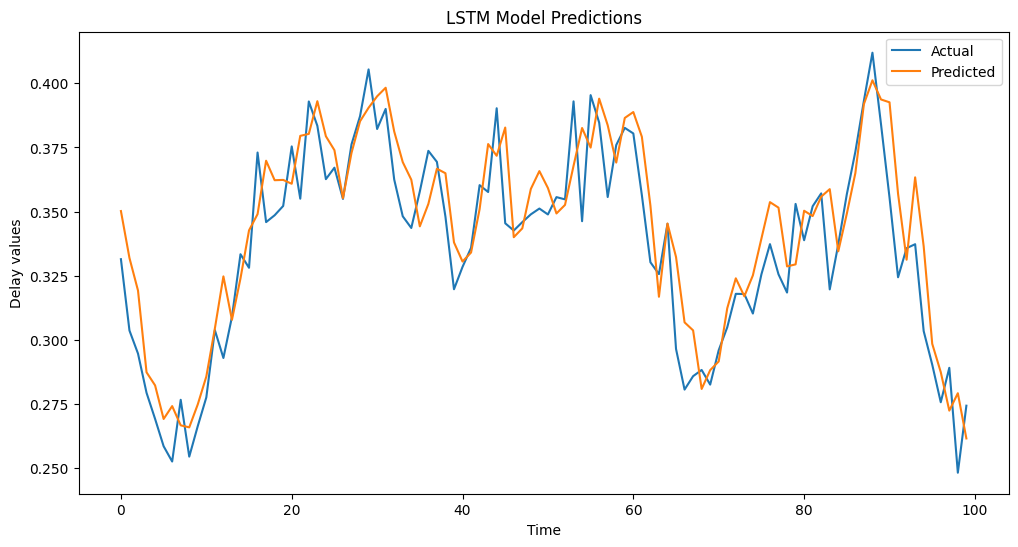

In [ ]:
# Plot actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(testY[:100], label='Actual')
plt.plot(testPredict[:100], label='Predicted')

plt.xlabel('Time')
plt.ylabel('Delay values')
plt.title('LSTM Model Predictions')
plt.legend()
plt.show()

### GRU Model

In [ ]:
# Hyper Parameters tuning

node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
valid_size = int(len(train) * 0.1)
temp_train = train[:-valid_size]
valid = train[-valid_size:]
print(len(train), len(temp_train), len(valid), len(test))

def objective(trial):
    # define search space for hyperparameters
    look_back = trial.suggest_int('look_back', 5, 300)
    num_hidden_layers = trial.suggest_int('num_hidden_layers', 1, 10)

    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    batch_size = trial.suggest_int('batch_size', 5, 200)
    epochs = trial.suggest_int('epochs', 10, 100)

    # reshape into X=t and Y=t+1
    trainX, trainY = create_multistep_dataset(temp_train, look_back, 1)
    validX, validY = create_multistep_dataset(valid, look_back, 1)

    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    validX = np.reshape(validX, (validX.shape[0], 1, validX.shape[1]))
    print(trainX.shape)

    # Crée et entraîne le modèle pour l'horizon de prévision i
    model = Sequential()
    for i in range(num_hidden_layers):
        num_units = trial.suggest_int(f'gru_units_layer_{i}', 8, 256, log=True)
        return_sequences = (i < num_hidden_layers - 1)
        model.add(GRU(units=num_units, return_sequences=return_sequences))
    model.add(Dense(1))
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=0)
    validPredict = model.predict(validX, verbose=0)

    # calculate root mean squared error
    validScore = np.sqrt(mean_squared_error(validY, validPredict))

    return validScore

study = optuna.create_study(direction='minimize', sampler=TPESampler())

# Record the starting time to generate predictions
start_time = time.time()

study.optimize(objective, n_trials=100, n_jobs=-1)

# Record the ending time
end_time = time.time()
elapsed_time = end_time - start_time

print('done')
print("RNN HyperParameters Tuning Elapsed Time : %.5f" % (elapsed_time), "seconds")

best_params = study.best_params
best_error = study.best_value

print("Done")
print(f"best_params: {best_params}, best_error: {best_error}")

[I 2023-08-27 16:22:18,715] A new study created in memory with name: no-name-8776815e-f971-4516-ba82-38d0864089a6


Window Size:  10
17991 16192 1799 2000
(16072, 1, 120)
(16039, 1, 153)


<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
[I 2023-08-27 16:25:58,626] Trial 0 finished with value: 0.030842096355321053 and parameters: {'look_back': 153, 'num_hidden_layers': 9, 'learning_rate': 3.079384551884099e-05, 'batch_size': 176, 'epochs': 73, 'gru_units_layer_0': 8, 'gru_units_layer_1': 8, 'gru_units_layer_2': 25, 'gru_units_layer_3': 85, 'gru_units_layer_4': 10, 'gru_units_layer_5': 93, 'gru_units_layer_6': 11, 'gru_units_layer_7': 212, 'gru_units_layer_8': 20}. Best is trial 0 with value: 0.030842096355321053.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use s

(16009, 1, 183)


[I 2023-08-27 16:26:31,578] Trial 2 finished with value: 0.04923098917953865 and parameters: {'look_back': 183, 'num_hidden_layers': 1, 'learning_rate': 0.028071398668219748, 'batch_size': 72, 'epochs': 53, 'gru_units_layer_0': 8}. Best is trial 0 with value: 0.030842096355321053.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16120, 1, 72)


[I 2023-08-27 16:45:23,610] Trial 1 finished with value: 0.01728291540669583 and parameters: {'look_back': 120, 'num_hidden_layers': 7, 'learning_rate': 5.838593861643845e-05, 'batch_size': 22, 'epochs': 97, 'gru_units_layer_0': 50, 'gru_units_layer_1': 194, 'gru_units_layer_2': 113, 'gru_units_layer_3': 169, 'gru_units_layer_4': 24, 'gru_units_layer_5': 10, 'gru_units_layer_6': 37}. Best is trial 1 with value: 0.01728291540669583.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(15983, 1, 209)


[I 2023-08-27 16:47:10,472] Trial 3 finished with value: 0.049395932769513075 and parameters: {'look_back': 72, 'num_hidden_layers': 6, 'learning_rate': 0.08363737820097521, 'batch_size': 17, 'epochs': 85, 'gru_units_layer_0': 194, 'gru_units_layer_1': 13, 'gru_units_layer_2': 12, 'gru_units_layer_3': 221, 'gru_units_layer_4': 35, 'gru_units_layer_5': 25}. Best is trial 1 with value: 0.01728291540669583.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(15991, 1, 201)


[I 2023-08-27 16:49:15,014] Trial 5 finished with value: 0.01993393978314631 and parameters: {'look_back': 201, 'num_hidden_layers': 3, 'learning_rate': 0.00026678439914114554, 'batch_size': 39, 'epochs': 32, 'gru_units_layer_0': 70, 'gru_units_layer_1': 114, 'gru_units_layer_2': 19}. Best is trial 1 with value: 0.01728291540669583.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16034, 1, 158)


[I 2023-08-27 16:51:27,456] Trial 6 finished with value: 0.019378226309552986 and parameters: {'look_back': 158, 'num_hidden_layers': 7, 'learning_rate': 0.0032258103666254895, 'batch_size': 80, 'epochs': 22, 'gru_units_layer_0': 57, 'gru_units_layer_1': 172, 'gru_units_layer_2': 50, 'gru_units_layer_3': 9, 'gru_units_layer_4': 201, 'gru_units_layer_5': 18, 'gru_units_layer_6': 24}. Best is trial 1 with value: 0.01728291540669583.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16021, 1, 171)


[I 2023-08-27 17:02:30,321] Trial 7 finished with value: 0.04965629215219621 and parameters: {'look_back': 171, 'num_hidden_layers': 8, 'learning_rate': 0.07055499941996761, 'batch_size': 56, 'epochs': 83, 'gru_units_layer_0': 9, 'gru_units_layer_1': 256, 'gru_units_layer_2': 63, 'gru_units_layer_3': 65, 'gru_units_layer_4': 202, 'gru_units_layer_5': 12, 'gru_units_layer_6': 15, 'gru_units_layer_7': 19}. Best is trial 1 with value: 0.01728291540669583.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16173, 1, 19)


[I 2023-08-27 17:05:58,122] Trial 4 finished with value: 0.058089807667496426 and parameters: {'look_back': 209, 'num_hidden_layers': 9, 'learning_rate': 0.06250073636087307, 'batch_size': 21, 'epochs': 65, 'gru_units_layer_0': 107, 'gru_units_layer_1': 14, 'gru_units_layer_2': 111, 'gru_units_layer_3': 14, 'gru_units_layer_4': 104, 'gru_units_layer_5': 141, 'gru_units_layer_6': 228, 'gru_units_layer_7': 32, 'gru_units_layer_8': 13}. Best is trial 1 with value: 0.01728291540669583.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(15995, 1, 197)


[I 2023-08-27 17:08:21,378] Trial 8 finished with value: 0.01952236778869238 and parameters: {'look_back': 19, 'num_hidden_layers': 9, 'learning_rate': 0.0003225139730558904, 'batch_size': 114, 'epochs': 59, 'gru_units_layer_0': 48, 'gru_units_layer_1': 127, 'gru_units_layer_2': 57, 'gru_units_layer_3': 88, 'gru_units_layer_4': 12, 'gru_units_layer_5': 16, 'gru_units_layer_6': 48, 'gru_units_layer_7': 157, 'gru_units_layer_8': 35}. Best is trial 1 with value: 0.01728291540669583.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16024, 1, 168)


[I 2023-08-27 17:10:34,694] Trial 9 finished with value: 0.019223149539369915 and parameters: {'look_back': 197, 'num_hidden_layers': 10, 'learning_rate': 0.0013905297963983947, 'batch_size': 118, 'epochs': 42, 'gru_units_layer_0': 31, 'gru_units_layer_1': 27, 'gru_units_layer_2': 15, 'gru_units_layer_3': 26, 'gru_units_layer_4': 103, 'gru_units_layer_5': 254, 'gru_units_layer_6': 117, 'gru_units_layer_7': 256, 'gru_units_layer_8': 16, 'gru_units_layer_9': 157}. Best is trial 1 with value: 0.01728291540669583.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(15894, 1, 298)


[I 2023-08-27 17:11:46,983] Trial 10 finished with value: 0.049706430836060876 and parameters: {'look_back': 168, 'num_hidden_layers': 9, 'learning_rate': 0.0069233683924450435, 'batch_size': 56, 'epochs': 18, 'gru_units_layer_0': 104, 'gru_units_layer_1': 9, 'gru_units_layer_2': 64, 'gru_units_layer_3': 65, 'gru_units_layer_4': 24, 'gru_units_layer_5': 158, 'gru_units_layer_6': 194, 'gru_units_layer_7': 96, 'gru_units_layer_8': 42}. Best is trial 1 with value: 0.01728291540669583.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(15900, 1, 292)


[I 2023-08-27 17:15:46,512] Trial 11 finished with value: 0.028414177860933167 and parameters: {'look_back': 298, 'num_hidden_layers': 4, 'learning_rate': 1.781319007066041e-05, 'batch_size': 157, 'epochs': 97, 'gru_units_layer_0': 24, 'gru_units_layer_1': 66, 'gru_units_layer_2': 248, 'gru_units_layer_3': 227}. Best is trial 1 with value: 0.01728291540669583.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16103, 1, 89)


[I 2023-08-27 17:15:52,553] Trial 12 finished with value: 0.023860256876609896 and parameters: {'look_back': 292, 'num_hidden_layers': 4, 'learning_rate': 2.8962321804551155e-05, 'batch_size': 128, 'epochs': 97, 'gru_units_layer_0': 25, 'gru_units_layer_1': 44, 'gru_units_layer_2': 251, 'gru_units_layer_3': 26}. Best is trial 1 with value: 0.01728291540669583.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16086, 1, 106)


[I 2023-08-27 17:19:52,225] Trial 14 finished with value: 0.020832213687354863 and parameters: {'look_back': 106, 'num_hidden_layers': 10, 'learning_rate': 0.0008810544575781382, 'batch_size': 129, 'epochs': 42, 'gru_units_layer_0': 30, 'gru_units_layer_1': 26, 'gru_units_layer_2': 8, 'gru_units_layer_3': 31, 'gru_units_layer_4': 52, 'gru_units_layer_5': 51, 'gru_units_layer_6': 72, 'gru_units_layer_7': 9, 'gru_units_layer_8': 215, 'gru_units_layer_9': 160}. Best is trial 1 with value: 0.01728291540669583.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(15941, 1, 251)


[I 2023-08-27 17:20:51,008] Trial 13 finished with value: 0.02064830972017953 and parameters: {'look_back': 89, 'num_hidden_layers': 10, 'learning_rate': 0.00011801650841345395, 'batch_size': 119, 'epochs': 42, 'gru_units_layer_0': 23, 'gru_units_layer_1': 36, 'gru_units_layer_2': 9, 'gru_units_layer_3': 26, 'gru_units_layer_4': 77, 'gru_units_layer_5': 8, 'gru_units_layer_6': 67, 'gru_units_layer_7': 8, 'gru_units_layer_8': 141, 'gru_units_layer_9': 171}. Best is trial 1 with value: 0.01728291540669583.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(15964, 1, 228)


[I 2023-08-27 17:22:01,565] Trial 15 finished with value: 0.02248742243631665 and parameters: {'look_back': 251, 'num_hidden_layers': 7, 'learning_rate': 8.239491896786097e-05, 'batch_size': 95, 'epochs': 43, 'gru_units_layer_0': 34, 'gru_units_layer_1': 66, 'gru_units_layer_2': 25, 'gru_units_layer_3': 22, 'gru_units_layer_4': 72, 'gru_units_layer_5': 8, 'gru_units_layer_6': 76}. Best is trial 1 with value: 0.01728291540669583.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16074, 1, 118)


[I 2023-08-27 17:22:59,529] Trial 17 finished with value: 0.04880002327055632 and parameters: {'look_back': 118, 'num_hidden_layers': 6, 'learning_rate': 1.0235469143558809e-05, 'batch_size': 151, 'epochs': 11, 'gru_units_layer_0': 15, 'gru_units_layer_1': 23, 'gru_units_layer_2': 111, 'gru_units_layer_3': 141, 'gru_units_layer_4': 23, 'gru_units_layer_5': 224}. Best is trial 1 with value: 0.01728291540669583.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16143, 1, 49)


[I 2023-08-27 17:24:56,421] Trial 16 finished with value: 0.021936647440601063 and parameters: {'look_back': 228, 'num_hidden_layers': 7, 'learning_rate': 9.279843442844964e-05, 'batch_size': 96, 'epochs': 46, 'gru_units_layer_0': 38, 'gru_units_layer_1': 86, 'gru_units_layer_2': 33, 'gru_units_layer_3': 152, 'gru_units_layer_4': 18, 'gru_units_layer_5': 228, 'gru_units_layer_6': 112}. Best is trial 1 with value: 0.01728291540669583.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16148, 1, 44)


[I 2023-08-27 17:26:01,465] Trial 18 finished with value: 0.01734937968733014 and parameters: {'look_back': 49, 'num_hidden_layers': 7, 'learning_rate': 0.0009853227523509102, 'batch_size': 188, 'epochs': 72, 'gru_units_layer_0': 41, 'gru_units_layer_1': 73, 'gru_units_layer_2': 32, 'gru_units_layer_3': 43, 'gru_units_layer_4': 113, 'gru_units_layer_5': 39, 'gru_units_layer_6': 36}. Best is trial 1 with value: 0.01728291540669583.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16156, 1, 36)


[I 2023-08-27 17:26:14,289] Trial 19 finished with value: 0.01869585718544571 and parameters: {'look_back': 44, 'num_hidden_layers': 5, 'learning_rate': 0.001033430552608695, 'batch_size': 198, 'epochs': 30, 'gru_units_layer_0': 16, 'gru_units_layer_1': 209, 'gru_units_layer_2': 13, 'gru_units_layer_3': 53, 'gru_units_layer_4': 40}. Best is trial 1 with value: 0.01728291540669583.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16139, 1, 53)


[I 2023-08-27 17:29:19,503] Trial 21 finished with value: 0.017165289197147732 and parameters: {'look_back': 53, 'num_hidden_layers': 5, 'learning_rate': 0.000334321649016538, 'batch_size': 197, 'epochs': 85, 'gru_units_layer_0': 66, 'gru_units_layer_1': 155, 'gru_units_layer_2': 36, 'gru_units_layer_3': 38, 'gru_units_layer_4': 17}. Best is trial 21 with value: 0.017165289197147732.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16185, 1, 7)


[I 2023-08-27 17:30:43,001] Trial 20 finished with value: 0.017507668448547134 and parameters: {'look_back': 36, 'num_hidden_layers': 5, 'learning_rate': 0.0004112650471578427, 'batch_size': 194, 'epochs': 84, 'gru_units_layer_0': 76, 'gru_units_layer_1': 256, 'gru_units_layer_2': 37, 'gru_units_layer_3': 42, 'gru_units_layer_4': 38}. Best is trial 21 with value: 0.017165289197147732.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16125, 1, 67)


[I 2023-08-27 17:31:43,522] Trial 22 finished with value: 0.021938521356285146 and parameters: {'look_back': 7, 'num_hidden_layers': 5, 'learning_rate': 0.0004299458341623761, 'batch_size': 197, 'epochs': 85, 'gru_units_layer_0': 65, 'gru_units_layer_1': 153, 'gru_units_layer_2': 37, 'gru_units_layer_3': 40, 'gru_units_layer_4': 8}. Best is trial 21 with value: 0.017165289197147732.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16130, 1, 62)


[I 2023-08-27 17:32:42,994] Trial 23 finished with value: 0.0186771824905139 and parameters: {'look_back': 67, 'num_hidden_layers': 3, 'learning_rate': 0.00020795492533900236, 'batch_size': 178, 'epochs': 73, 'gru_units_layer_0': 43, 'gru_units_layer_1': 154, 'gru_units_layer_2': 35}. Best is trial 21 with value: 0.017165289197147732.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16066, 1, 126)


[I 2023-08-27 17:33:33,085] Trial 24 finished with value: 0.018387388933924446 and parameters: {'look_back': 62, 'num_hidden_layers': 3, 'learning_rate': 0.0001540609154814164, 'batch_size': 176, 'epochs': 74, 'gru_units_layer_0': 47, 'gru_units_layer_1': 106, 'gru_units_layer_2': 22}. Best is trial 21 with value: 0.017165289197147732.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16090, 1, 102)


[I 2023-08-27 17:37:45,631] Trial 25 finished with value: 0.020517570236623643 and parameters: {'look_back': 126, 'num_hidden_layers': 8, 'learning_rate': 5.5162692034957894e-05, 'batch_size': 149, 'epochs': 100, 'gru_units_layer_0': 47, 'gru_units_layer_1': 112, 'gru_units_layer_2': 24, 'gru_units_layer_3': 43, 'gru_units_layer_4': 15, 'gru_units_layer_5': 41, 'gru_units_layer_6': 27, 'gru_units_layer_7': 69}. Best is trial 21 with value: 0.017165289197147732.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16094, 1, 98)


[I 2023-08-27 17:39:10,503] Trial 26 finished with value: 0.01757650157543611 and parameters: {'look_back': 102, 'num_hidden_layers': 8, 'learning_rate': 0.0006141991291819537, 'batch_size': 149, 'epochs': 92, 'gru_units_layer_0': 93, 'gru_units_layer_1': 185, 'gru_units_layer_2': 83, 'gru_units_layer_3': 41, 'gru_units_layer_4': 15, 'gru_units_layer_5': 39, 'gru_units_layer_6': 30, 'gru_units_layer_7': 68}. Best is trial 21 with value: 0.017165289197147732.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16059, 1, 133)


[I 2023-08-27 17:42:10,988] Trial 27 finished with value: 0.018793553997265393 and parameters: {'look_back': 98, 'num_hidden_layers': 6, 'learning_rate': 5.4986919684808654e-05, 'batch_size': 168, 'epochs': 92, 'gru_units_layer_0': 88, 'gru_units_layer_1': 194, 'gru_units_layer_2': 88, 'gru_units_layer_3': 94, 'gru_units_layer_4': 26, 'gru_units_layer_5': 30}. Best is trial 21 with value: 0.017165289197147732.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16062, 1, 130)


[I 2023-08-27 17:54:24,018] Trial 29 finished with value: 0.017406815361395208 and parameters: {'look_back': 130, 'num_hidden_layers': 7, 'learning_rate': 0.00018020884121620851, 'batch_size': 32, 'epochs': 78, 'gru_units_layer_0': 61, 'gru_units_layer_1': 80, 'gru_units_layer_2': 48, 'gru_units_layer_3': 57, 'gru_units_layer_4': 19, 'gru_units_layer_5': 82, 'gru_units_layer_6': 40}. Best is trial 21 with value: 0.017165289197147732.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16144, 1, 48)


[I 2023-08-27 18:25:34,677] Trial 30 finished with value: 0.0172887350296898 and parameters: {'look_back': 48, 'num_hidden_layers': 4, 'learning_rate': 0.0016248171930450504, 'batch_size': 6, 'epochs': 67, 'gru_units_layer_0': 136, 'gru_units_layer_1': 139, 'gru_units_layer_2': 32, 'gru_units_layer_3': 18}. Best is trial 21 with value: 0.017165289197147732.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16053, 1, 139)


[I 2023-08-27 18:30:54,083] Trial 28 finished with value: 0.01695853044736942 and parameters: {'look_back': 133, 'num_hidden_layers': 6, 'learning_rate': 0.00018614527363897511, 'batch_size': 6, 'epochs': 78, 'gru_units_layer_0': 61, 'gru_units_layer_1': 81, 'gru_units_layer_2': 43, 'gru_units_layer_3': 107, 'gru_units_layer_4': 26, 'gru_units_layer_5': 23}. Best is trial 28 with value: 0.01695853044736942.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16061, 1, 131)


[I 2023-08-27 18:34:48,623] Trial 31 finished with value: 0.01708262813498712 and parameters: {'look_back': 139, 'num_hidden_layers': 1, 'learning_rate': 0.001822651120209012, 'batch_size': 7, 'epochs': 61, 'gru_units_layer_0': 151}. Best is trial 28 with value: 0.01695853044736942.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16048, 1, 144)


[I 2023-08-27 18:41:20,260] Trial 33 finished with value: 0.017792572845426003 and parameters: {'look_back': 144, 'num_hidden_layers': 1, 'learning_rate': 0.00021496502497398833, 'batch_size': 9, 'epochs': 57, 'gru_units_layer_0': 144}. Best is trial 28 with value: 0.01695853044736942.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16052, 1, 140)


[I 2023-08-27 18:46:38,446] Trial 34 finished with value: 0.01809682146117004 and parameters: {'look_back': 140, 'num_hidden_layers': 2, 'learning_rate': 5.316466241845796e-05, 'batch_size': 35, 'epochs': 91, 'gru_units_layer_0': 81, 'gru_units_layer_1': 95}. Best is trial 28 with value: 0.01695853044736942.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16107, 1, 85)


[I 2023-08-27 18:52:03,787] Trial 35 finished with value: 0.018610506106432254 and parameters: {'look_back': 85, 'num_hidden_layers': 1, 'learning_rate': 0.000530069667936673, 'batch_size': 22, 'epochs': 78, 'gru_units_layer_0': 232}. Best is trial 28 with value: 0.01695853044736942.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16011, 1, 181)


[I 2023-08-27 18:55:06,684] Trial 36 finished with value: 0.01833278650560939 and parameters: {'look_back': 181, 'num_hidden_layers': 2, 'learning_rate': 0.0001242321434082265, 'batch_size': 49, 'epochs': 64, 'gru_units_layer_0': 57, 'gru_units_layer_1': 139}. Best is trial 28 with value: 0.01695853044736942.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16041, 1, 151)


[I 2023-08-27 19:07:42,691] Trial 32 finished with value: 0.0175663207114453 and parameters: {'look_back': 131, 'num_hidden_layers': 4, 'learning_rate': 4.6425349747823656e-05, 'batch_size': 6, 'epochs': 68, 'gru_units_layer_0': 135, 'gru_units_layer_1': 137, 'gru_units_layer_2': 45, 'gru_units_layer_3': 17}. Best is trial 28 with value: 0.01695853044736942.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16035, 1, 157)


[I 2023-08-27 19:10:29,917] Trial 37 finished with value: 0.018607519645804527 and parameters: {'look_back': 151, 'num_hidden_layers': 6, 'learning_rate': 0.00029259805555591613, 'batch_size': 16, 'epochs': 52, 'gru_units_layer_0': 126, 'gru_units_layer_1': 57, 'gru_units_layer_2': 41, 'gru_units_layer_3': 135, 'gru_units_layer_4': 31, 'gru_units_layer_5': 12}. Best is trial 28 with value: 0.01695853044736942.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16114, 1, 78)


[I 2023-08-27 19:13:20,556] Trial 39 finished with value: 0.01746356777227775 and parameters: {'look_back': 78, 'num_hidden_layers': 2, 'learning_rate': 0.004418384904516037, 'batch_size': 71, 'epochs': 88, 'gru_units_layer_0': 74, 'gru_units_layer_1': 95}. Best is trial 28 with value: 0.01695853044736942.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16029, 1, 163)


[I 2023-08-27 19:14:37,872] Trial 38 finished with value: 0.01801472507897833 and parameters: {'look_back': 157, 'num_hidden_layers': 6, 'learning_rate': 0.00025700125245026715, 'batch_size': 76, 'epochs': 88, 'gru_units_layer_0': 71, 'gru_units_layer_1': 102, 'gru_units_layer_2': 27, 'gru_units_layer_3': 134, 'gru_units_layer_4': 29, 'gru_units_layer_5': 11}. Best is trial 28 with value: 0.01695853044736942.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16081, 1, 111)


[I 2023-08-27 19:29:09,168] Trial 41 finished with value: 0.023797912259791953 and parameters: {'look_back': 111, 'num_hidden_layers': 8, 'learning_rate': 0.0019866386024343092, 'batch_size': 24, 'epochs': 53, 'gru_units_layer_0': 172, 'gru_units_layer_1': 209, 'gru_units_layer_2': 19, 'gru_units_layer_3': 111, 'gru_units_layer_4': 21, 'gru_units_layer_5': 22, 'gru_units_layer_6': 8, 'gru_units_layer_7': 27}. Best is trial 28 with value: 0.01695853044736942.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16169, 1, 23)


[I 2023-08-27 19:33:06,959] Trial 40 finished with value: 0.017611763611603794 and parameters: {'look_back': 163, 'num_hidden_layers': 8, 'learning_rate': 0.0002885449273750338, 'batch_size': 25, 'epochs': 78, 'gru_units_layer_0': 158, 'gru_units_layer_1': 113, 'gru_units_layer_2': 27, 'gru_units_layer_3': 99, 'gru_units_layer_4': 28, 'gru_units_layer_5': 22, 'gru_units_layer_6': 8, 'gru_units_layer_7': 34}. Best is trial 28 with value: 0.01695853044736942.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16168, 1, 24)


[I 2023-08-27 19:40:24,896] Trial 43 finished with value: 0.01756817600348257 and parameters: {'look_back': 24, 'num_hidden_layers': 5, 'learning_rate': 0.0016308073888391338, 'batch_size': 44, 'epochs': 64, 'gru_units_layer_0': 114, 'gru_units_layer_1': 128, 'gru_units_layer_2': 44, 'gru_units_layer_3': 174, 'gru_units_layer_4': 15}. Best is trial 28 with value: 0.01695853044736942.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16132, 1, 60)


[I 2023-08-27 20:10:14,249] Trial 44 finished with value: 0.01851624198802556 and parameters: {'look_back': 60, 'num_hidden_layers': 4, 'learning_rate': 0.0006840025188223656, 'batch_size': 8, 'epochs': 60, 'gru_units_layer_0': 101, 'gru_units_layer_1': 162, 'gru_units_layer_2': 55, 'gru_units_layer_3': 203}. Best is trial 28 with value: 0.01695853044736942.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16161, 1, 31)


[I 2023-08-27 20:18:49,734] Trial 45 finished with value: 0.0174197795932413 and parameters: {'look_back': 31, 'num_hidden_layers': 6, 'learning_rate': 0.002378866291103003, 'batch_size': 60, 'epochs': 80, 'gru_units_layer_0': 118, 'gru_units_layer_1': 174, 'gru_units_layer_2': 31, 'gru_units_layer_3': 184, 'gru_units_layer_4': 11, 'gru_units_layer_5': 15}. Best is trial 28 with value: 0.01695853044736942.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16003, 1, 189)


[I 2023-08-27 20:18:53,702] Trial 42 finished with value: 0.017545155390714405 and parameters: {'look_back': 23, 'num_hidden_layers': 5, 'learning_rate': 0.0006313522888619264, 'batch_size': 5, 'epochs': 62, 'gru_units_layer_0': 107, 'gru_units_layer_1': 129, 'gru_units_layer_2': 30, 'gru_units_layer_3': 182, 'gru_units_layer_4': 13}. Best is trial 28 with value: 0.01695853044736942.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(15997, 1, 195)


[I 2023-08-27 20:30:18,000] Trial 47 finished with value: 0.022021280372331743 and parameters: {'look_back': 195, 'num_hidden_layers': 3, 'learning_rate': 0.0077202208100181705, 'batch_size': 17, 'epochs': 68, 'gru_units_layer_0': 189, 'gru_units_layer_1': 118, 'gru_units_layer_2': 67}. Best is trial 28 with value: 0.01695853044736942.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16103, 1, 89)


[I 2023-08-27 20:33:21,551] Trial 46 finished with value: 0.023289196172460856 and parameters: {'look_back': 189, 'num_hidden_layers': 3, 'learning_rate': 0.007744712874260051, 'batch_size': 13, 'epochs': 69, 'gru_units_layer_0': 182, 'gru_units_layer_1': 130, 'gru_units_layer_2': 54}. Best is trial 28 with value: 0.01695853044736942.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16099, 1, 93)


[I 2023-08-27 20:39:35,284] Trial 48 finished with value: 0.016874697411916148 and parameters: {'look_back': 89, 'num_hidden_layers': 4, 'learning_rate': 0.0012643558866113692, 'batch_size': 28, 'epochs': 69, 'gru_units_layer_0': 54, 'gru_units_layer_1': 155, 'gru_units_layer_2': 18, 'gru_units_layer_3': 79}. Best is trial 48 with value: 0.016874697411916148.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16099, 1, 93)


[I 2023-08-27 20:49:59,149] Trial 49 finished with value: 0.01786377581079982 and parameters: {'look_back': 93, 'num_hidden_layers': 7, 'learning_rate': 0.000393824110902746, 'batch_size': 32, 'epochs': 95, 'gru_units_layer_0': 53, 'gru_units_layer_1': 229, 'gru_units_layer_2': 19, 'gru_units_layer_3': 76, 'gru_units_layer_4': 19, 'gru_units_layer_5': 29, 'gru_units_layer_6': 18}. Best is trial 48 with value: 0.016874697411916148.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16070, 1, 122)


[I 2023-08-27 20:55:59,952] Trial 51 finished with value: 0.020430794572471475 and parameters: {'look_back': 122, 'num_hidden_layers': 6, 'learning_rate': 0.0012290855953446622, 'batch_size': 41, 'epochs': 48, 'gru_units_layer_0': 53, 'gru_units_layer_1': 178, 'gru_units_layer_2': 16, 'gru_units_layer_3': 78, 'gru_units_layer_4': 34, 'gru_units_layer_5': 10}. Best is trial 48 with value: 0.016874697411916148.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16120, 1, 72)


[I 2023-08-27 20:58:47,131] Trial 50 finished with value: 0.017045369543177296 and parameters: {'look_back': 93, 'num_hidden_layers': 7, 'learning_rate': 0.0009893466636436215, 'batch_size': 30, 'epochs': 100, 'gru_units_layer_0': 53, 'gru_units_layer_1': 234, 'gru_units_layer_2': 17, 'gru_units_layer_3': 77, 'gru_units_layer_4': 9, 'gru_units_layer_5': 29, 'gru_units_layer_6': 19}. Best is trial 48 with value: 0.016874697411916148.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16116, 1, 76)


[I 2023-08-27 21:04:25,399] Trial 52 finished with value: 0.01680559547600899 and parameters: {'look_back': 72, 'num_hidden_layers': 4, 'learning_rate': 0.0008799876884238543, 'batch_size': 26, 'epochs': 75, 'gru_units_layer_0': 63, 'gru_units_layer_1': 153, 'gru_units_layer_2': 41, 'gru_units_layer_3': 106}. Best is trial 52 with value: 0.01680559547600899.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16119, 1, 73)


[I 2023-08-27 21:14:29,237] Trial 54 finished with value: 0.01722572830633861 and parameters: {'look_back': 73, 'num_hidden_layers': 4, 'learning_rate': 0.0009867546312023168, 'batch_size': 30, 'epochs': 75, 'gru_units_layer_0': 66, 'gru_units_layer_1': 220, 'gru_units_layer_2': 11, 'gru_units_layer_3': 112}. Best is trial 52 with value: 0.01680559547600899.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16082, 1, 110)


[I 2023-08-27 21:19:46,109] Trial 53 finished with value: 0.016768421659257234 and parameters: {'look_back': 76, 'num_hidden_layers': 7, 'learning_rate': 0.0007981184140959627, 'batch_size': 28, 'epochs': 100, 'gru_units_layer_0': 62, 'gru_units_layer_1': 234, 'gru_units_layer_2': 11, 'gru_units_layer_3': 111, 'gru_units_layer_4': 9, 'gru_units_layer_5': 19, 'gru_units_layer_6': 21}. Best is trial 53 with value: 0.016768421659257234.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16078, 1, 114)


[I 2023-08-27 21:21:23,317] Trial 55 finished with value: 0.017586177446439713 and parameters: {'look_back': 110, 'num_hidden_layers': 5, 'learning_rate': 0.0007342446611959767, 'batch_size': 50, 'epochs': 71, 'gru_units_layer_0': 56, 'gru_units_layer_1': 254, 'gru_units_layer_2': 21, 'gru_units_layer_3': 73, 'gru_units_layer_4': 9}. Best is trial 53 with value: 0.016768421659257234.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16112, 1, 80)


[I 2023-08-27 21:31:08,715] Trial 57 finished with value: 0.01692430944871399 and parameters: {'look_back': 80, 'num_hidden_layers': 7, 'learning_rate': 0.0013098971443580335, 'batch_size': 62, 'epochs': 99, 'gru_units_layer_0': 85, 'gru_units_layer_1': 194, 'gru_units_layer_2': 16, 'gru_units_layer_3': 90, 'gru_units_layer_4': 10, 'gru_units_layer_5': 18, 'gru_units_layer_6': 19}. Best is trial 53 with value: 0.016768421659257234.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16110, 1, 82)


[I 2023-08-27 21:31:32,814] Trial 56 finished with value: 0.019379265128970043 and parameters: {'look_back': 114, 'num_hidden_layers': 7, 'learning_rate': 0.0008394412690334844, 'batch_size': 53, 'epochs': 100, 'gru_units_layer_0': 84, 'gru_units_layer_1': 236, 'gru_units_layer_2': 14, 'gru_units_layer_3': 77, 'gru_units_layer_4': 9, 'gru_units_layer_5': 19, 'gru_units_layer_6': 19}. Best is trial 53 with value: 0.016768421659257234.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16107, 1, 85)


[I 2023-08-27 21:40:18,530] Trial 58 finished with value: 0.0172017204866571 and parameters: {'look_back': 82, 'num_hidden_layers': 7, 'learning_rate': 0.003012987045071155, 'batch_size': 67, 'epochs': 98, 'gru_units_layer_0': 82, 'gru_units_layer_1': 192, 'gru_units_layer_2': 15, 'gru_units_layer_3': 88, 'gru_units_layer_4': 10, 'gru_units_layer_5': 18, 'gru_units_layer_6': 19}. Best is trial 53 with value: 0.016768421659257234.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16100, 1, 92)


[I 2023-08-27 21:41:21,738] Trial 59 finished with value: 0.016902219189561918 and parameters: {'look_back': 85, 'num_hidden_layers': 7, 'learning_rate': 0.0012619459481826101, 'batch_size': 69, 'epochs': 96, 'gru_units_layer_0': 60, 'gru_units_layer_1': 199, 'gru_units_layer_2': 16, 'gru_units_layer_3': 104, 'gru_units_layer_4': 10, 'gru_units_layer_5': 29, 'gru_units_layer_6': 14}. Best is trial 53 with value: 0.016768421659257234.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16117, 1, 75)


[I 2023-08-27 21:48:26,309] Trial 60 finished with value: 0.017098739883252664 and parameters: {'look_back': 92, 'num_hidden_layers': 9, 'learning_rate': 0.000454032246461207, 'batch_size': 86, 'epochs': 95, 'gru_units_layer_0': 61, 'gru_units_layer_1': 215, 'gru_units_layer_2': 17, 'gru_units_layer_3': 116, 'gru_units_layer_4': 8, 'gru_units_layer_5': 14, 'gru_units_layer_6': 13, 'gru_units_layer_7': 16, 'gru_units_layer_8': 92}. Best is trial 53 with value: 0.016768421659257234.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16123, 1, 69)


[I 2023-08-27 21:49:38,933] Trial 61 finished with value: 0.019156573441647114 and parameters: {'look_back': 75, 'num_hidden_layers': 9, 'learning_rate': 0.0005108256909259262, 'batch_size': 85, 'epochs': 95, 'gru_units_layer_0': 62, 'gru_units_layer_1': 200, 'gru_units_layer_2': 12, 'gru_units_layer_3': 115, 'gru_units_layer_4': 12, 'gru_units_layer_5': 23, 'gru_units_layer_6': 12, 'gru_units_layer_7': 16, 'gru_units_layer_8': 8}. Best is trial 53 with value: 0.016768421659257234.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16089, 1, 103)


[I 2023-08-27 21:57:59,025] Trial 63 finished with value: 0.01734890490750969 and parameters: {'look_back': 103, 'num_hidden_layers': 7, 'learning_rate': 0.0012217973777151692, 'batch_size': 63, 'epochs': 89, 'gru_units_layer_0': 46, 'gru_units_layer_1': 175, 'gru_units_layer_2': 10, 'gru_units_layer_3': 87, 'gru_units_layer_4': 10, 'gru_units_layer_5': 28, 'gru_units_layer_6': 22}. Best is trial 53 with value: 0.016768421659257234.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16133, 1, 59)


[I 2023-08-27 21:59:09,704] Trial 62 finished with value: 0.02021025637387981 and parameters: {'look_back': 69, 'num_hidden_layers': 7, 'learning_rate': 0.0014864473586143668, 'batch_size': 43, 'epochs': 89, 'gru_units_layer_0': 48, 'gru_units_layer_1': 164, 'gru_units_layer_2': 11, 'gru_units_layer_3': 100, 'gru_units_layer_4': 12, 'gru_units_layer_5': 27, 'gru_units_layer_6': 23}. Best is trial 53 with value: 0.016768421659257234.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16132, 1, 60)


[I 2023-08-27 22:11:20,751] Trial 64 finished with value: 0.017116699555395676 and parameters: {'look_back': 59, 'num_hidden_layers': 8, 'learning_rate': 0.001207901294401701, 'batch_size': 40, 'epochs': 81, 'gru_units_layer_0': 72, 'gru_units_layer_1': 253, 'gru_units_layer_2': 13, 'gru_units_layer_3': 102, 'gru_units_layer_4': 12, 'gru_units_layer_5': 25, 'gru_units_layer_6': 15, 'gru_units_layer_7': 48}. Best is trial 53 with value: 0.016768421659257234.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16153, 1, 39)


[I 2023-08-27 22:13:26,085] Trial 65 finished with value: 0.023251125352711573 and parameters: {'look_back': 60, 'num_hidden_layers': 8, 'learning_rate': 0.0008771661075573302, 'batch_size': 38, 'epochs': 97, 'gru_units_layer_0': 40, 'gru_units_layer_1': 232, 'gru_units_layer_2': 14, 'gru_units_layer_3': 66, 'gru_units_layer_4': 8, 'gru_units_layer_5': 19, 'gru_units_layer_6': 16, 'gru_units_layer_7': 52}. Best is trial 53 with value: 0.016768421659257234.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16106, 1, 86)


[I 2023-08-27 22:17:11,641] Trial 66 finished with value: 0.01723990567923187 and parameters: {'look_back': 39, 'num_hidden_layers': 6, 'learning_rate': 0.0008251909545300644, 'batch_size': 107, 'epochs': 100, 'gru_units_layer_0': 51, 'gru_units_layer_1': 193, 'gru_units_layer_2': 17, 'gru_units_layer_3': 66, 'gru_units_layer_4': 8, 'gru_units_layer_5': 19}. Best is trial 53 with value: 0.016768421659257234.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16100, 1, 92)


[I 2023-08-27 22:30:27,962] Trial 67 finished with value: 0.016871581481235753 and parameters: {'look_back': 86, 'num_hidden_layers': 6, 'learning_rate': 0.0007474834437074868, 'batch_size': 27, 'epochs': 100, 'gru_units_layer_0': 54, 'gru_units_layer_1': 150, 'gru_units_layer_2': 16, 'gru_units_layer_3': 126, 'gru_units_layer_4': 10, 'gru_units_layer_5': 15}. Best is trial 53 with value: 0.016768421659257234.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16108, 1, 84)


[I 2023-08-27 22:38:57,073] Trial 68 finished with value: 0.018897099422414753 and parameters: {'look_back': 92, 'num_hidden_layers': 6, 'learning_rate': 0.0024612362415502116, 'batch_size': 18, 'epochs': 94, 'gru_units_layer_0': 90, 'gru_units_layer_1': 148, 'gru_units_layer_2': 8, 'gru_units_layer_3': 149, 'gru_units_layer_4': 10, 'gru_units_layer_5': 35}. Best is trial 53 with value: 0.016768421659257234.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16113, 1, 79)


[I 2023-08-27 22:52:36,932] Trial 69 finished with value: 0.01670065560307004 and parameters: {'look_back': 84, 'num_hidden_layers': 6, 'learning_rate': 0.002326805188896039, 'batch_size': 20, 'epochs': 92, 'gru_units_layer_0': 97, 'gru_units_layer_1': 157, 'gru_units_layer_2': 8, 'gru_units_layer_3': 152, 'gru_units_layer_4': 14, 'gru_units_layer_5': 15}. Best is trial 69 with value: 0.01670065560307004.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16109, 1, 83)


[I 2023-08-27 23:04:19,432] Trial 70 finished with value: 0.01733546032404315 and parameters: {'look_back': 79, 'num_hidden_layers': 5, 'learning_rate': 0.0005942603980709984, 'batch_size': 13, 'epochs': 86, 'gru_units_layer_0': 67, 'gru_units_layer_1': 153, 'gru_units_layer_2': 9, 'gru_units_layer_3': 127, 'gru_units_layer_4': 14}. Best is trial 69 with value: 0.01670065560307004.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16139, 1, 53)


[I 2023-08-27 23:07:15,762] Trial 71 finished with value: 0.017534628346211948 and parameters: {'look_back': 83, 'num_hidden_layers': 5, 'learning_rate': 0.0013741549729779634, 'batch_size': 24, 'epochs': 86, 'gru_units_layer_0': 96, 'gru_units_layer_1': 151, 'gru_units_layer_2': 9, 'gru_units_layer_3': 127, 'gru_units_layer_4': 14}. Best is trial 69 with value: 0.01670065560307004.
<ipython-input-8-812c240dde04>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16140, 1, 52)


In [ ]:
# Best Params
look_back = 84
num_hidden_layers = 6
learning_rate = 0.002326805188896039
batch_size = 20
epochs = 92
gru_units_layer_0 = 97
gru_units_layer_1 = 157
gru_units_layer_2 = 8
gru_units_layer_3 = 152
gru_units_layer_4 = 14
gru_units_layer_5 = 15

node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, 1)
testX, testY = create_multistep_dataset(test, look_back, 1)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape)

# Crée et entraîne le modèle pour l'horizon de prévision i
model = Sequential()
model.add(GRU(units=gru_units_layer_0, return_sequences=True))
model.add(GRU(units=gru_units_layer_1, return_sequences=True))
model.add(GRU(units=gru_units_layer_2, return_sequences=True))
model.add(GRU(units=gru_units_layer_3, return_sequences=True))
model.add(GRU(units=gru_units_layer_4, return_sequences=True))
model.add(GRU(units=gru_units_layer_5))
model.add(Dense(1))
optimizer = keras.optimizers.Adam(lr=learning_rate)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Record the starting time to training the model
training_start_time = time.time()

model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=1)

# Record the ending time of training the model
training_end_time = time.time()
training_elapsed_time = training_end_time - training_start_time


# Record the starting time to generate predictions
predictions_start_time = time.time()

testPredict = model.predict(testX, verbose=0)

# Record the ending time of generating predictions
predictions_end_time = time.time()
predictions_elapsed_time = predictions_end_time - predictions_start_time

# calculate root mean squared error
GRU_RMSE = np.sqrt(mean_squared_error(testY, testPredict))
GRU_MAE = mean_absolute_error(testY, testPredict)

print("GRU Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")
print("GRU Model Generate predictions Elapsed Time : %.5f" % (predictions_elapsed_time), "seconds")
print('GRU Test RMSE : %.5f' % (GRU_RMSE))
print('GRU Test MAE : %.5f' % (GRU_MAE))

Window Size:  10
17991 2000
(17907, 1, 84)
Epoch 1/92


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


896/896 [==============================] - 39s 26ms/step - loss: 0.0019
Epoch 2/92
896/896 [==============================] - 19s 22ms/step - loss: 6.0977e-04
Epoch 3/92
896/896 [==============================] - 13s 14ms/step - loss: 5.5802e-04
Epoch 4/92
896/896 [==============================] - 13s 14ms/step - loss: 5.1749e-04
Epoch 5/92
896/896 [==============================] - 13s 14ms/step - loss: 4.8175e-04
Epoch 6/92
896/896 [==============================] - 13s 14ms/step - loss: 4.5577e-04
Epoch 7/92
896/896 [==============================] - 13s 14ms/step - loss: 4.6463e-04
Epoch 8/92
896/896 [==============================] - 14s 15ms/step - loss: 4.3992e-04
Epoch 9/92
896/896 [==============================] - 13s 14ms/step - loss: 4.2561e-04
Epoch 10/92
896/896 [==============================] - 13s 14ms/step - loss: 4.3600e-04
Epoch 11/92
896/896 [==============================] - 13s 14ms/step - loss: 4.2057e-04
Epoch 12/92
896/896 [==============================] - 1

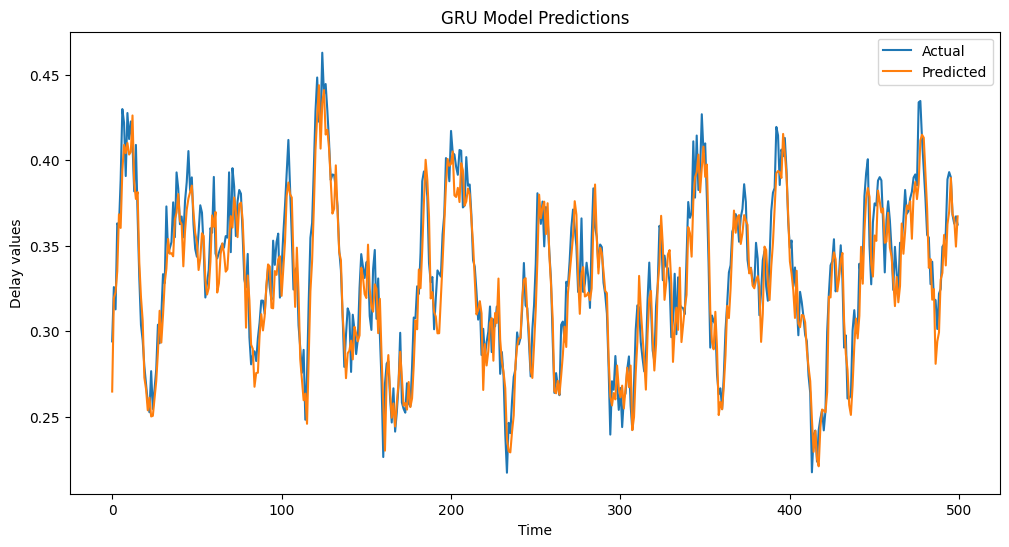

In [ ]:
# Plot actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(testY[:500], label='Actual')
plt.plot(testPredict[:500], label='Predicted')

plt.xlabel('Time')
plt.ylabel('Delay values')
plt.title('GRU Model Predictions')
plt.legend()
plt.show()

In [ ]:
# Best Params
look_back = 84
num_hidden_layers = 6
learning_rate = 0.002326805188896039
batch_size = 20
epochs = 92
gru_units_layer_0 = 97
gru_units_layer_1 = 157
gru_units_layer_2 = 8
gru_units_layer_3 = 152
gru_units_layer_4 = 14
gru_units_layer_5 = 15

node1_delay = df[['node2_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, 1)
testX, testY = create_multistep_dataset(test, look_back, 1)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape)

# Crée et entraîne le modèle pour l'horizon de prévision i
model = Sequential()
model.add(GRU(units=gru_units_layer_0, return_sequences=True))
model.add(GRU(units=gru_units_layer_1, return_sequences=True))
model.add(GRU(units=gru_units_layer_2, return_sequences=True))
model.add(GRU(units=gru_units_layer_3, return_sequences=True))
model.add(GRU(units=gru_units_layer_4, return_sequences=True))
model.add(GRU(units=gru_units_layer_5))
model.add(Dense(1))
optimizer = keras.optimizers.Adam(lr=learning_rate)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Record the starting time to training the model
training_start_time = time.time()

model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=1)

# Record the ending time of training the model
training_end_time = time.time()
training_elapsed_time = training_end_time - training_start_time


# Record the starting time to generate predictions
predictions_start_time = time.time()

testPredict = model.predict(testX, verbose=0)

# Record the ending time of generating predictions
predictions_end_time = time.time()
predictions_elapsed_time = predictions_end_time - predictions_start_time

# calculate root mean squared error
GRU_RMSE = np.sqrt(mean_squared_error(testY, testPredict))
GRU_MAE = mean_absolute_error(testY, testPredict)

print("GRU Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")
print("GRU Model Generate predictions Elapsed Time : %.5f" % (predictions_elapsed_time), "seconds")
print('GRU Test RMSE : %.5f' % (GRU_RMSE))
print('GRU Test MAE : %.5f' % (GRU_MAE))

Window Size:  9
17992 2000
(17908, 1, 84)
Epoch 1/92


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


896/896 [==============================] - 37s 14ms/step - loss: 4.6896e-04
Epoch 2/92
896/896 [==============================] - 13s 14ms/step - loss: 1.3813e-04
Epoch 3/92
896/896 [==============================] - 13s 14ms/step - loss: 1.1502e-04
Epoch 4/92
896/896 [==============================] - 13s 14ms/step - loss: 9.6560e-05
Epoch 5/92
896/896 [==============================] - 13s 14ms/step - loss: 9.3337e-05
Epoch 6/92
896/896 [==============================] - 13s 14ms/step - loss: 8.8575e-05
Epoch 7/92
896/896 [==============================] - 13s 14ms/step - loss: 8.8792e-05
Epoch 8/92
896/896 [==============================] - 14s 15ms/step - loss: 8.0377e-05
Epoch 9/92
896/896 [==============================] - 13s 14ms/step - loss: 8.0961e-05
Epoch 10/92
896/896 [==============================] - 12s 14ms/step - loss: 7.6806e-05
Epoch 11/92
896/896 [==============================] - 12s 14ms/step - loss: 8.1048e-05
Epoch 12/92
896/896 [==============================]

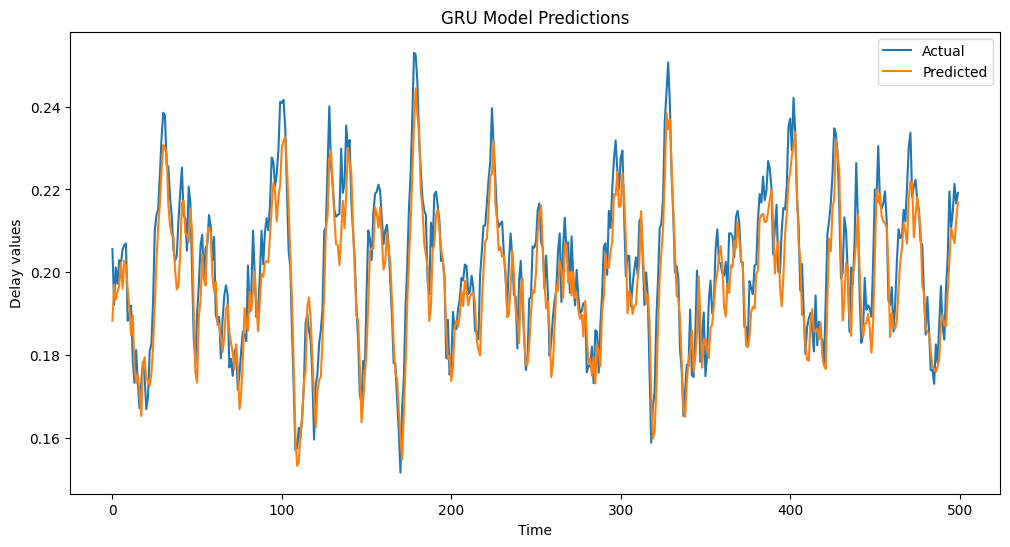

In [ ]:
# Plot actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(testY[:500], label='Actual')
plt.plot(testPredict[:500], label='Predicted')

plt.xlabel('Time')
plt.ylabel('Delay values')
plt.title('GRU Model Predictions')
plt.legend()
plt.show()

### RNN Model

In [ ]:
# Hyper Parameters tuning

node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
valid_size = int(len(train) * 0.1)
temp_train = train[:-valid_size]
valid = train[-valid_size:]
print(len(train), len(temp_train), len(valid), len(test))

def objective(trial):
    # define search space for hyperparameters
    look_back = trial.suggest_int('look_back', 5, 300)
    num_hidden_layers = trial.suggest_int('num_hidden_layers', 1, 10)

    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    batch_size = trial.suggest_int('batch_size', 5, 300)
    epochs = trial.suggest_int('epochs', 10, 100)

    # reshape into X=t and Y=t+1
    trainX, trainY = create_multistep_dataset(temp_train, look_back, 1)
    validX, validY = create_multistep_dataset(valid, look_back, 1)

    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    validX = np.reshape(validX, (validX.shape[0], 1, validX.shape[1]))
    print(trainX.shape)

    # Crée et entraîne le modèle pour l'horizon de prévision i
    model = Sequential()
    for i in range(num_hidden_layers):
        num_units = trial.suggest_int(f'rnn_units_layer_{i}', 8, 256, log=True)
        return_sequences = (i < num_hidden_layers - 1)
        model.add(SimpleRNN(units=num_units, return_sequences=return_sequences))
    model.add(Dense(1))
    optimizer = keras.optimizers.Adam(lr=learning_rate)
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=0)
    validPredict = model.predict(validX, verbose=0)

    # calculate root mean squared error
    validScore = np.sqrt(mean_squared_error(validY, validPredict))

    return validScore

study = optuna.create_study(direction='minimize', sampler=TPESampler())

# Record the starting time to generate predictions
start_time = time.time()

study.optimize(objective, n_trials=100, n_jobs=-1)

# Record the ending time
end_time = time.time()
elapsed_time = end_time - start_time

print('done')
print("RNN HyperParameters Tuning Elapsed Time : %.5f" % (elapsed_time), "seconds")

best_params = study.best_params
best_error = study.best_value

print("Done")
print(f"best_params: {best_params}, best_error: {best_error}")

[I 2023-08-28 05:17:16,716] A new study created in memory with name: no-name-77f351ea-3876-4399-8164-42067d4ea3a4


Window Size:  10
17991 16192 1799 2000
(16064, 1, 128)
(16026, 1, 166)


<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 05:19:36,036] Trial 0 finished with value: 0.191913659772703 and parameters: {'look_back': 128, 'num_hidden_layers': 5, 'learning_rate': 0.06534469791319604, 'batch_size': 95, 'epochs': 68, 'rnn_units_layer_0': 19, 'rnn_units_layer_1': 160, 'rnn_units_layer_2': 8, 'rnn_units_layer_3': 52, 'rnn_units_layer_4': 56}. Best is trial 0 with value: 0.191913659772703.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be r

(16096, 1, 96)


[I 2023-08-28 05:20:53,538] Trial 2 finished with value: 0.021542332692608697 and parameters: {'look_back': 96, 'num_hidden_layers': 10, 'learning_rate': 0.001379945371539756, 'batch_size': 275, 'epochs': 21, 'rnn_units_layer_0': 77, 'rnn_units_layer_1': 9, 'rnn_units_layer_2': 247, 'rnn_units_layer_3': 173, 'rnn_units_layer_4': 45, 'rnn_units_layer_5': 96, 'rnn_units_layer_6': 101, 'rnn_units_layer_7': 189, 'rnn_units_layer_8': 30, 'rnn_units_layer_9': 22}. Best is trial 2 with value: 0.021542332692608697.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(nam

(16157, 1, 35)


[I 2023-08-28 05:21:09,937] Trial 3 finished with value: 0.03181640008205141 and parameters: {'look_back': 35, 'num_hidden_layers': 1, 'learning_rate': 8.04597821033893e-05, 'batch_size': 290, 'epochs': 63, 'rnn_units_layer_0': 10}. Best is trial 2 with value: 0.021542332692608697.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(15925, 1, 267)


[I 2023-08-28 05:23:21,956] Trial 4 finished with value: 0.020060873561030333 and parameters: {'look_back': 267, 'num_hidden_layers': 3, 'learning_rate': 0.0028759814264149495, 'batch_size': 87, 'epochs': 85, 'rnn_units_layer_0': 75, 'rnn_units_layer_1': 10, 'rnn_units_layer_2': 103}. Best is trial 4 with value: 0.020060873561030333.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16083, 1, 109)


[I 2023-08-28 05:24:08,681] Trial 5 finished with value: 0.020161432431564773 and parameters: {'look_back': 109, 'num_hidden_layers': 1, 'learning_rate': 0.033453484738905366, 'batch_size': 130, 'epochs': 72, 'rnn_units_layer_0': 23}. Best is trial 4 with value: 0.020060873561030333.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(15960, 1, 232)


[I 2023-08-28 05:24:32,144] Trial 6 finished with value: 0.051307942076722346 and parameters: {'look_back': 232, 'num_hidden_layers': 1, 'learning_rate': 0.08275667138350487, 'batch_size': 224, 'epochs': 28, 'rnn_units_layer_0': 46}. Best is trial 4 with value: 0.020060873561030333.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(15930, 1, 262)


[I 2023-08-28 05:27:52,572] Trial 1 finished with value: 0.018134515127054718 and parameters: {'look_back': 166, 'num_hidden_layers': 6, 'learning_rate': 0.0004969140938594195, 'batch_size': 22, 'epochs': 69, 'rnn_units_layer_0': 105, 'rnn_units_layer_1': 10, 'rnn_units_layer_2': 18, 'rnn_units_layer_3': 67, 'rnn_units_layer_4': 47, 'rnn_units_layer_5': 114}. Best is trial 1 with value: 0.018134515127054718.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16067, 1, 125)


[I 2023-08-28 05:28:09,488] Trial 7 finished with value: 0.023476169608410008 and parameters: {'look_back': 262, 'num_hidden_layers': 7, 'learning_rate': 7.860107329127874e-05, 'batch_size': 260, 'epochs': 92, 'rnn_units_layer_0': 51, 'rnn_units_layer_1': 63, 'rnn_units_layer_2': 57, 'rnn_units_layer_3': 41, 'rnn_units_layer_4': 109, 'rnn_units_layer_5': 219, 'rnn_units_layer_6': 16}. Best is trial 1 with value: 0.018134515127054718.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(15924, 1, 268)


[I 2023-08-28 05:29:54,996] Trial 9 finished with value: 0.05087960995063916 and parameters: {'look_back': 268, 'num_hidden_layers': 10, 'learning_rate': 0.08194456850845783, 'batch_size': 135, 'epochs': 20, 'rnn_units_layer_0': 142, 'rnn_units_layer_1': 10, 'rnn_units_layer_2': 13, 'rnn_units_layer_3': 240, 'rnn_units_layer_4': 31, 'rnn_units_layer_5': 233, 'rnn_units_layer_6': 39, 'rnn_units_layer_7': 21, 'rnn_units_layer_8': 39, 'rnn_units_layer_9': 19}. Best is trial 1 with value: 0.018134515127054718.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name

(15990, 1, 202)


[I 2023-08-28 05:32:22,033] Trial 8 finished with value: 0.021195788279090234 and parameters: {'look_back': 125, 'num_hidden_layers': 6, 'learning_rate': 7.69175522552064e-05, 'batch_size': 28, 'epochs': 36, 'rnn_units_layer_0': 13, 'rnn_units_layer_1': 11, 'rnn_units_layer_2': 96, 'rnn_units_layer_3': 86, 'rnn_units_layer_4': 49, 'rnn_units_layer_5': 45}. Best is trial 1 with value: 0.018134515127054718.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(15997, 1, 195)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 05:33:59,138] Trial 10 finished with value: 0.017539957823174794 and parameters: {'look_back': 202, 'num_hidden_layers': 2, 'learning_rate': 0.000223879242756836, 'batch_size': 15, 'epochs': 58, 'rnn_units_layer_0': 22, 'rnn_units_layer_1': 70}. Best is trial 10 with value: 0.017539957823174794.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16003, 1, 189)


[I 2023-08-28 05:43:30,429] Trial 12 finished with value: 0.017773687278187008 and parameters: {'look_back': 189, 'num_hidden_layers': 4, 'learning_rate': 0.00023008944299387953, 'batch_size': 12, 'epochs': 46, 'rnn_units_layer_0': 198, 'rnn_units_layer_1': 33, 'rnn_units_layer_2': 21, 'rnn_units_layer_3': 12}. Best is trial 10 with value: 0.017539957823174794.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(15994, 1, 198)


[I 2023-08-28 05:51:04,822] Trial 11 finished with value: 0.02006143234641874 and parameters: {'look_back': 195, 'num_hidden_layers': 8, 'learning_rate': 1.0655812907881207e-05, 'batch_size': 9, 'epochs': 45, 'rnn_units_layer_0': 225, 'rnn_units_layer_1': 29, 'rnn_units_layer_2': 21, 'rnn_units_layer_3': 12, 'rnn_units_layer_4': 9, 'rnn_units_layer_5': 8, 'rnn_units_layer_6': 236, 'rnn_units_layer_7': 8}. Best is trial 10 with value: 0.017539957823174794.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(15988, 1, 204)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 05:53:34,059] Trial 14 finished with value: 0.018844304724411634 and parameters: {'look_back': 204, 'num_hidden_layers': 3, 'learning_rate': 0.00038808748640668995, 'batch_size': 64, 'epochs': 51, 'rnn_units_layer_0': 30, 'rnn_units_layer_1': 48, 'rnn_units_layer_2': 30}. Best is trial 10 with value: 0.017539957823174794.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().

(16016, 1, 176)


[I 2023-08-28 05:55:04,368] Trial 15 finished with value: 0.04015991264225239 and parameters: {'look_back': 176, 'num_hidden_layers': 3, 'learning_rate': 0.005139460561655875, 'batch_size': 184, 'epochs': 42, 'rnn_units_layer_0': 250, 'rnn_units_layer_1': 28, 'rnn_units_layer_2': 37}. Best is trial 10 with value: 0.017539957823174794.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(15968, 1, 224)


[I 2023-08-28 05:57:41,985] Trial 16 finished with value: 0.018257134877152602 and parameters: {'look_back': 224, 'num_hidden_layers': 4, 'learning_rate': 0.00025137099217975773, 'batch_size': 58, 'epochs': 56, 'rnn_units_layer_0': 36, 'rnn_units_layer_1': 90, 'rnn_units_layer_2': 9, 'rnn_units_layer_3': 9}. Best is trial 10 with value: 0.017539957823174794.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16138, 1, 54)


[I 2023-08-28 05:58:33,112] Trial 17 finished with value: 0.024138289146583825 and parameters: {'look_back': 54, 'num_hidden_layers': 4, 'learning_rate': 0.0012803659807905123, 'batch_size': 49, 'epochs': 10, 'rnn_units_layer_0': 8, 'rnn_units_layer_1': 254, 'rnn_units_layer_2': 15, 'rnn_units_layer_3': 18}. Best is trial 10 with value: 0.017539957823174794.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(15896, 1, 296)


[I 2023-08-28 05:59:21,080] Trial 18 finished with value: 0.02149530014274343 and parameters: {'look_back': 296, 'num_hidden_layers': 2, 'learning_rate': 0.00018485211397524854, 'batch_size': 185, 'epochs': 80, 'rnn_units_layer_0': 17, 'rnn_units_layer_1': 28}. Best is trial 10 with value: 0.017539957823174794.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16042, 1, 150)


[I 2023-08-28 06:00:32,259] Trial 19 finished with value: 0.027881864881469095 and parameters: {'look_back': 150, 'num_hidden_layers': 4, 'learning_rate': 1.7244649819865726e-05, 'batch_size': 100, 'epochs': 53, 'rnn_units_layer_0': 32, 'rnn_units_layer_1': 86, 'rnn_units_layer_2': 26, 'rnn_units_layer_3': 20}. Best is trial 10 with value: 0.017539957823174794.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(15964, 1, 228)


[I 2023-08-28 06:01:02,134] Trial 13 finished with value: 0.018631485363679267 and parameters: {'look_back': 198, 'num_hidden_layers': 3, 'learning_rate': 1.1459424292943365e-05, 'batch_size': 6, 'epochs': 50, 'rnn_units_layer_0': 250, 'rnn_units_layer_1': 38, 'rnn_units_layer_2': 23}. Best is trial 10 with value: 0.017539957823174794.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16112, 1, 80)


[I 2023-08-28 06:04:24,411] Trial 20 finished with value: 0.019359020623222978 and parameters: {'look_back': 228, 'num_hidden_layers': 2, 'learning_rate': 3.428184424836298e-05, 'batch_size': 42, 'epochs': 99, 'rnn_units_layer_0': 182, 'rnn_units_layer_1': 18}. Best is trial 10 with value: 0.017539957823174794.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16013, 1, 179)


[I 2023-08-28 06:04:34,800] Trial 21 finished with value: 0.01832764246587909 and parameters: {'look_back': 80, 'num_hidden_layers': 5, 'learning_rate': 3.048475079150054e-05, 'batch_size': 42, 'epochs': 33, 'rnn_units_layer_0': 160, 'rnn_units_layer_1': 18, 'rnn_units_layer_2': 46, 'rnn_units_layer_3': 8, 'rnn_units_layer_4': 253}. Best is trial 10 with value: 0.017539957823174794.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16048, 1, 144)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 06:12:56,287] Trial 22 finished with value: 0.017706377324371112 and parameters: {'look_back': 179, 'num_hidden_layers': 6, 'learning_rate': 0.00044748980571979234, 'batch_size': 26, 'epochs': 62, 'rnn_units_layer_0': 132, 'rnn_units_layer_1': 18, 'rnn_units_layer_2': 16, 'rnn_units_layer_3': 8, 'rnn_units_layer_4': 235, 'rnn_units_layer_5': 57}. Best is trial 10 with value: 0.017539957823174794.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16042, 1, 150)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 06:17:35,956] Trial 24 finished with value: 0.022484811514650534 and parameters: {'look_back': 150, 'num_hidden_layers': 8, 'learning_rate': 0.0005587148700977965, 'batch_size': 74, 'epochs': 60, 'rnn_units_layer_0': 121, 'rnn_units_layer_1': 56, 'rnn_units_layer_2': 12, 'rnn_units_layer_3': 16, 'rnn_units_layer_4': 199, 'rnn_units_layer_5': 22, 'rnn_units_layer_6': 9, 'rnn_units_layer_7': 249}. Best is trial 10 with value: 0.017539957823174794.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16016, 1, 176)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 06:39:12,233] Trial 23 finished with value: 0.019010221337787972 and parameters: {'look_back': 144, 'num_hidden_layers': 7, 'learning_rate': 0.0004788574491686757, 'batch_size': 5, 'epochs': 61, 'rnn_units_layer_0': 121, 'rnn_units_layer_1': 15, 'rnn_units_layer_2': 13, 'rnn_units_layer_3': 25, 'rnn_units_layer_4': 16, 'rnn_units_layer_5': 63, 'rnn_units_layer_6': 10}. Best is trial 10 with value: 0.017539957823174794.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy

(16015, 1, 177)


[I 2023-08-28 06:41:46,150] Trial 26 finished with value: 0.01996165545699416 and parameters: {'look_back': 177, 'num_hidden_layers': 5, 'learning_rate': 0.0002274150214797065, 'batch_size': 110, 'epochs': 75, 'rnn_units_layer_0': 182, 'rnn_units_layer_1': 37, 'rnn_units_layer_2': 19, 'rnn_units_layer_3': 8, 'rnn_units_layer_4': 108}. Best is trial 10 with value: 0.017539957823174794.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(15947, 1, 245)


[I 2023-08-28 06:43:04,609] Trial 27 finished with value: 0.019416023395466556 and parameters: {'look_back': 245, 'num_hidden_layers': 2, 'learning_rate': 0.00010704297578727861, 'batch_size': 37, 'epochs': 44, 'rnn_units_layer_0': 64, 'rnn_units_layer_1': 23}. Best is trial 10 with value: 0.017539957823174794.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(15986, 1, 206)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 06:44:57,360] Trial 28 finished with value: 0.02377505678459951 and parameters: {'look_back': 206, 'num_hidden_layers': 7, 'learning_rate': 0.0007929126416285857, 'batch_size': 69, 'epochs': 38, 'rnn_units_layer_0': 92, 'rnn_units_layer_1': 37, 'rnn_units_layer_2': 10, 'rnn_units_layer_3': 12, 'rnn_units_layer_4': 144, 'rnn_units_layer_5': 25, 'rnn_units_layer_6': 34}. Best is trial 10 with value: 0.017539957823174794.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy

(16014, 1, 178)


[I 2023-08-28 06:50:26,439] Trial 29 finished with value: 0.017410240473079323 and parameters: {'look_back': 178, 'num_hidden_layers': 4, 'learning_rate': 0.00016200413514870813, 'batch_size': 24, 'epochs': 65, 'rnn_units_layer_0': 139, 'rnn_units_layer_1': 15, 'rnn_units_layer_2': 17, 'rnn_units_layer_3': 29}. Best is trial 29 with value: 0.017410240473079323.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16066, 1, 126)


[I 2023-08-28 06:52:14,553] Trial 25 finished with value: 0.01725099268750091 and parameters: {'look_back': 176, 'num_hidden_layers': 7, 'learning_rate': 0.00018786459648341996, 'batch_size': 6, 'epochs': 77, 'rnn_units_layer_0': 177, 'rnn_units_layer_1': 38, 'rnn_units_layer_2': 16, 'rnn_units_layer_3': 8, 'rnn_units_layer_4': 148, 'rnn_units_layer_5': 34, 'rnn_units_layer_6': 30}. Best is trial 25 with value: 0.01725099268750091.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16065, 1, 127)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 06:52:34,077] Trial 30 finished with value: 0.017559603453914815 and parameters: {'look_back': 126, 'num_hidden_layers': 5, 'learning_rate': 0.00013105423309716619, 'batch_size': 81, 'epochs': 66, 'rnn_units_layer_0': 140, 'rnn_units_layer_1': 13, 'rnn_units_layer_2': 8, 'rnn_units_layer_3': 29, 'rnn_units_layer_4': 94}. Best is trial 25 with value: 0.01725099268750091.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16062, 1, 130)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 06:55:16,210] Trial 31 finished with value: 0.018852845378011397 and parameters: {'look_back': 127, 'num_hidden_layers': 9, 'learning_rate': 0.00011999764680902332, 'batch_size': 172, 'epochs': 80, 'rnn_units_layer_0': 97, 'rnn_units_layer_1': 48, 'rnn_units_layer_2': 10, 'rnn_units_layer_3': 29, 'rnn_units_layer_4': 89, 'rnn_units_layer_5': 23, 'rnn_units_layer_6': 26, 'rnn_units_layer_7': 58, 'rnn_units_layer_8': 167}. Best is trial 25 with value: 0.01725099268750091.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16030, 1, 162)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 06:57:47,505] Trial 33 finished with value: 0.019278749877372357 and parameters: {'look_back': 162, 'num_hidden_layers': 5, 'learning_rate': 4.481042967744827e-05, 'batch_size': 82, 'epochs': 69, 'rnn_units_layer_0': 157, 'rnn_units_layer_1': 8, 'rnn_units_layer_2': 8, 'rnn_units_layer_3': 32, 'rnn_units_layer_4': 77}. Best is trial 25 with value: 0.01725099268750091.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is depr

(16089, 1, 103)


[I 2023-08-28 06:58:13,198] Trial 32 finished with value: 0.017236603317378214 and parameters: {'look_back': 130, 'num_hidden_layers': 9, 'learning_rate': 0.00010818639989117585, 'batch_size': 87, 'epochs': 79, 'rnn_units_layer_0': 169, 'rnn_units_layer_1': 13, 'rnn_units_layer_2': 8, 'rnn_units_layer_3': 30, 'rnn_units_layer_4': 85, 'rnn_units_layer_5': 21, 'rnn_units_layer_6': 21, 'rnn_units_layer_7': 66, 'rnn_units_layer_8': 254}. Best is trial 32 with value: 0.017236603317378214.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16180, 1, 12)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 07:02:36,122] Trial 35 finished with value: 0.01857648715508356 and parameters: {'look_back': 12, 'num_hidden_layers': 9, 'learning_rate': 5.153078468189598e-05, 'batch_size': 112, 'epochs': 87, 'rnn_units_layer_0': 107, 'rnn_units_layer_1': 13, 'rnn_units_layer_2': 12, 'rnn_units_layer_3': 22, 'rnn_units_layer_4': 158, 'rnn_units_layer_5': 11, 'rnn_units_layer_6': 19, 'rnn_units_layer_7': 70, 'rnn_units_layer_8': 215}. Best is trial 32 with value: 0.017236603317378214.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16105, 1, 87)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 07:04:15,483] Trial 34 finished with value: 0.022536850775619593 and parameters: {'look_back': 103, 'num_hidden_layers': 5, 'learning_rate': 0.00014279161978833068, 'batch_size': 24, 'epochs': 68, 'rnn_units_layer_0': 104, 'rnn_units_layer_1': 12, 'rnn_units_layer_2': 11, 'rnn_units_layer_3': 22, 'rnn_units_layer_4': 159}. Best is trial 32 with value: 0.017236603317378214.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16031, 1, 161)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 07:10:52,450] Trial 37 finished with value: 0.018752498856434242 and parameters: {'look_back': 161, 'num_hidden_layers': 8, 'learning_rate': 0.0003277444234300968, 'batch_size': 56, 'epochs': 79, 'rnn_units_layer_0': 190, 'rnn_units_layer_1': 23, 'rnn_units_layer_2': 15, 'rnn_units_layer_3': 35, 'rnn_units_layer_4': 69, 'rnn_units_layer_5': 15, 'rnn_units_layer_6': 58, 'rnn_units_layer_7': 99}. Best is trial 32 with value: 0.017236603317378214.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16114, 1, 78)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 07:14:14,440] Trial 36 finished with value: 0.017934567099020908 and parameters: {'look_back': 87, 'num_hidden_layers': 8, 'learning_rate': 0.0001578814493234378, 'batch_size': 23, 'epochs': 76, 'rnn_units_layer_0': 203, 'rnn_units_layer_1': 22, 'rnn_units_layer_2': 15, 'rnn_units_layer_3': 39, 'rnn_units_layer_4': 149, 'rnn_units_layer_5': 32, 'rnn_units_layer_6': 61, 'rnn_units_layer_7': 101}. Best is trial 32 with value: 0.017236603317378214.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(15973, 1, 219)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 07:16:50,650] Trial 39 finished with value: 0.020410406702793166 and parameters: {'look_back': 219, 'num_hidden_layers': 9, 'learning_rate': 7.060164388933593e-05, 'batch_size': 137, 'epochs': 86, 'rnn_units_layer_0': 61, 'rnn_units_layer_1': 9, 'rnn_units_layer_2': 8, 'rnn_units_layer_3': 17, 'rnn_units_layer_4': 31, 'rnn_units_layer_5': 16, 'rnn_units_layer_6': 19, 'rnn_units_layer_7': 28, 'rnn_units_layer_8': 12}. Best is trial 32 with value: 0.017236603317378214.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16057, 1, 135)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 07:22:30,084] Trial 40 finished with value: 0.01787668926170688 and parameters: {'look_back': 135, 'num_hidden_layers': 10, 'learning_rate': 0.0007816235808464212, 'batch_size': 94, 'epochs': 90, 'rnn_units_layer_0': 79, 'rnn_units_layer_1': 15, 'rnn_units_layer_2': 18, 'rnn_units_layer_3': 50, 'rnn_units_layer_4': 66, 'rnn_units_layer_5': 35, 'rnn_units_layer_6': 13, 'rnn_units_layer_7': 36, 'rnn_units_layer_8': 108, 'rnn_units_layer_9': 188}. Best is trial 32 with value: 0.017236603317378214.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate'

(16077, 1, 115)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 07:22:32,357] Trial 38 finished with value: 0.016992561463803693 and parameters: {'look_back': 78, 'num_hidden_layers': 10, 'learning_rate': 0.00017480255644447106, 'batch_size': 27, 'epochs': 75, 'rnn_units_layer_0': 83, 'rnn_units_layer_1': 8, 'rnn_units_layer_2': 8, 'rnn_units_layer_3': 15, 'rnn_units_layer_4': 137, 'rnn_units_layer_5': 33, 'rnn_units_layer_6': 17, 'rnn_units_layer_7': 31, 'rnn_units_layer_8': 10, 'rnn_units_layer_9': 244}. Best is trial 38 with value: 0.016992561463803693.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate',

(16136, 1, 56)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 07:24:54,887] Trial 41 finished with value: 0.017566415500513893 and parameters: {'look_back': 115, 'num_hidden_layers': 1, 'learning_rate': 8.994287614663491e-05, 'batch_size': 36, 'epochs': 73, 'rnn_units_layer_0': 165}. Best is trial 38 with value: 0.016992561463803693.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16141, 1, 51)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 07:32:18,073] Trial 42 finished with value: 0.017178743656025043 and parameters: {'look_back': 56, 'num_hidden_layers': 10, 'learning_rate': 0.00029082808262024525, 'batch_size': 36, 'epochs': 72, 'rnn_units_layer_0': 165, 'rnn_units_layer_1': 8, 'rnn_units_layer_2': 10, 'rnn_units_layer_3': 14, 'rnn_units_layer_4': 121, 'rnn_units_layer_5': 34, 'rnn_units_layer_6': 25, 'rnn_units_layer_7': 19, 'rnn_units_layer_8': 10, 'rnn_units_layer_9': 207}. Best is trial 38 with value: 0.016992561463803693.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate

(16131, 1, 61)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 07:36:41,200] Trial 43 finished with value: 0.018185537638728967 and parameters: {'look_back': 51, 'num_hidden_layers': 10, 'learning_rate': 0.0002852361112269788, 'batch_size': 21, 'epochs': 57, 'rnn_units_layer_0': 122, 'rnn_units_layer_1': 8, 'rnn_units_layer_2': 10, 'rnn_units_layer_3': 15, 'rnn_units_layer_4': 120, 'rnn_units_layer_5': 33, 'rnn_units_layer_6': 26, 'rnn_units_layer_7': 17, 'rnn_units_layer_8': 8, 'rnn_units_layer_9': 236}. Best is trial 38 with value: 0.016992561463803693.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate',

(16113, 1, 79)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 07:39:01,554] Trial 44 finished with value: 0.018122739644731184 and parameters: {'look_back': 61, 'num_hidden_layers': 10, 'learning_rate': 0.0003394025938995566, 'batch_size': 56, 'epochs': 82, 'rnn_units_layer_0': 146, 'rnn_units_layer_1': 8, 'rnn_units_layer_2': 10, 'rnn_units_layer_3': 15, 'rnn_units_layer_4': 111, 'rnn_units_layer_5': 34, 'rnn_units_layer_6': 23, 'rnn_units_layer_7': 20, 'rnn_units_layer_8': 8, 'rnn_units_layer_9': 250}. Best is trial 38 with value: 0.016992561463803693.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate',

(16122, 1, 70)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 07:44:23,753] Trial 45 finished with value: 0.017187208444516 and parameters: {'look_back': 79, 'num_hidden_layers': 9, 'learning_rate': 0.00017608578226248513, 'batch_size': 54, 'epochs': 96, 'rnn_units_layer_0': 152, 'rnn_units_layer_1': 10, 'rnn_units_layer_2': 8, 'rnn_units_layer_3': 11, 'rnn_units_layer_4': 121, 'rnn_units_layer_5': 41, 'rnn_units_layer_6': 24, 'rnn_units_layer_7': 41, 'rnn_units_layer_8': 15}. Best is trial 38 with value: 0.016992561463803693.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16162, 1, 30)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 07:46:32,576] Trial 46 finished with value: 0.016862093674325163 and parameters: {'look_back': 70, 'num_hidden_layers': 9, 'learning_rate': 0.00014408789736764638, 'batch_size': 34, 'epochs': 65, 'rnn_units_layer_0': 219, 'rnn_units_layer_1': 10, 'rnn_units_layer_2': 8, 'rnn_units_layer_3': 10, 'rnn_units_layer_4': 170, 'rnn_units_layer_5': 20, 'rnn_units_layer_6': 15, 'rnn_units_layer_7': 41, 'rnn_units_layer_8': 19}. Best is trial 46 with value: 0.016862093674325163.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16121, 1, 71)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 07:47:12,637] Trial 47 finished with value: 0.017584002986644132 and parameters: {'look_back': 30, 'num_hidden_layers': 9, 'learning_rate': 6.458333945326228e-05, 'batch_size': 252, 'epochs': 96, 'rnn_units_layer_0': 229, 'rnn_units_layer_1': 10, 'rnn_units_layer_2': 8, 'rnn_units_layer_3': 10, 'rnn_units_layer_4': 175, 'rnn_units_layer_5': 46, 'rnn_units_layer_6': 14, 'rnn_units_layer_7': 43, 'rnn_units_layer_8': 17}. Best is trial 46 with value: 0.016862093674325163.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16120, 1, 72)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 07:49:13,148] Trial 48 finished with value: 0.018108476925881016 and parameters: {'look_back': 71, 'num_hidden_layers': 9, 'learning_rate': 6.785862038037205e-05, 'batch_size': 246, 'epochs': 94, 'rnn_units_layer_0': 221, 'rnn_units_layer_1': 11, 'rnn_units_layer_2': 8, 'rnn_units_layer_3': 11, 'rnn_units_layer_4': 183, 'rnn_units_layer_5': 20, 'rnn_units_layer_6': 14, 'rnn_units_layer_7': 42, 'rnn_units_layer_8': 17}. Best is trial 46 with value: 0.016862093674325163.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16155, 1, 37)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 07:53:18,339] Trial 49 finished with value: 0.019280271222126555 and parameters: {'look_back': 72, 'num_hidden_layers': 9, 'learning_rate': 9.941407588993117e-05, 'batch_size': 71, 'epochs': 93, 'rnn_units_layer_0': 213, 'rnn_units_layer_1': 10, 'rnn_units_layer_2': 9, 'rnn_units_layer_3': 11, 'rnn_units_layer_4': 121, 'rnn_units_layer_5': 19, 'rnn_units_layer_6': 18, 'rnn_units_layer_7': 36, 'rnn_units_layer_8': 17}. Best is trial 46 with value: 0.016862093674325163.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16155, 1, 37)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 07:55:53,697] Trial 50 finished with value: 0.01701011311844366 and parameters: {'look_back': 37, 'num_hidden_layers': 10, 'learning_rate': 9.287074196664268e-05, 'batch_size': 50, 'epochs': 71, 'rnn_units_layer_0': 170, 'rnn_units_layer_1': 9, 'rnn_units_layer_2': 12, 'rnn_units_layer_3': 14, 'rnn_units_layer_4': 126, 'rnn_units_layer_5': 26, 'rnn_units_layer_6': 21, 'rnn_units_layer_7': 30, 'rnn_units_layer_8': 15, 'rnn_units_layer_9': 85}. Best is trial 46 with value: 0.016862093674325163.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 

(16150, 1, 42)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 08:00:59,934] Trial 51 finished with value: 0.017898057545532593 and parameters: {'look_back': 37, 'num_hidden_layers': 10, 'learning_rate': 0.00029239323465115674, 'batch_size': 48, 'epochs': 71, 'rnn_units_layer_0': 253, 'rnn_units_layer_1': 9, 'rnn_units_layer_2': 12, 'rnn_units_layer_3': 14, 'rnn_units_layer_4': 84, 'rnn_units_layer_5': 26, 'rnn_units_layer_6': 25, 'rnn_units_layer_7': 59, 'rnn_units_layer_8': 75, 'rnn_units_layer_9': 82}. Best is trial 46 with value: 0.016862093674325163.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate',

(16101, 1, 91)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 08:01:38,677] Trial 52 finished with value: 0.017950261284009107 and parameters: {'look_back': 42, 'num_hidden_layers': 10, 'learning_rate': 0.00011415301236048795, 'batch_size': 48, 'epochs': 70, 'rnn_units_layer_0': 166, 'rnn_units_layer_1': 9, 'rnn_units_layer_2': 12, 'rnn_units_layer_3': 14, 'rnn_units_layer_4': 134, 'rnn_units_layer_5': 28, 'rnn_units_layer_6': 22, 'rnn_units_layer_7': 29, 'rnn_units_layer_8': 12, 'rnn_units_layer_9': 96}. Best is trial 46 with value: 0.016862093674325163.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate'

(16171, 1, 21)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 08:04:17,497] Trial 54 finished with value: 0.017572365088308783 and parameters: {'look_back': 21, 'num_hidden_layers': 9, 'learning_rate': 0.0001862523056314991, 'batch_size': 300, 'epochs': 83, 'rnn_units_layer_0': 194, 'rnn_units_layer_1': 11, 'rnn_units_layer_2': 9, 'rnn_units_layer_3': 10, 'rnn_units_layer_4': 104, 'rnn_units_layer_5': 27, 'rnn_units_layer_6': 18, 'rnn_units_layer_7': 28, 'rnn_units_layer_8': 25}. Best is trial 46 with value: 0.016862093674325163.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16096, 1, 96)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 08:06:40,060] Trial 53 finished with value: 0.020437815174527578 and parameters: {'look_back': 91, 'num_hidden_layers': 10, 'learning_rate': 0.00010574499888744267, 'batch_size': 51, 'epochs': 71, 'rnn_units_layer_0': 161, 'rnn_units_layer_1': 8, 'rnn_units_layer_2': 9, 'rnn_units_layer_3': 13, 'rnn_units_layer_4': 123, 'rnn_units_layer_5': 29, 'rnn_units_layer_6': 20, 'rnn_units_layer_7': 28, 'rnn_units_layer_8': 13, 'rnn_units_layer_9': 104}. Best is trial 46 with value: 0.016862093674325163.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate'

(16129, 1, 63)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 08:11:58,599] Trial 55 finished with value: 0.01779930346551875 and parameters: {'look_back': 96, 'num_hidden_layers': 10, 'learning_rate': 9.014234305838859e-05, 'batch_size': 61, 'epochs': 100, 'rnn_units_layer_0': 143, 'rnn_units_layer_1': 8, 'rnn_units_layer_2': 10, 'rnn_units_layer_3': 18, 'rnn_units_layer_4': 199, 'rnn_units_layer_5': 18, 'rnn_units_layer_6': 11, 'rnn_units_layer_7': 55, 'rnn_units_layer_8': 12, 'rnn_units_layer_9': 112}. Best is trial 46 with value: 0.016862093674325163.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate'

(16128, 1, 64)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 08:16:18,094] Trial 56 finished with value: 0.016987548406251968 and parameters: {'look_back': 63, 'num_hidden_layers': 8, 'learning_rate': 0.00022659587103383938, 'batch_size': 37, 'epochs': 89, 'rnn_units_layer_0': 212, 'rnn_units_layer_1': 10, 'rnn_units_layer_2': 11, 'rnn_units_layer_3': 18, 'rnn_units_layer_4': 91, 'rnn_units_layer_5': 41, 'rnn_units_layer_6': 12, 'rnn_units_layer_7': 48}. Best is trial 46 with value: 0.016862093674325163.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16186, 1, 6)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 08:21:38,646] Trial 57 finished with value: 0.016932931081752083 and parameters: {'look_back': 64, 'num_hidden_layers': 8, 'learning_rate': 5.0947809693618325e-05, 'batch_size': 33, 'epochs': 89, 'rnn_units_layer_0': 211, 'rnn_units_layer_1': 12, 'rnn_units_layer_2': 14, 'rnn_units_layer_3': 10, 'rnn_units_layer_4': 94, 'rnn_units_layer_5': 39, 'rnn_units_layer_6': 13, 'rnn_units_layer_7': 44}. Best is trial 46 with value: 0.016862093674325163.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16185, 1, 7)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 08:26:55,962] Trial 58 finished with value: 0.020597775239845167 and parameters: {'look_back': 6, 'num_hidden_layers': 8, 'learning_rate': 0.0002360309284171013, 'batch_size': 32, 'epochs': 89, 'rnn_units_layer_0': 224, 'rnn_units_layer_1': 10, 'rnn_units_layer_2': 14, 'rnn_units_layer_3': 13, 'rnn_units_layer_4': 128, 'rnn_units_layer_5': 38, 'rnn_units_layer_6': 12, 'rnn_units_layer_7': 42}. Best is trial 46 with value: 0.016862093674325163.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16131, 1, 61)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 08:31:17,922] Trial 59 finished with value: 0.02048665203469247 and parameters: {'look_back': 7, 'num_hidden_layers': 8, 'learning_rate': 2.42877068604689e-05, 'batch_size': 33, 'epochs': 88, 'rnn_units_layer_0': 224, 'rnn_units_layer_1': 11, 'rnn_units_layer_2': 13, 'rnn_units_layer_3': 13, 'rnn_units_layer_4': 98, 'rnn_units_layer_5': 42, 'rnn_units_layer_6': 11, 'rnn_units_layer_7': 34}. Best is trial 46 with value: 0.016862093674325163.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16169, 1, 23)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 08:39:58,020] Trial 61 finished with value: 0.01859533030386392 and parameters: {'look_back': 23, 'num_hidden_layers': 10, 'learning_rate': 4.8546817789744525e-05, 'batch_size': 40, 'epochs': 64, 'rnn_units_layer_0': 249, 'rnn_units_layer_1': 9, 'rnn_units_layer_2': 11, 'rnn_units_layer_3': 9, 'rnn_units_layer_4': 213, 'rnn_units_layer_5': 50, 'rnn_units_layer_6': 15, 'rnn_units_layer_7': 22, 'rnn_units_layer_8': 8, 'rnn_units_layer_9': 46}. Best is trial 46 with value: 0.016862093674325163.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1

(16134, 1, 58)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 08:46:37,980] Trial 60 finished with value: 0.017351620942594542 and parameters: {'look_back': 61, 'num_hidden_layers': 8, 'learning_rate': 3.97176441575267e-05, 'batch_size': 14, 'epochs': 84, 'rnn_units_layer_0': 200, 'rnn_units_layer_1': 12, 'rnn_units_layer_2': 13, 'rnn_units_layer_3': 9, 'rnn_units_layer_4': 92, 'rnn_units_layer_5': 53, 'rnn_units_layer_6': 8, 'rnn_units_layer_7': 33}. Best is trial 46 with value: 0.016862093674325163.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16142, 1, 50)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 08:52:20,259] Trial 63 finished with value: 0.016820597634849374 and parameters: {'look_back': 50, 'num_hidden_layers': 9, 'learning_rate': 5.843635845332482e-05, 'batch_size': 65, 'epochs': 74, 'rnn_units_layer_0': 185, 'rnn_units_layer_1': 9, 'rnn_units_layer_2': 11, 'rnn_units_layer_3': 11, 'rnn_units_layer_4': 177, 'rnn_units_layer_5': 41, 'rnn_units_layer_6': 16, 'rnn_units_layer_7': 47, 'rnn_units_layer_8': 21}. Best is trial 63 with value: 0.016820597634849374.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16143, 1, 49)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 08:56:33,587] Trial 62 finished with value: 0.019306660980500656 and parameters: {'look_back': 58, 'num_hidden_layers': 9, 'learning_rate': 0.0001886066166840432, 'batch_size': 17, 'epochs': 84, 'rnn_units_layer_0': 178, 'rnn_units_layer_1': 12, 'rnn_units_layer_2': 14, 'rnn_units_layer_3': 10, 'rnn_units_layer_4': 171, 'rnn_units_layer_5': 41, 'rnn_units_layer_6': 14, 'rnn_units_layer_7': 47, 'rnn_units_layer_8': 20}. Best is trial 63 with value: 0.016820597634849374.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16147, 1, 45)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 09:01:25,722] Trial 65 finished with value: 0.01749842914375664 and parameters: {'look_back': 45, 'num_hidden_layers': 7, 'learning_rate': 6.235288689799676e-05, 'batch_size': 64, 'epochs': 74, 'rnn_units_layer_0': 197, 'rnn_units_layer_1': 9, 'rnn_units_layer_2': 17, 'rnn_units_layer_3': 16, 'rnn_units_layer_4': 256, 'rnn_units_layer_5': 62, 'rnn_units_layer_6': 16}. Best is trial 63 with value: 0.016820597634849374.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16123, 1, 69)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 09:07:25,688] Trial 66 finished with value: 0.01824907581298704 and parameters: {'look_back': 69, 'num_hidden_layers': 10, 'learning_rate': 2.6279207584871452e-05, 'batch_size': 44, 'epochs': 66, 'rnn_units_layer_0': 124, 'rnn_units_layer_1': 8, 'rnn_units_layer_2': 20, 'rnn_units_layer_3': 19, 'rnn_units_layer_4': 141, 'rnn_units_layer_5': 28, 'rnn_units_layer_6': 10, 'rnn_units_layer_7': 50, 'rnn_units_layer_8': 24, 'rnn_units_layer_9': 159}. Best is trial 63 with value: 0.016820597634849374.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate'

(16144, 1, 48)


[I 2023-08-28 09:07:54,690] Trial 64 finished with value: 0.016930891120944938 and parameters: {'look_back': 49, 'num_hidden_layers': 7, 'learning_rate': 6.267234359352908e-05, 'batch_size': 16, 'epochs': 75, 'rnn_units_layer_0': 184, 'rnn_units_layer_1': 9, 'rnn_units_layer_2': 11, 'rnn_units_layer_3': 17, 'rnn_units_layer_4': 172, 'rnn_units_layer_5': 42, 'rnn_units_layer_6': 15}. Best is trial 63 with value: 0.016820597634849374.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16158, 1, 34)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 09:11:00,699] Trial 67 finished with value: 0.016999118500620056 and parameters: {'look_back': 48, 'num_hidden_layers': 8, 'learning_rate': 5.308276029456436e-05, 'batch_size': 77, 'epochs': 60, 'rnn_units_layer_0': 253, 'rnn_units_layer_1': 9, 'rnn_units_layer_2': 25, 'rnn_units_layer_3': 12, 'rnn_units_layer_4': 204, 'rnn_units_layer_5': 73, 'rnn_units_layer_6': 16, 'rnn_units_layer_7': 49}. Best is trial 63 with value: 0.016820597634849374.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16080, 1, 112)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 09:24:35,133] Trial 69 finished with value: 0.01701152306165225 and parameters: {'look_back': 112, 'num_hidden_layers': 6, 'learning_rate': 3.472804515603372e-05, 'batch_size': 14, 'epochs': 59, 'rnn_units_layer_0': 250, 'rnn_units_layer_1': 14, 'rnn_units_layer_2': 29, 'rnn_units_layer_3': 17, 'rnn_units_layer_4': 219, 'rnn_units_layer_5': 76}. Best is trial 63 with value: 0.016820597634849374.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16144, 1, 48)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 09:24:53,629] Trial 68 finished with value: 0.017009596445881726 and parameters: {'look_back': 34, 'num_hidden_layers': 6, 'learning_rate': 3.900458690268991e-05, 'batch_size': 13, 'epochs': 77, 'rnn_units_layer_0': 188, 'rnn_units_layer_1': 14, 'rnn_units_layer_2': 23, 'rnn_units_layer_3': 17, 'rnn_units_layer_4': 195, 'rnn_units_layer_5': 48}. Best is trial 63 with value: 0.016820597634849374.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16110, 1, 82)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 09:26:37,976] Trial 71 finished with value: 0.018598042307773965 and parameters: {'look_back': 82, 'num_hidden_layers': 7, 'learning_rate': 5.3074496165172506e-05, 'batch_size': 218, 'epochs': 54, 'rnn_units_layer_0': 223, 'rnn_units_layer_1': 12, 'rnn_units_layer_2': 18, 'rnn_units_layer_3': 21, 'rnn_units_layer_4': 225, 'rnn_units_layer_5': 51, 'rnn_units_layer_6': 12}. Best is trial 63 with value: 0.016820597634849374.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16146, 1, 46)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 09:27:11,101] Trial 70 finished with value: 0.01755495702742998 and parameters: {'look_back': 48, 'num_hidden_layers': 7, 'learning_rate': 5.8745115240363646e-05, 'batch_size': 110, 'epochs': 54, 'rnn_units_layer_0': 202, 'rnn_units_layer_1': 11, 'rnn_units_layer_2': 22, 'rnn_units_layer_3': 12, 'rnn_units_layer_4': 188, 'rnn_units_layer_5': 50, 'rnn_units_layer_6': 9}. Best is trial 63 with value: 0.016820597634849374.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16170, 1, 22)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 09:35:12,754] Trial 72 finished with value: 0.017975950751811402 and parameters: {'look_back': 46, 'num_hidden_layers': 7, 'learning_rate': 1.800816442257456e-05, 'batch_size': 29, 'epochs': 77, 'rnn_units_layer_0': 199, 'rnn_units_layer_1': 11, 'rnn_units_layer_2': 20, 'rnn_units_layer_3': 24, 'rnn_units_layer_4': 187, 'rnn_units_layer_5': 46, 'rnn_units_layer_6': 16}. Best is trial 63 with value: 0.016820597634849374.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16163, 1, 29)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 10:09:38,332] Trial 74 finished with value: 0.01754330334904707 and parameters: {'look_back': 29, 'num_hidden_layers': 6, 'learning_rate': 4.2390662671721484e-05, 'batch_size': 5, 'epochs': 67, 'rnn_units_layer_0': 183, 'rnn_units_layer_1': 14, 'rnn_units_layer_2': 26, 'rnn_units_layer_3': 20, 'rnn_units_layer_4': 165, 'rnn_units_layer_5': 70}. Best is trial 63 with value: 0.016820597634849374.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16125, 1, 67)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 10:10:48,038] Trial 73 finished with value: 0.01786575937894051 and parameters: {'look_back': 22, 'num_hidden_layers': 8, 'learning_rate': 2.0444562821006014e-05, 'batch_size': 5, 'epochs': 78, 'rnn_units_layer_0': 183, 'rnn_units_layer_1': 16, 'rnn_units_layer_2': 25, 'rnn_units_layer_3': 24, 'rnn_units_layer_4': 167, 'rnn_units_layer_5': 65, 'rnn_units_layer_6': 16, 'rnn_units_layer_7': 51}. Best is trial 63 with value: 0.016820597634849374.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16128, 1, 64)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 10:13:17,184] Trial 75 finished with value: 0.017473847831691352 and parameters: {'look_back': 67, 'num_hidden_layers': 8, 'learning_rate': 7.433380036506836e-05, 'batch_size': 76, 'epochs': 63, 'rnn_units_layer_0': 131, 'rnn_units_layer_1': 16, 'rnn_units_layer_2': 35, 'rnn_units_layer_3': 16, 'rnn_units_layer_4': 151, 'rnn_units_layer_5': 39, 'rnn_units_layer_6': 16, 'rnn_units_layer_7': 76}. Best is trial 63 with value: 0.016820597634849374.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16094, 1, 98)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 10:15:25,410] Trial 76 finished with value: 0.017527919479958694 and parameters: {'look_back': 64, 'num_hidden_layers': 8, 'learning_rate': 3.1826380090579694e-05, 'batch_size': 76, 'epochs': 63, 'rnn_units_layer_0': 234, 'rnn_units_layer_1': 10, 'rnn_units_layer_2': 16, 'rnn_units_layer_3': 16, 'rnn_units_layer_4': 223, 'rnn_units_layer_5': 57, 'rnn_units_layer_6': 12, 'rnn_units_layer_7': 71}. Best is trial 63 with value: 0.016820597634849374.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16117, 1, 75)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 10:24:01,105] Trial 78 finished with value: 0.01809158766151265 and parameters: {'look_back': 75, 'num_hidden_layers': 6, 'learning_rate': 0.0001303785153298982, 'batch_size': 19, 'epochs': 50, 'rnn_units_layer_0': 254, 'rnn_units_layer_1': 13, 'rnn_units_layer_2': 11, 'rnn_units_layer_3': 18, 'rnn_units_layer_4': 204, 'rnn_units_layer_5': 83}. Best is trial 63 with value: 0.016820597634849374.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16159, 1, 33)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 10:25:51,153] Trial 77 finished with value: 0.016816094473260587 and parameters: {'look_back': 98, 'num_hidden_layers': 6, 'learning_rate': 3.2888782951566266e-05, 'batch_size': 19, 'epochs': 81, 'rnn_units_layer_0': 236, 'rnn_units_layer_1': 10, 'rnn_units_layer_2': 11, 'rnn_units_layer_3': 8, 'rnn_units_layer_4': 232, 'rnn_units_layer_5': 57}. Best is trial 77 with value: 0.016816094473260587.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16091, 1, 101)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 10:31:36,738] Trial 80 finished with value: 0.01832122447203643 and parameters: {'look_back': 101, 'num_hidden_layers': 8, 'learning_rate': 1.414416975964498e-05, 'batch_size': 65, 'epochs': 81, 'rnn_units_layer_0': 220, 'rnn_units_layer_1': 9, 'rnn_units_layer_2': 14, 'rnn_units_layer_3': 8, 'rnn_units_layer_4': 240, 'rnn_units_layer_5': 59, 'rnn_units_layer_6': 9, 'rnn_units_layer_7': 51}. Best is trial 77 with value: 0.016816094473260587.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16107, 1, 85)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 10:34:04,971] Trial 79 finished with value: 0.01699845821823343 and parameters: {'look_back': 33, 'num_hidden_layers': 8, 'learning_rate': 3.972398141844789e-05, 'batch_size': 30, 'epochs': 81, 'rnn_units_layer_0': 155, 'rnn_units_layer_1': 9, 'rnn_units_layer_2': 15, 'rnn_units_layer_3': 8, 'rnn_units_layer_4': 248, 'rnn_units_layer_5': 45, 'rnn_units_layer_6': 10, 'rnn_units_layer_7': 52}. Best is trial 77 with value: 0.016816094473260587.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16104, 1, 88)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 10:42:12,225] Trial 81 finished with value: 0.01689798422168579 and parameters: {'look_back': 85, 'num_hidden_layers': 7, 'learning_rate': 2.7447344389848087e-05, 'batch_size': 28, 'epochs': 91, 'rnn_units_layer_0': 153, 'rnn_units_layer_1': 10, 'rnn_units_layer_2': 9, 'rnn_units_layer_3': 9, 'rnn_units_layer_4': 144, 'rnn_units_layer_5': 104, 'rnn_units_layer_6': 13}. Best is trial 77 with value: 0.016816094473260587.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16102, 1, 90)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 10:45:47,078] Trial 82 finished with value: 0.017019402894199533 and parameters: {'look_back': 88, 'num_hidden_layers': 8, 'learning_rate': 2.8197370701738157e-05, 'batch_size': 29, 'epochs': 86, 'rnn_units_layer_0': 209, 'rnn_units_layer_1': 10, 'rnn_units_layer_2': 11, 'rnn_units_layer_3': 9, 'rnn_units_layer_4': 246, 'rnn_units_layer_5': 37, 'rnn_units_layer_6': 13, 'rnn_units_layer_7': 56}. Best is trial 77 with value: 0.016816094473260587.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16112, 1, 80)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 10:51:47,953] Trial 83 finished with value: 0.01756134729392627 and parameters: {'look_back': 90, 'num_hidden_layers': 7, 'learning_rate': 2.6893293218428245e-05, 'batch_size': 31, 'epochs': 87, 'rnn_units_layer_0': 151, 'rnn_units_layer_1': 10, 'rnn_units_layer_2': 9, 'rnn_units_layer_3': 9, 'rnn_units_layer_4': 145, 'rnn_units_layer_5': 129, 'rnn_units_layer_6': 10}. Best is trial 77 with value: 0.016816094473260587.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16088, 1, 104)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 10:53:23,298] Trial 84 finished with value: 0.017843732101498828 and parameters: {'look_back': 80, 'num_hidden_layers': 7, 'learning_rate': 2.3217702359103103e-05, 'batch_size': 38, 'epochs': 92, 'rnn_units_layer_0': 152, 'rnn_units_layer_1': 8, 'rnn_units_layer_2': 9, 'rnn_units_layer_3': 8, 'rnn_units_layer_4': 156, 'rnn_units_layer_5': 122, 'rnn_units_layer_6': 10}. Best is trial 77 with value: 0.016816094473260587.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16137, 1, 55)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 10:58:24,259] Trial 85 finished with value: 0.018039651365488015 and parameters: {'look_back': 104, 'num_hidden_layers': 7, 'learning_rate': 7.762294102052991e-05, 'batch_size': 40, 'epochs': 91, 'rnn_units_layer_0': 137, 'rnn_units_layer_1': 8, 'rnn_units_layer_2': 9, 'rnn_units_layer_3': 8, 'rnn_units_layer_4': 167, 'rnn_units_layer_5': 31, 'rnn_units_layer_6': 8}. Best is trial 77 with value: 0.016816094473260587.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16138, 1, 54)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 11:06:01,697] Trial 86 finished with value: 0.016822603230589907 and parameters: {'look_back': 55, 'num_hidden_layers': 9, 'learning_rate': 7.979287153340164e-05, 'batch_size': 25, 'epochs': 82, 'rnn_units_layer_0': 133, 'rnn_units_layer_1': 12, 'rnn_units_layer_2': 11, 'rnn_units_layer_3': 10, 'rnn_units_layer_4': 173, 'rnn_units_layer_5': 43, 'rnn_units_layer_6': 12, 'rnn_units_layer_7': 39, 'rnn_units_layer_8': 33}. Best is trial 77 with value: 0.016816094473260587.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16137, 1, 55)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 11:10:44,524] Trial 87 finished with value: 0.016781479263180854 and parameters: {'look_back': 54, 'num_hidden_layers': 6, 'learning_rate': 3.7839912227235056e-05, 'batch_size': 21, 'epochs': 96, 'rnn_units_layer_0': 110, 'rnn_units_layer_1': 12, 'rnn_units_layer_2': 11, 'rnn_units_layer_3': 10, 'rnn_units_layer_4': 139, 'rnn_units_layer_5': 37}. Best is trial 87 with value: 0.016781479263180854.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16134, 1, 58)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 11:21:30,206] Trial 88 finished with value: 0.017965203575108255 and parameters: {'look_back': 55, 'num_hidden_layers': 9, 'learning_rate': 7.424927833184313e-05, 'batch_size': 22, 'epochs': 96, 'rnn_units_layer_0': 180, 'rnn_units_layer_1': 12, 'rnn_units_layer_2': 11, 'rnn_units_layer_3': 10, 'rnn_units_layer_4': 138, 'rnn_units_layer_5': 36, 'rnn_units_layer_6': 13, 'rnn_units_layer_7': 38, 'rnn_units_layer_8': 31}. Best is trial 87 with value: 0.016781479263180854.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16075, 1, 117)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 11:27:26,958] Trial 89 finished with value: 0.019496282942852324 and parameters: {'look_back': 58, 'num_hidden_layers': 9, 'learning_rate': 3.211253021150168e-05, 'batch_size': 21, 'epochs': 93, 'rnn_units_layer_0': 176, 'rnn_units_layer_1': 12, 'rnn_units_layer_2': 11, 'rnn_units_layer_3': 10, 'rnn_units_layer_4': 108, 'rnn_units_layer_5': 39, 'rnn_units_layer_6': 13, 'rnn_units_layer_7': 81, 'rnn_units_layer_8': 37}. Best is trial 87 with value: 0.016781479263180854.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16076, 1, 116)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 11:35:03,952] Trial 90 finished with value: 0.017323452844966815 and parameters: {'look_back': 117, 'num_hidden_layers': 6, 'learning_rate': 3.328369740442228e-05, 'batch_size': 17, 'epochs': 90, 'rnn_units_layer_0': 113, 'rnn_units_layer_1': 17, 'rnn_units_layer_2': 13, 'rnn_units_layer_3': 11, 'rnn_units_layer_4': 113, 'rnn_units_layer_5': 43}. Best is trial 87 with value: 0.016781479263180854.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16118, 1, 74)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 11:40:38,665] Trial 92 finished with value: 0.018174175556721732 and parameters: {'look_back': 74, 'num_hidden_layers': 6, 'learning_rate': 4.9691404479385e-05, 'batch_size': 45, 'epochs': 74, 'rnn_units_layer_0': 126, 'rnn_units_layer_1': 11, 'rnn_units_layer_2': 10, 'rnn_units_layer_3': 12, 'rnn_units_layer_4': 180, 'rnn_units_layer_5': 32}. Best is trial 87 with value: 0.016781479263180854.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16152, 1, 40)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 11:46:02,602] Trial 91 finished with value: 0.016729255968007055 and parameters: {'look_back': 116, 'num_hidden_layers': 6, 'learning_rate': 4.891566201525087e-05, 'batch_size': 13, 'epochs': 89, 'rnn_units_layer_0': 127, 'rnn_units_layer_1': 19, 'rnn_units_layer_2': 13, 'rnn_units_layer_3': 11, 'rnn_units_layer_4': 180, 'rnn_units_layer_5': 24}. Best is trial 91 with value: 0.016729255968007055.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16095, 1, 97)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 11:56:21,904] Trial 93 finished with value: 0.020858714022512336 and parameters: {'look_back': 40, 'num_hidden_layers': 9, 'learning_rate': 0.00014114260072928077, 'batch_size': 25, 'epochs': 98, 'rnn_units_layer_0': 93, 'rnn_units_layer_1': 10, 'rnn_units_layer_2': 8, 'rnn_units_layer_3': 9, 'rnn_units_layer_4': 134, 'rnn_units_layer_5': 31, 'rnn_units_layer_6': 18, 'rnn_units_layer_7': 61, 'rnn_units_layer_8': 54}. Best is trial 91 with value: 0.016729255968007055.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16126, 1, 66)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 12:08:34,056] Trial 94 finished with value: 0.017043373092396615 and parameters: {'look_back': 97, 'num_hidden_layers': 5, 'learning_rate': 5.5793630612410976e-05, 'batch_size': 10, 'epochs': 97, 'rnn_units_layer_0': 136, 'rnn_units_layer_1': 20, 'rnn_units_layer_2': 12, 'rnn_units_layer_3': 9, 'rnn_units_layer_4': 153}. Best is trial 91 with value: 0.016729255968007055.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16125, 1, 67)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 12:13:55,996] Trial 95 finished with value: 0.019893650018321673 and parameters: {'look_back': 66, 'num_hidden_layers': 6, 'learning_rate': 6.0724569484992546e-05, 'batch_size': 11, 'epochs': 85, 'rnn_units_layer_0': 114, 'rnn_units_layer_1': 13, 'rnn_units_layer_2': 12, 'rnn_units_layer_3': 11, 'rnn_units_layer_4': 154, 'rnn_units_layer_5': 23}. Best is trial 91 with value: 0.016729255968007055.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16108, 1, 84)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 12:16:43,839] Trial 97 finished with value: 0.01793397204976021 and parameters: {'look_back': 84, 'num_hidden_layers': 6, 'learning_rate': 4.266167725156005e-05, 'batch_size': 165, 'epochs': 89, 'rnn_units_layer_0': 163, 'rnn_units_layer_1': 14, 'rnn_units_layer_2': 10, 'rnn_units_layer_3': 11, 'rnn_units_layer_4': 197, 'rnn_units_layer_5': 55}. Best is trial 91 with value: 0.016729255968007055.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16053, 1, 139)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 12:26:20,036] Trial 98 finished with value: 0.01821946249416775 and parameters: {'look_back': 139, 'num_hidden_layers': 7, 'learning_rate': 9.172560911101492e-05, 'batch_size': 36, 'epochs': 95, 'rnn_units_layer_0': 143, 'rnn_units_layer_1': 11, 'rnn_units_layer_2': 14, 'rnn_units_layer_3': 10, 'rnn_units_layer_4': 177, 'rnn_units_layer_5': 45, 'rnn_units_layer_6': 29}. Best is trial 91 with value: 0.016729255968007055.
<ipython-input-13-843b6385b26f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(16139, 1, 53)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
[I 2023-08-28 12:31:21,101] Trial 96 finished with value: 0.016856548503793704 and parameters: {'look_back': 67, 'num_hidden_layers': 6, 'learning_rate': 8.579924915009629e-05, 'batch_size': 10, 'epochs': 85, 'rnn_units_layer_0': 209, 'rnn_units_layer_1': 14, 'rnn_units_layer_2': 10, 'rnn_units_layer_3': 11, 'rnn_units_layer_4': 176, 'rnn_units_layer_5': 24}. Best is trial 91 with value: 0.016729255968007055.
[I 2023-08-28 12:31:51,544] Trial 99 finished with value: 0.017598910624162536 and parameters: {'look_back': 53, 'num_hidden_layers': 5, 'learning_rate': 2.10808687709994e-05, 'batch_size': 55, 'epochs': 82, 'rnn_units_layer_0': 234, 'rnn_units_layer_1': 15, 'rnn_units_layer_2': 9, 'rnn_units_layer_3': 13, 'rnn_units_layer_4': 223}. Best is trial 91 with value: 0.016729255968007055.


done
RNN HyperParameters Tuning Elapsed Time : 26074.83716 seconds
Done
best_params: {'look_back': 116, 'num_hidden_layers': 6, 'learning_rate': 4.891566201525087e-05, 'batch_size': 13, 'epochs': 89, 'rnn_units_layer_0': 127, 'rnn_units_layer_1': 19, 'rnn_units_layer_2': 13, 'rnn_units_layer_3': 11, 'rnn_units_layer_4': 180, 'rnn_units_layer_5': 24}, best_error: 0.016729255968007055


In [ ]:
TRIALS = 2

In [ ]:
def create_multivariate_dataset(sequences, look_back):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + look_back
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

def process_multivariate_column(data, column_name, min_length):
    # Extract the column from the DataFrame
    column_data = data[[column_name]]

    # Convert the column to a NumPy array
    column_dataset = column_data.values

    # Smooth the data
    window_size, slide_size = smooth_ASAP(column_dataset, resolution=50)
    print(f"Window Size for {column_name}: {window_size}")

    denoised_column_dataset = moving_average(column_dataset, window_size)

    # Determine the minimum length
    length = len(denoised_column_dataset)
    if length < min_length:
        min_length = length

    # Reshape the data
    denoised_column_dataset = denoised_column_dataset.reshape((length, 1))

    return denoised_column_dataset, min_length


In [ ]:
def optimize_rnn_parameters(data, forecasting_model, selected_columns, horizon, forecasting_strategy, s=2):
    if horizon==1 and len(selected_columns)==1: # 1-step univariate
        variable = data[[selected_columns[0]]]
        variable_dataset = variable.values
        window_size, slide_size = smooth_ASAP(variable_dataset, resolution=50)

        denoised_variable_dataset = moving_average(variable_dataset, window_size)

        # split into train and test sets
        train_size = int(len(denoised_variable_dataset) * 0.9)
        test_size = len(denoised_variable_dataset) - train_size
        train, test = denoised_variable_dataset[0:train_size], denoised_variable_dataset[train_size:]
        def objective(trial):
            # define search space for hyperparameters
            look_back = trial.suggest_int('look_back', 5, 300)
            num_hidden_layers = trial.suggest_int('num_hidden_layers', 1, 10)

            learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
            batch_size = trial.suggest_int('batch_size', 5, 300)
            epochs = trial.suggest_int('epochs', 10, 100)

            # reshape into X=t and Y=t+1
            trainX, trainY = create_multistep_dataset(train, look_back, 1)
            validX, validY = create_multistep_dataset(test, look_back, 1)

            # reshape input to be [samples, time steps, features]
            trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
            validX = np.reshape(validX, (validX.shape[0], 1, validX.shape[1]))
            print(trainX.shape)

            # Crée et entraîne le modèle pour l'horizon de prévision i
            model = Sequential()
            for i in range(num_hidden_layers):
                num_units = trial.suggest_int(f'rnn_units_layer_{i}', 8, 256, log=True)
                return_sequences = (i < num_hidden_layers - 1)
                if forecasting_model=="RNN":
                    model.add(SimpleRNN(units=num_units, return_sequences=return_sequences))
                elif forecasting_model=="LSTM":
                    model.add(LSTM(units=num_units, return_sequences=return_sequences))
                elif forecasting_model=="GRU":
                    model.add(GRU(units=num_units, return_sequences=return_sequences))
            model.add(Dense(1))
            optimizer = keras.optimizers.Adam(lr=learning_rate)
            model.compile(loss='mean_squared_error', optimizer=optimizer)
            model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=0)
            validPredict = model.predict(validX, verbose=0)

            # calculate root mean squared error
            validScore = np.sqrt(mean_squared_error(validY, validPredict))

            return validScore

        study = optuna.create_study(direction='minimize', sampler=TPESampler())

        # Record the starting time to generate predictions
        start_time = time.time()

        study.optimize(objective, n_trials=TRIALS, n_jobs=-1)

        # Record the ending time
        end_time = time.time()
        elapsed_time = end_time - start_time

        print('done')
        print("Model HyperParameters Tuning Elapsed Time : %.5f" % (elapsed_time), "seconds")

        best_params = study.best_params
        best_error = study.best_value

        return best_params, best_error

    elif horizon==1 and len(selected_columns)>1: # 1-step multivariate
        # Process each column
        processed_columns = []
        min_length = len(data)
        for column_name in selected_columns:
            processed_column, min_length = process_multivariate_column(data, column_name, min_length)
            processed_columns.append(processed_column)

        # Horizontally stack the processed columns
        for i in range(len(processed_columns)):
            processed_columns[i] = processed_columns[i][:min_length]
        dataset = np.hstack(processed_columns)

        # Define the objective function for Optuna optimization
        def objective(trial):
            # define search space for hyperparameters
            look_back = trial.suggest_int('look_back', 5, 300)
            num_hidden_layers = trial.suggest_int('num_hidden_layers', 1, 10)

            learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
            batch_size = trial.suggest_int('batch_size', 5, 300)
            epochs = trial.suggest_int('epochs', 10, 100)

            # reshape into X=t and Y=t+1
            X, Y = create_multivariate_dataset(dataset, look_back)

            # Reshape X in 2D Dimention
            X = np.reshape(X, (X.shape[0], -1))

            test_size = int(len(X) * 0.10)

            # Divisez manuellement X et Y en ensembles d'entraînement et de test
            trainX, trainY, testX, testY = X[:-test_size], Y[:-test_size], X[-test_size:], Y[-test_size:]
            print(trainX.shape, trainY.shape)

            # reshape input to be [samples, time steps, features]
            trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
            testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
            print(trainX.shape)

            # Crée et entraîne le modèle pour l'horizon de prévision i
            model = Sequential()
            for i in range(num_hidden_layers):
                num_units = trial.suggest_int(f'rnn_units_layer_{i}', 8, 256, log=True)
                return_sequences = (i < num_hidden_layers - 1)
                if forecasting_model=="RNN":
                    model.add(SimpleRNN(units=num_units, return_sequences=return_sequences))
                elif forecasting_model=="LSTM":
                    model.add(LSTM(units=num_units, return_sequences=return_sequences))
                elif forecasting_model=="GRU":
                    model.add(GRU(units=num_units, return_sequences=return_sequences))
            model.add(Dense(Y.shape[1]))
            optimizer = keras.optimizers.Adam(lr=learning_rate)
            model.compile(loss='mean_squared_error', optimizer=optimizer)
            model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=0)
            validPredict = model.predict(testX, verbose=0)

            column_RMSE = []
            for i in range(dataset.shape[1]):
                true_values = testY[:, i]
                predicted_values = validPredict[:len(testY), i]
                rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
                column_RMSE.append(rmse)

            return np.sum(column_RMSE)


        # Create the Optuna study
        study = optuna.create_study(direction='minimize')

        # Record the starting time to generate predictions
        start_time = time.time()

        # Run the optimization
        study.optimize(objective, n_trials=TRIALS)

        # Record the ending time
        end_time = time.time()
        elapsed_time = end_time - start_time

        print('done')
        print("Model HyperParameters Tuning Elapsed Time : %.5f" % (elapsed_time), "seconds")

        # Print the best parameters and corresponding loss
        best_params = study.best_params
        best_loss = study.best_value
        return best_params, best_loss

    elif horizon>1 and len(selected_columns)==1: # N-step univariate
        if forecasting_strategy == "Recursive":
            def rnn_recursive_strategy(model, X_row, n_steps):
                forecasts = []
                shape_0 = X_row.shape[0]
                shape_1 = X_row.shape[1]

                for i in range(n_steps):
                    X_row = np.reshape(X_row, (shape_0, 1, shape_1))
                    forecast = model.predict(X_row, verbose=0)
                    X_row.reshape(X_row.shape[2],)
                    forecasts.append(forecast[0, 0])
                    X_row = X_row.tolist()
                    X_row[0][0].append(forecast[0, 0])
                    X_row = X_row[0][0][1:]
                    X_row = np.array(X_row)
                return forecasts

            def rnn_make_predictions(model, X, n_steps):
                predictions = []
                for i in range(len(X)):
                  row_forecasts = rnn_recursive_strategy(model, X[i, :], n_steps)
                  predictions.append(row_forecasts)
                return predictions

            variable = data[[selected_columns[0]]]
            variable_dataset = variable.values
            window_size, slide_size = smooth_ASAP(variable_dataset, resolution=50)

            denoised_variable_dataset = moving_average(variable_dataset, window_size)

            # split into train and test sets
            train_size = int(len(denoised_variable_dataset) * 0.9)
            test_size = len(denoised_variable_dataset) - train_size
            train, test = denoised_variable_dataset[0:train_size], denoised_variable_dataset[train_size:]

            # Define the objective function for Optuna optimization
            def objective(trial):
                # define search space for hyperparameters
                look_back = trial.suggest_int('look_back', 5, 300)
                num_hidden_layers = trial.suggest_int('num_hidden_layers', 1, 10)

                learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
                batch_size = trial.suggest_int('batch_size', 5, 300)
                epochs = trial.suggest_int('epochs', 10, 100)

                # reshape into X=t and Y=t+1
                trainX, trainY = create_multistep_dataset(train, look_back, 1)
                validX, validY = create_multistep_dataset(test, look_back, 1)

                # reshape input to be [samples, time steps, features]
                trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
                validX = np.reshape(validX, (validX.shape[0], 1, validX.shape[1]))
                print(trainX.shape)

                # Crée et entraîne le modèle pour l'horizon de prévision i
                model = Sequential()
                for i in range(num_hidden_layers):
                    num_units = trial.suggest_int(f'rnn_units_layer_{i}', 8, 256, log=True)
                    return_sequences = (i < num_hidden_layers - 1)
                    if forecasting_model=="RNN":
                        model.add(SimpleRNN(units=num_units, return_sequences=return_sequences))
                    elif forecasting_model=="LSTM":
                        model.add(LSTM(units=num_units, return_sequences=return_sequences))
                    elif forecasting_model=="GRU":
                        model.add(GRU(units=num_units, return_sequences=return_sequences))
                model.add(Dense(1))
                optimizer = keras.optimizers.Adam(lr=learning_rate)
                model.compile(loss='mean_squared_error', optimizer=optimizer)
                model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=0)

                predictions_start_time = time.time()

                testPredict = rnn_make_predictions(model, validX, horizon)

                # Record the ending time of generating predictions
                predictions_end_time = time.time()
                predictions_elapsed_time = predictions_end_time - predictions_start_time

                testPredict = np.array(testPredict)
                _, new_testY = create_multistep_dataset(test, look_back, horizon)

                testRMSE = np.sqrt(mean_squared_error(new_testY, testPredict[:len(new_testY), :]))
                testMAE = mean_absolute_error(new_testY, testPredict[:len(new_testY), :])

                return testRMSE
            # Create the Optuna study
            study = optuna.create_study(direction='minimize')

            # Record the starting time to generate predictions
            start_time = time.time()

            # Run the optimization
            study.optimize(objective, n_trials=TRIALS)

            # Record the ending time
            end_time = time.time()
            elapsed_time = end_time - start_time

            print('done')
            print("Model HyperParameters Tuning Elapsed Time : %.5f" % (elapsed_time), "seconds")

            # Print the best parameters and corresponding loss
            best_params = study.best_params
            best_loss = study.best_value

            return best_params, best_loss

        elif forecasting_strategy == "Direct":

            def rnn_predict_using_models(models, X, model='all'):
                n = len(models)  # Nombre de modèles

                # Initialisation d'une matrice pour stocker les prédictions
                predictions = np.zeros((X.shape[0], n))

                # Record the starting time to generate predictions
                predictions_start_time = time.time()

                if model == 'esn':
                  for i, model in enumerate(models):
                    # Effectue les prédictions pour le modèle i
                    y_pred = model.predict(X)
                    predictions[:, i] = np.squeeze(y_pred)
                else :

                  for i, model in enumerate(models):
                      # Effectue les prédictions pour le modèle i
                      y_pred = model.predict(X, verbose=0)
                      predictions[:, i] = np.squeeze(y_pred)

                # Record the ending time of generating predictions
                predictions_end_time = time.time()
                predictions_elapsed_time = predictions_end_time - predictions_start_time

                return predictions, predictions_elapsed_time

            variable = data[[selected_columns[0]]]
            variable_dataset = variable.values
            window_size, slide_size = smooth_ASAP(variable_dataset, resolution=50)

            denoised_variable_dataset = moving_average(variable_dataset, window_size)

            # split into train and test sets
            train_size = int(len(denoised_variable_dataset) * 0.9)
            test_size = len(denoised_variable_dataset) - train_size
            train, test = denoised_variable_dataset[0:train_size], denoised_variable_dataset[train_size:]

            # Define the objective function for Optuna optimization
            def objective(trial):
                # define search space for hyperparameters
                look_back = trial.suggest_int('look_back', 5, 300)
                num_hidden_layers = trial.suggest_int('num_hidden_layers', 1, 10)

                learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
                batch_size = trial.suggest_int('batch_size', 5, 300)
                epochs = trial.suggest_int('epochs', 10, 100)

                # reshape into X=t and Y=t+1
                trainX, trainY = create_multistep_dataset(train, look_back, horizon)
                validX, validY = create_multistep_dataset(test, look_back, horizon)

                # reshape input to be [samples, time steps, features]
                trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
                validX = np.reshape(validX, (validX.shape[0], 1, validX.shape[1]))
                print(trainX.shape)

                n = trainY.shape[1]
                models = []

                total_training_elapsed_time = 0
                for j in range(n):

                    y = trainY[:, j]  # Sélectionne la colonne j de Y

                    # Crée et entraîne le modèle pour l'horizon de prévision i
                    model = Sequential()
                    for i in range(num_hidden_layers):
                        num_units = trial.suggest_int(f'rnn_units_layer_{i}', 8, 256, log=True)
                        return_sequences = (i < num_hidden_layers - 1)
                        if forecasting_model=="RNN":
                            model.add(SimpleRNN(units=num_units, return_sequences=return_sequences))
                        elif forecasting_model=="LSTM":
                            model.add(LSTM(units=num_units, return_sequences=return_sequences))
                        elif forecasting_model=="GRU":
                            model.add(GRU(units=num_units, return_sequences=return_sequences))
                    model.add(Dense(1))
                    optimizer = keras.optimizers.Adam(lr=learning_rate)
                    model.compile(loss='mean_squared_error', optimizer=optimizer)
                    model.fit(trainX, y, epochs=epochs, batch_size=batch_size, verbose=0)
                    models.append(model)  # Ajoute le modèle à la liste
                    print("Model Done !")
                print("All Models Done !")

                testPredict, predictions_elapsed_time = rnn_predict_using_models(models, validX)

                testRMSE = np.sqrt(mean_squared_error(validY, testPredict[:len(validY), :]))
                testMAE = mean_absolute_error(validY, testPredict[:len(validY), :])

                return testRMSE


            # Create the Optuna study
            study = optuna.create_study(direction='minimize')

            # Record the starting time to generate predictions
            start_time = time.time()

            # Run the optimization
            study.optimize(objective, n_trials=TRIALS)

            # Record the ending time
            end_time = time.time()
            elapsed_time = end_time - start_time

            print('done')
            print("Model HyperParameters Tuning Elapsed Time : %.5f" % (elapsed_time), "seconds")

            # Print the best parameters and corresponding loss
            best_params = study.best_params
            best_loss = study.best_value
            return best_params, best_loss

        elif forecasting_strategy == "DirRec":
            def predict_with_dirrec_models(models, testX, horizon, model_type='all'):
                predictions = []

                # Record the starting time to generate predictions
                predicting_start_time = time.time()

                for h in range(horizon):
                    model = models[h]

                    # Predict using the current model and test data
                    prediction = model.predict(testX)
                    print("h = ", h)
                    predictions.append(prediction)

                    if model_type == 'esn':
                      testX = np.concatenate((testX, prediction), axis=1)
                    else:
                      testX = np.concatenate((testX, prediction[:, np.newaxis]), axis=-1)

                # Record the ending time of generate predictions
                predicting_end_time = time.time()
                predicting_elapsed_time = predicting_end_time - predicting_start_time

                return np.array(predictions).T, predicting_elapsed_time

            variable = data[[selected_columns[0]]]
            variable_dataset = variable.values
            window_size, slide_size = smooth_ASAP(variable_dataset, resolution=50)

            denoised_variable_dataset = moving_average(variable_dataset, window_size)

            # split into train and test sets
            train_size = int(len(denoised_variable_dataset) * 0.9)
            test_size = len(denoised_variable_dataset) - train_size
            train, test = denoised_variable_dataset[0:train_size], denoised_variable_dataset[train_size:]

            # Define the objective function for Optuna optimization
            def objective(trial):
                # define search space for hyperparameters
                look_back = trial.suggest_int('look_back', 5, 300)
                num_hidden_layers = trial.suggest_int('num_hidden_layers', 1, 10)

                learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
                batch_size = trial.suggest_int('batch_size', 5, 300)
                epochs = trial.suggest_int('epochs', 10, 100)

                # reshape into X=t and Y=t+1
                trainX, trainY = create_multistep_dataset(train, look_back, horizon)
                validX, validY = create_multistep_dataset(test, look_back, horizon)

                # reshape input to be [samples, time steps, features]
                trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
                validX = np.reshape(validX, (validX.shape[0], 1, validX.shape[1]))
                print(trainX.shape)

                n = trainY.shape[1]
                models = []

                total_training_elapsed_time = 0
                for h in range(horizon):

                    # Crée et entraîne le modèle pour l'horizon de prévision i
                    model = Sequential()
                    for i in range(num_hidden_layers):
                        num_units = trial.suggest_int(f'rnn_units_layer_{i}', 8, 256, log=True)
                        return_sequences = (i < num_hidden_layers - 1)
                        if forecasting_model=="RNN":
                            model.add(SimpleRNN(units=num_units, return_sequences=return_sequences))
                        elif forecasting_model=="LSTM":
                            model.add(LSTM(units=num_units, return_sequences=return_sequences))
                        elif forecasting_model=="GRU":
                            model.add(GRU(units=num_units, return_sequences=return_sequences))
                    model.add(Dense(1))
                    optimizer = keras.optimizers.Adam(lr=learning_rate)
                    model.compile(loss='mean_squared_error', optimizer=optimizer)
                    model.fit(trainX, trainY[:, h], epochs=epochs, batch_size=batch_size, verbose=0)
                    models.append(model)  # Ajoute le modèle à la liste

                    # Update the input set with the current model's prediction
                    predictions = model.predict(trainX)
                    trainX = np.concatenate((trainX, predictions[:, np.newaxis]), axis=-1)

                    print("Model Done !")
                print("All Models Done !")

                testPredict, predictions_elapsed_time = predict_with_dirrec_models(models, validX, horizon)

                testPredict = np.array(testPredict)
                testPredict = np.squeeze(testPredict)

                testRMSE = np.sqrt(mean_squared_error(validY, testPredict))
                testMAE = mean_absolute_error(validY, testPredict)

                return testRMSE

            # Create the Optuna study
            study = optuna.create_study(direction='minimize')

            # Record the starting time to generate predictions
            start_time = time.time()

            # Run the optimization
            study.optimize(objective, n_trials=TRIALS)

            # Record the ending time
            end_time = time.time()
            elapsed_time = end_time - start_time

            print('done')
            print("Model HyperParameters Tuning Elapsed Time : %.5f" % (elapsed_time), "seconds")

            # Print the best parameters and corresponding loss
            best_params = study.best_params
            best_loss = study.best_value
            return best_params, best_loss

        elif forecasting_strategy == "MIMO":
            variable = data[[selected_columns[0]]]
            variable_dataset = variable.values
            window_size, slide_size = smooth_ASAP(variable_dataset, resolution=50)

            denoised_variable_dataset = moving_average(variable_dataset, window_size)

            # split into train and test sets
            train_size = int(len(denoised_variable_dataset) * 0.9)
            test_size = len(denoised_variable_dataset) - train_size
            train, test = denoised_variable_dataset[0:train_size], denoised_variable_dataset[train_size:]

            def objective(trial):
                # define search space for hyperparameters
                look_back = trial.suggest_int('look_back', 5, 300)
                num_hidden_layers = trial.suggest_int('num_hidden_layers', 1, 10)

                learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
                batch_size = trial.suggest_int('batch_size', 5, 300)
                epochs = trial.suggest_int('epochs', 10, 100)

                # reshape into X=t and Y=t+1
                trainX, trainY = create_multistep_dataset(train, look_back, horizon)
                validX, validY = create_multistep_dataset(test, look_back, horizon)

                # reshape input to be [samples, time steps, features]
                trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
                validX = np.reshape(validX, (validX.shape[0], 1, validX.shape[1]))
                print(trainX.shape)

                # Crée et entraîne le modèle pour l'horizon de prévision i
                model = Sequential()
                for i in range(num_hidden_layers):
                    num_units = trial.suggest_int(f'lstm_units_layer_{i}', 8, 256, log=True)
                    return_sequences = (i < num_hidden_layers - 1)
                    if forecasting_model=="RNN":
                        model.add(SimpleRNN(units=num_units, return_sequences=return_sequences))
                    elif forecasting_model=="LSTM":
                        model.add(LSTM(units=num_units, return_sequences=return_sequences))
                    elif forecasting_model=="GRU":
                        model.add(GRU(units=num_units, return_sequences=return_sequences))
                model.add(Dense(horizon))
                optimizer = keras.optimizers.Adam(lr=learning_rate)
                model.compile(loss='mean_squared_error', optimizer=optimizer)
                model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=0)
                validPredict = model.predict(validX, verbose=0)

                # calculate root mean squared error
                validScore = np.sqrt(mean_squared_error(validY, validPredict))

                return validScore

            # Create the Optuna study
            study = optuna.create_study(direction='minimize')

            # Record the starting time to generate predictions
            start_time = time.time()

            # Run the optimization
            study.optimize(objective, n_trials=TRIALS)

            # Record the ending time
            end_time = time.time()
            elapsed_time = end_time - start_time

            print('done')
            print("Model HyperParameters Tuning Elapsed Time : %.5f" % (elapsed_time), "seconds")

            # Print the best parameters and corresponding loss
            best_params = study.best_params
            best_loss = study.best_value
            return best_params, best_loss

        elif forecasting_strategy == "DIRMO":

            def predict_using_models(models, X, s):
                n = len(models)  # Nombre de modèles

                # Initialisation d'une matrice pour stocker les prédictions
                predictions = np.zeros((X.shape[0], n*s))

                # Record the starting time to generate predictions
                predictions_start_time = time.time()

                for i, model in enumerate(models):
                    # Effectue les prédictions pour le modèle i
                    y_pred = model.predict(X, verbose=0)
                    predictions[:, s*i:s*i+s] = np.squeeze(y_pred)

                # Record the ending time of generating predictions
                predictions_end_time = time.time()
                predictions_elapsed_time = predictions_end_time - predictions_start_time
                return predictions, predictions_elapsed_time

            variable = data[[selected_columns[0]]]
            variable_dataset = variable.values
            window_size, slide_size = smooth_ASAP(variable_dataset, resolution=50)

            denoised_variable_dataset = moving_average(variable_dataset, window_size)

            # split into train and test sets
            train_size = int(len(denoised_variable_dataset) * 0.9)
            test_size = len(denoised_variable_dataset) - train_size
            train, test = denoised_variable_dataset[0:train_size], denoised_variable_dataset[train_size:]

            # Define the objective function for Optuna optimization
            def objective(trial):
                # define search space for hyperparameters
                look_back = trial.suggest_int('look_back', 5, 300)
                num_hidden_layers = trial.suggest_int('num_hidden_layers', 1, 10)

                learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
                batch_size = trial.suggest_int('batch_size', 5, 300)
                epochs = trial.suggest_int('epochs', 10, 100)

                # reshape into X=t and Y=t+1
                trainX, trainY = create_multistep_dataset(train, look_back, horizon)
                validX, validY = create_multistep_dataset(test, look_back, horizon)

                # reshape input to be [samples, time steps, features]
                trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
                validX = np.reshape(validX, (validX.shape[0], 1, validX.shape[1]))
                print(trainX.shape)
                n = trainY.shape[1]  # Nombre de colonnes de Y (horizons de prévision)
                number_of_models = int(n/s)
                models = []

                total_training_elapsed_time = 0
                for j in range(number_of_models):
                    y = trainY[:, j:j+s]
                    # Crée et entraîne le modèle pour l'horizon de prévision j
                    model = Sequential()
                    for i in range(num_hidden_layers):
                        num_units = trial.suggest_int(f'rnn_units_layer_{i}', 8, 256, log=True)
                        return_sequences = (i < num_hidden_layers - 1)
                        if forecasting_model=="RNN":
                            model.add(SimpleRNN(units=num_units, return_sequences=return_sequences))
                        elif forecasting_model=="LSTM":
                            model.add(LSTM(units=num_units, return_sequences=return_sequences))
                        elif forecasting_model=="GRU":
                            model.add(GRU(units=num_units, return_sequences=return_sequences))
                    model.add(Dense(s))
                    optimizer = keras.optimizers.Adam(lr=learning_rate)
                    model.compile(loss='mean_squared_error', optimizer=optimizer)
                    model.fit(trainX, y, epochs=epochs, batch_size=batch_size, verbose=0)
                    models.append(model)  # Ajoute le modèle à la liste

                    print("Model Done !")
                print("All Models Done !")
                testPredict, predictions_elapsed_time = predict_using_models(models, validX, s)
                testPredict = np.array(testPredict)

                testRMSE = np.sqrt(mean_squared_error(validY, testPredict[:len(validY), :]))
                return testRMSE

            # Create the Optuna study
            study = optuna.create_study(direction='minimize')

            # Record the starting time to generate predictions
            start_time = time.time()

            # Run the optimization
            study.optimize(objective, n_trials=TRIALS)

            # Record the ending time
            end_time = time.time()
            elapsed_time = end_time - start_time

            print('done')
            print("Model HyperParameters Tuning Elapsed Time : %.5f" % (elapsed_time), "seconds")

            # Print the best parameters and corresponding loss
            best_params = study.best_params
            best_loss = study.best_value
            return best_params, best_loss

In [ ]:
print(optimize_rnn_parameters(df, "LSTM", ['node1_delay'], 3, "Recursive"))

[I 2023-09-19 12:07:22,245] A new study created in memory with name: no-name-30e0f31c-627e-4c70-b687-0fcd230807b3
<ipython-input-16-bd7725c3bea7>:201: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(17893, 1, 98)


[I 2023-09-19 12:14:23,751] Trial 0 finished with value: 0.029355493230314247 and parameters: {'look_back': 98, 'num_hidden_layers': 9, 'learning_rate': 0.046892107346100206, 'batch_size': 199, 'epochs': 59, 'rnn_units_layer_0': 17, 'rnn_units_layer_1': 80, 'rnn_units_layer_2': 88, 'rnn_units_layer_3': 18, 'rnn_units_layer_4': 172, 'rnn_units_layer_5': 136, 'rnn_units_layer_6': 23, 'rnn_units_layer_7': 38, 'rnn_units_layer_8': 94}. Best is trial 0 with value: 0.029355493230314247.
<ipython-input-16-bd7725c3bea7>:201: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(17714, 1, 277)


[I 2023-09-19 12:22:22,065] Trial 1 finished with value: 0.025141707804501073 and parameters: {'look_back': 277, 'num_hidden_layers': 7, 'learning_rate': 0.00018923000475678365, 'batch_size': 128, 'epochs': 92, 'rnn_units_layer_0': 28, 'rnn_units_layer_1': 41, 'rnn_units_layer_2': 135, 'rnn_units_layer_3': 59, 'rnn_units_layer_4': 73, 'rnn_units_layer_5': 214, 'rnn_units_layer_6': 27}. Best is trial 1 with value: 0.025141707804501073.


done
Model HyperParameters Tuning Elapsed Time : 899.81885 seconds
({'look_back': 277, 'num_hidden_layers': 7, 'learning_rate': 0.00018923000475678365, 'batch_size': 128, 'epochs': 92, 'rnn_units_layer_0': 28, 'rnn_units_layer_1': 41, 'rnn_units_layer_2': 135, 'rnn_units_layer_3': 59, 'rnn_units_layer_4': 73, 'rnn_units_layer_5': 214, 'rnn_units_layer_6': 27}, 0.025141707804501073)


In [ ]:
print(optimize_rnn_parameters(df, "LSTM", ['node1_delay'], 3, "Direct"))

[I 2023-09-19 12:22:22,157] A new study created in memory with name: no-name-25eac1e2-ffc7-45dd-8875-65083f575226
<ipython-input-16-bd7725c3bea7>:313: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(17696, 1, 293)


Model Done !


Model Done !
Model Done !
All Models Done !


[I 2023-09-19 12:23:36,462] Trial 0 finished with value: 0.026770146961156788 and parameters: {'look_back': 293, 'num_hidden_layers': 1, 'learning_rate': 3.8950404698140605e-05, 'batch_size': 63, 'epochs': 22, 'rnn_units_layer_0': 35}. Best is trial 0 with value: 0.026770146961156788.
<ipython-input-16-bd7725c3bea7>:313: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(17694, 1, 295)


Model Done !


Model Done !
Model Done !
All Models Done !


[I 2023-09-19 12:26:59,502] Trial 1 finished with value: 0.02810714614791397 and parameters: {'look_back': 295, 'num_hidden_layers': 4, 'learning_rate': 2.2219637501819548e-05, 'batch_size': 171, 'epochs': 74, 'rnn_units_layer_0': 205, 'rnn_units_layer_1': 69, 'rnn_units_layer_2': 177, 'rnn_units_layer_3': 196}. Best is trial 0 with value: 0.026770146961156788.


done
Model HyperParameters Tuning Elapsed Time : 277.34340 seconds
({'look_back': 293, 'num_hidden_layers': 1, 'learning_rate': 3.8950404698140605e-05, 'batch_size': 63, 'epochs': 22, 'rnn_units_layer_0': 35}, 0.026770146961156788)


In [ ]:
print(optimize_rnn_parameters(df, "LSTM", ['node1_delay'], 3, "DirRec"))

[I 2023-09-19 12:34:59,722] A new study created in memory with name: no-name-bf8fe9a2-4e03-4bd9-9e8c-ba447b841927
<ipython-input-22-b937f14a0c63>:425: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(17783, 1, 206)
556/556 [==============================] - 2s 3ms/step


Model Done !
556/556 [==============================] - 2s 3ms/step


Model Done !
556/556 [==============================] - 2s 2ms/step
Model Done !
All Models Done !
56/56 [==============================] - 0s 3ms/step
h =  0
56/56 [==============================] - 0s 2ms/step
h =  1
56/56 [==============================] - 0s 2ms/step


[I 2023-09-19 12:36:53,615] Trial 0 finished with value: 0.025822773430732793 and parameters: {'look_back': 206, 'num_hidden_layers': 2, 'learning_rate': 0.000686482505110823, 'batch_size': 264, 'epochs': 90, 'rnn_units_layer_0': 9, 'rnn_units_layer_1': 20}. Best is trial 0 with value: 0.025822773430732793.


h =  2


<ipython-input-22-b937f14a0c63>:425: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(17894, 1, 95)
560/560 [==============================] - 3s 3ms/step


Model Done !
560/560 [==============================] - 3s 3ms/step


Model Done !
560/560 [==============================] - 3s 4ms/step
Model Done !
All Models Done !
60/60 [==============================] - 0s 3ms/step
h =  0
60/60 [==============================] - 0s 3ms/step
h =  1
60/60 [==============================] - 0s 3ms/step


[I 2023-09-19 12:37:54,684] Trial 1 finished with value: 0.028326295320757783 and parameters: {'look_back': 95, 'num_hidden_layers': 3, 'learning_rate': 0.0005591466368553507, 'batch_size': 148, 'epochs': 13, 'rnn_units_layer_0': 11, 'rnn_units_layer_1': 232, 'rnn_units_layer_2': 144}. Best is trial 0 with value: 0.025822773430732793.


h =  2
done
Model HyperParameters Tuning Elapsed Time : 174.95944 seconds
({'look_back': 206, 'num_hidden_layers': 2, 'learning_rate': 0.000686482505110823, 'batch_size': 264, 'epochs': 90, 'rnn_units_layer_0': 9, 'rnn_units_layer_1': 20}, 0.025822773430732793)


In [ ]:
print(optimize_rnn_parameters(df, "LSTM", ['node1_delay'], 3, "MIMO"))

[I 2023-09-19 12:37:54,719] A new study created in memory with name: no-name-0d7e2850-aa73-47a5-9be4-57772c3dec2a
<ipython-input-22-b937f14a0c63>:516: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(17946, 1, 43)


[I 2023-09-19 12:38:53,862] Trial 0 finished with value: 0.026151105884921578 and parameters: {'look_back': 43, 'num_hidden_layers': 6, 'learning_rate': 0.04399973184899332, 'batch_size': 193, 'epochs': 44, 'lstm_units_layer_0': 76, 'lstm_units_layer_1': 85, 'lstm_units_layer_2': 42, 'lstm_units_layer_3': 145, 'lstm_units_layer_4': 253, 'lstm_units_layer_5': 28}. Best is trial 0 with value: 0.026151105884921578.
<ipython-input-22-b937f14a0c63>:516: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(17952, 1, 37)


[I 2023-09-19 12:39:48,800] Trial 1 finished with value: 0.025881333344252435 and parameters: {'look_back': 37, 'num_hidden_layers': 3, 'learning_rate': 0.0004415517091106207, 'batch_size': 96, 'epochs': 48, 'lstm_units_layer_0': 82, 'lstm_units_layer_1': 13, 'lstm_units_layer_2': 8}. Best is trial 1 with value: 0.025881333344252435.


done
Model HyperParameters Tuning Elapsed Time : 114.07965 seconds
({'look_back': 37, 'num_hidden_layers': 3, 'learning_rate': 0.0004415517091106207, 'batch_size': 96, 'epochs': 48, 'lstm_units_layer_0': 82, 'lstm_units_layer_1': 13, 'lstm_units_layer_2': 8}, 0.025881333344252435)


In [ ]:
print(optimize_rnn_parameters(df, "LSTM", ['node1_delay'], 6, "DIRMO", s=3))

[I 2023-09-19 12:39:48,821] A new study created in memory with name: no-name-0d809c36-17b3-4f32-92fc-afd0b5639ba1
<ipython-input-22-b937f14a0c63>:610: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(17974, 1, 12)


Model Done !
Model Done !
All Models Done !


[I 2023-09-19 12:44:01,043] Trial 0 finished with value: 0.03559981948016425 and parameters: {'look_back': 12, 'num_hidden_layers': 3, 'learning_rate': 0.0008591190532301609, 'batch_size': 79, 'epochs': 68, 'rnn_units_layer_0': 138, 'rnn_units_layer_1': 13, 'rnn_units_layer_2': 155}. Best is trial 0 with value: 0.03559981948016425.
<ipython-input-22-b937f14a0c63>:610: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(17697, 1, 289)


Model Done !
Model Done !
All Models Done !


[I 2023-09-19 12:45:22,354] Trial 1 finished with value: 0.038284611961214146 and parameters: {'look_back': 289, 'num_hidden_layers': 6, 'learning_rate': 0.014934239393315962, 'batch_size': 165, 'epochs': 20, 'rnn_units_layer_0': 14, 'rnn_units_layer_1': 14, 'rnn_units_layer_2': 75, 'rnn_units_layer_3': 27, 'rnn_units_layer_4': 13, 'rnn_units_layer_5': 11}. Best is trial 0 with value: 0.03559981948016425.


done
Model HyperParameters Tuning Elapsed Time : 333.53322 seconds
({'look_back': 12, 'num_hidden_layers': 3, 'learning_rate': 0.0008591190532301609, 'batch_size': 79, 'epochs': 68, 'rnn_units_layer_0': 138, 'rnn_units_layer_1': 13, 'rnn_units_layer_2': 155}, 0.03559981948016425)


In [ ]:
print(optimize_rnn_parameters(df, "LSTM", ['node1_delay'], 1, None))

[I 2023-09-19 12:58:03,737] A new study created in memory with name: no-name-6e052f3c-3ac2-4a95-bf37-04c2d44cbdf8
<ipython-input-28-b67e126bd5aa>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(17833, 1, 158)
(17868, 1, 123)


[I 2023-09-19 12:58:35,454] Trial 0 finished with value: 0.018988016263051785 and parameters: {'look_back': 125, 'num_hidden_layers': 8, 'learning_rate': 0.03965952317727165, 'batch_size': 128, 'epochs': 87, 'rnn_units_layer_0': 128, 'rnn_units_layer_1': 77, 'rnn_units_layer_2': 12, 'rnn_units_layer_3': 54, 'rnn_units_layer_4': 8, 'rnn_units_layer_5': 54, 'rnn_units_layer_6': 8, 'rnn_units_layer_7': 178}. Best is trial 1 with value: 0.018649501821238115.
[I 2023-09-19 13:03:03,536] Trial 1 finished with value: 0.018457301613586028 and parameters: {'look_back': 123, 'num_hidden_layers': 7, 'learning_rate': 2.937587575707454e-05, 'batch_size': 118, 'epochs': 71, 'rnn_units_layer_0': 8, 'rnn_units_layer_1': 11, 'rnn_units_layer_2': 70, 'rnn_units_layer_3': 52, 'rnn_units_layer_4': 18, 'rnn_units_layer_5': 154, 'rnn_units_layer_6': 123}. Best is trial 1 with value: 0.018457301613586028.
[I 2023-09-19 13:03:55,041] Trial 0 finished with value: 0.018365892095821904 and parameters: {'look_bac

done
Model HyperParameters Tuning Elapsed Time : 351.30521 seconds
({'look_back': 158, 'num_hidden_layers': 5, 'learning_rate': 0.01663170378980577, 'batch_size': 89, 'epochs': 97, 'rnn_units_layer_0': 39, 'rnn_units_layer_1': 15, 'rnn_units_layer_2': 84, 'rnn_units_layer_3': 8, 'rnn_units_layer_4': 204}, 0.018365892095821904)


In [ ]:
print(optimize_rnn_parameters(df, "LSTM", ['node1_delay', 'node2_cpu', 'node3_ram'], 1, None))

[I 2023-09-19 13:54:20,389] A new study created in memory with name: no-name-16e65ab4-1ce3-4220-bc40-4c763923ded5
<ipython-input-57-d67bf751a50a>:91: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


Window Size for node1_delay: 10
Window Size for node2_cpu: 1
Window Size for node3_ram: 9
(17732, 867) (17732, 3)
(17732, 1, 867)


[I 2023-09-19 13:55:28,166] Trial 0 finished with value: 0.35298688417658125 and parameters: {'look_back': 289, 'num_hidden_layers': 5, 'learning_rate': 0.047507087852799175, 'batch_size': 95, 'epochs': 33, 'rnn_units_layer_0': 27, 'rnn_units_layer_1': 34, 'rnn_units_layer_2': 51, 'rnn_units_layer_3': 36, 'rnn_units_layer_4': 48}. Best is trial 0 with value: 0.35298688417658125.
<ipython-input-57-d67bf751a50a>:91: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


(17881, 372) (17881, 3)
(17881, 1, 372)


[I 2023-09-19 13:57:40,507] Trial 1 finished with value: 0.3182842201528398 and parameters: {'look_back': 124, 'num_hidden_layers': 2, 'learning_rate': 0.0026973417935505185, 'batch_size': 63, 'epochs': 90, 'rnn_units_layer_0': 219, 'rnn_units_layer_1': 34}. Best is trial 1 with value: 0.3182842201528398.


done
Model HyperParameters Tuning Elapsed Time : 200.11777 seconds
({'look_back': 124, 'num_hidden_layers': 2, 'learning_rate': 0.0026973417935505185, 'batch_size': 63, 'epochs': 90, 'rnn_units_layer_0': 219, 'rnn_units_layer_1': 34}, 0.3182842201528398)
